# 图1、撂荒地用于光伏建设再开发的决策优先级分区



**预期**：通过环境潜力、减排潜力、经济潜力（三类可行性）提供全面的决策信息。

**体现光伏带来的效益**：让不同区域或国家决策者能够更清晰知道自身在主要维度上哪一块是短板，能够大概了解：在本地再开发xx%比例的撂荒地用于光伏建设，是边际效益变化最为"剧烈"的区域
- 单维度（三个图）：x轴是分位数变化（这里的测度可以是由跟着主图的三变量相关性）；y轴累积效应（如果区域效益差距过大、可以考虑用百分比表示）；图中加上斜率，折线代表各个区域（决策主体）
- 多维度（一个图）：三个维度的轴汇总在一起，观测联合边际效应变化区域

**体现光伏收益的时效**：让决策者知道撂荒地开发在2020-2050期间大概要花多久才能起到较好的政策效果
- 在2020-2050年30年期间，随着时间变化，各个决策主体在开发10%、20%..一直到100%等不同优先区的情况下，随着时间变化各维度效益发展路径。（可以在图中以凸包、区间的形式表达）


第一个图：空间决策协同度优先级图
请你帮我构造一个消除三变量量纲影响的函数，能够描述三个变量的协同度，并且在图上对齐进行分级显示
以下是三类潜力的变量申明：

首先是经济维度，根据df_economic数据中的每个pixel的analysis_year==2050时候的['net_npv_usd']值，为每个pixel生成df['avg_npv']（均值，每个pixel大概有265个值）

其次是环境维度，根据df_weight数据中的每个pixel的['env_scores']值

再次是减排维度，根据df_weight数据中的每个pixel的['Expectation_net_benefit']值



df_economic[Policy_category]: 'P2a', 'P1b', 'P1a', 'P4', 'P2c', 'P1c', 'P2', 'P1d', 'P3b', 'P3c', 'P3a'

经济潜力需要的变量：df_economic[net_npv_usd] （每个pixel可能有265个值，需要根据根据Policy_category group并计算各个policy以及总体的mean均值）
环境潜力需要的变量: df_weight[env_scores]
减排潜力所需的变量：df_weight[Expectation_net_benefit]

每个中都有analysis_year标注年份2020,2030,2040,2050



## 基础数据Loading

In [2]:
from matplotlib import pyplot as plt
from function import *
from function.global_varibles import *
import glob
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np

# Load US states shapefile
us_states = gpd.read_file('data/cb_2018_us_state_500k.shp')

# Function to clip dataframes using the US states shapefile
def clip_data_with_us_states(df, lon_col='lon', lat_col='lat'):
    """
    Clip a dataframe using US states shapefile
    """
    # Create geometry points from coordinates
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    
    # Ensure US states has the same CRS
    us_states_4326 = us_states.to_crs('EPSG:4326')
    
    # Perform spatial join to find points within US states
    clipped_gdf = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    
    # Remove geometry columns and keep original data
    clipped_df = clipped_gdf.drop(columns=['geometry', 'index_right'])
    
    # Remove any additional columns from the shapefile that might have been added
    shapefile_columns = us_states.columns.tolist()
    for col in shapefile_columns:
        if col in clipped_df.columns:
            clipped_df = clipped_df.drop(columns=[col])
    
    return clipped_df

# # Clip all your dataframes
# df_economic = clip_data_with_us_states(df_economic)
# df_weight = clip_data_with_us_states(df_weight)
# df_strategies = clip_data_with_us_states(df_strategies)
# df_net_benefit = clip_data_with_us_states(df_net_benefit)
# df_pv_npv = clip_data_with_us_states(df_pv_npv)
# df_agricultural_npv = clip_data_with_us_states(df_agricultural_npv)
# df_afforestation_npv = clip_data_with_us_states(df_afforestation_npv)
# df_natural_npv = clip_data_with_us_states(df_natural_npv)

df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_weight = pd.read_csv('data/US_data/df_weight.csv')
df_strategies = pd.read_csv('data/US_data/df_strategies.csv')
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')
df_pv_npv = pd.read_csv('data/US_data/df_pv_npv.csv')
df_agricultural_npv = pd.read_csv('data/US_data/df_agricultural_npv.csv')
df_afforestation_npv = pd.read_csv('data/US_data/df_afforestation_npv.csv')
df_natural_npv = pd.read_csv('data/US_data/df_natural_npv.csv')
df_mlp_scores = pd.read_csv('data/US_data/df_mlp_scores.csv')
df_pixel_optimized_data = pd.read_csv('data/US_data/df_pixel_optimized_data.csv')


# df_weight = df_weight.merge(
#     df_gmm_scores[['lat', 'lon', 'gmm_score', 'gmm_density','predicted_label','predicted_prob','sample_type']],
#     on=['lat', 'lon'],
#     how='left'
# )
# df_weight.to_csv('data/US_data/df_weight.csv', index=False)









In [3]:
(df_net_benefit['E_yr_pixel'].sum() / 1e12)

10.042070863947359

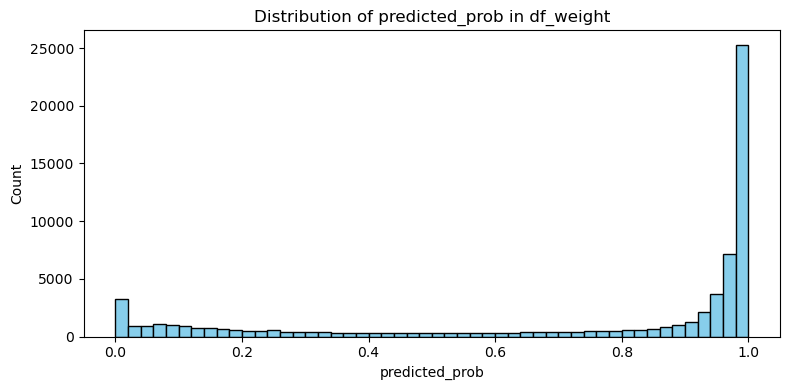

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(df_weight['predicted_prob'].dropna(), bins=50, color='skyblue', edgecolor='k')
plt.xlabel('predicted_prob')
plt.ylabel('Count')
plt.title('Distribution of predicted_prob in df_weight')
plt.tight_layout()
plt.show()

In [5]:
# # 删除含有指定字符的变量（列）
cols_to_remove = [col for col in df_weight.columns if any(x in col for x in ['gmm_score', 'gmm_density', 'predicted_label', 'predicted_prob', 'sample_type'])]
df_weight.drop(columns=cols_to_remove, inplace=True)


df_weight = df_weight.merge(
    df_mlp_scores[['lat', 'lon', 'gmm_score', 'gmm_density','predicted_label','predicted_prob','sample_type']],
    on=['lat', 'lon'],
    how='left'
)
df_weight
df_weight.to_csv('data/US_data/df_weight.csv', index=False)

In [6]:
df_weight

lat         lon        time  acc_forest  cap_forest  \
0      25.295834  -80.287500  2020-01-01   809.56850       859.4   
1      25.437500  -80.537500  2020-01-01  1389.71330      1436.6   
2      25.437500  -80.495834  2020-01-01  1026.14620      1072.6   
3      25.445833  -80.454170  2020-01-01  1026.14620      1073.7   
4      25.445833  -80.404170  2020-01-01  1051.13070      1093.3   
...          ...         ...         ...         ...         ...   
64977  48.995834 -111.970830  2020-01-01   201.90521       182.2   
64978  48.995834 -110.345830  2020-01-01   221.94190       198.1   
64979  48.995834 -106.020836  2020-01-01   232.56694       207.1   
64980  48.995834 -104.087500  2020-01-01   249.97507       225.2   
64981  48.995834 -104.079170  2020-01-01   250.36005       225.2   

       final_forest  weighted_density_Forest  weighted_density_Agricultural  \
0          809.5685                 0.998714                       0.000367   
1         1389.7133                 0.829869                       0.007830   
2         1026.1462                 0.771417                       0.022229   
3         1026.1462                 0.770923                       0.007369   
4         1051.1307                 0.714253                       0.099801   
...             ...                      ...                            ...   
64977      182.2000                 0.952007                       0.017433   
64978      198.1000                 0.626705                       0.332696   
64979      207.1000                 0.889626                       0.003256   
64980      225.2000                 0.456741                       0.057912   
64981      225.2000                 0.545928                       0.057969   

       weighted_density_Vegetation     acc_agro  ...   final_veg  env_scores  \
0                         0.000918   772.493469  ...   821.04486    0.272397   
1                         0.162302  1102.152466  ...  1126.51390    0.279062   
2                         0.206354   750.145691  ...   778.08900    0.272678   
3                         0.221708   756.315613  ...   777.34060    0.309372   
4                         0.185946   728.004333  ...   758.56060    0.307317   
...                            ...          ...  ...         ...         ...   
64977                     0.030560   170.484009  ...   174.20488    0.251081   
64978                     0.040599   175.665878  ...   177.52232    0.296190   
64979                     0.107118   209.715591  ...   207.00000    0.177785   
64980                     0.485347   204.508926  ...   207.61511    0.284555   
64981                     0.396103   204.543274  ...   208.25998    0.278915   

       pv_potential_dens  Expectation_net_benefit  Revenue_ratio  gmm_score  \
0            7191.865919              6382.303639       8.883647   0.051633   
1            7035.368191              5690.624063       5.231752   0.107510   
2            7024.124059              6055.300591       7.250159   0.033807   
3            7017.640780              6048.645138       7.242180   0.010552   
4            7045.490473              6081.010322       7.304962   0.081528   
...                  ...                      ...            ...        ...   
64977        6392.674772              6210.923349      35.172626   0.066566   
64978        6395.853979              6206.053157      33.697715   0.080337   
64979        6412.037900              6204.952188      30.963208   0.076823   
64980        6292.888713              6077.421747      29.205817   0.377389   
64981        6300.324426              6083.031871      28.994663   0.131587   

        gmm_density  predicted_label  predicted_prob      sample_type  
0      3.874315e+16                0        0.000000  negative_sample  
1      2.054387e+18                0        0.046746       prediction  
2      4.247702e+15                0        0.000000  negative_sample  
3      1.117299e+13                0        0.000

In [7]:
pixel_optimized_data = pd.read_csv(r'data\US_data\df_pixel_optimized_data.csv')
pixel_optimized_data


lon        lat       avg_npv  predicted_prob  \
0     -124.370834  47.954166 -9.371520e+05        0.045891   
1     -124.212500  40.570835  5.553589e+04        0.968293   
2     -124.204170  40.562500  1.223183e+04        0.960158   
3     -123.679170  48.120834 -1.048014e+06        0.277199   
4     -123.629166  48.120834 -1.145627e+06        0.229049   
...           ...        ...           ...             ...   
64977  -67.829170  46.887500 -9.098034e+05        0.999332   
64978  -67.829170  46.920834 -9.480477e+05        0.999058   
64979  -67.812500  46.312500 -9.327203e+05        0.999880   
64980  -67.804170  46.762500 -9.530168e+05        0.999813   
64981  -67.795830  46.320835 -9.298485e+05        0.999882   

       Expectation_net_benefit  optimal_weight_economic  \
0                  4824.921177             1.000000e+00   
1                  6284.450529             6.938894e-17   
2                  6230.448275             4.996004e-16   
3                  4834.164842             7.285839e-16   
4                  4699.726395             0.000000e+00   
...                        ...                      ...   
64977              5260.444799             1.387779e-16   
64978              5201.021838             1.110223e-16   
64979              5225.638163             0.000000e+00   
64980              5233.693273             5.551115e-17   
64981              5229.207903             0.000000e+00   

       optimal_weight_environmental  optimal_weight_emission  ccd_optimized  \
0                      3.989864e-16             3.382711e-17       0.367777   
1                      1.000000e+00             0.000000e+00       0.891990   
2                      1.000000e+00             3.053113e-16       0.886431   
3                      1.000000e+00             3.712308e-16       0.401650   
4                      1.000000e+00             4.510281e-17       0.384453   
...                             ...                      ...            ...   
64977                  1.000000e+00             3.053113e-16       0.756589   
64978                  1.000000e+00             0.000000e+00       0.749789   
64979                  1.000000e+00             0.000000e+00       0.752634   
64980                  1.000000e+00             2.220446e-16       0.751557   
64981                  1.000000e+00             2.498002e-16       0.753083   

       coupling_degree  coordination_degree  weight_deviation_economic  \
0             0.997039             0.135661                   0.666667   
1             0.987990             0.805318                  -0.333333   
2             0.984316             0.798280                  -0.333333   
3             0.987786             0.163317                  -0.333333   
4             0.990807             0.149175                  -0.333333   
...                ...                  ...                        ...   
64977         0.689239             0.830521                  -0.333333   
64978         0.677077             0.830309                  -0.333333   
64979         0.681705             0.830942                  -0.333333   
64980         0.679798             0.830891                  -0.333333   
64981         0.682518             0.830944                  -0.333333   

       weight_deviation_environmental  weight_deviation_emission  \
0                           -0.333333                  -0.333333   
1                            0.666667                  -0.333333   
2                            0.666667                  -0.333333   
3                            0.666667                  -0.333333   
4                            0.666667                  -0.333333   
...                               ...                        ...   
64977                        0.666667                  -0.333333   
64978                        0.666667                  -0.333333   
64979                        0.666667                  -0.333333   
64980                        0.666667     

## 0 Logic of Mapping

说白了就是针对耦合协同度计算的数据

$$C = \left[\frac{\prod_{i=1}^{n} U_i}{\left(\frac{1}{n}\sum_{i=1}^{n} U_i\right)^n}\right]^{\frac{1}{n}}$$
$$T = \sum_{i=1}^{n} \alpha_i U_i$$
$$CCD = \sqrt{C \times T}$$


## 1、决策制图Class类加载

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import RobustScaler
from scipy.optimize import minimize
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import box

# Load shapefiles
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')
us_states = gpd.read_file('data/cb_2018_us_state_500k.shp')
us_nation = gpd.read_file('data/US_data/cb_2018_us_nation_5m.shp')


class SynergyCalculator:
    """Simplified synergy calculator"""
    
    def __init__(self, method='ccd', weights=None):
        self.method = method
        self.weights = weights if weights is not None else np.array([0.4, 0.3, 0.3])
    
    def calculate_cv_synergy(self, data_matrix):
        """Coefficient of variation method"""
        std_values = np.std(data_matrix, axis=1)
        mean_values = np.mean(data_matrix, axis=1)
        cv = std_values / (mean_values + 1e-8)
        return 1 / (1 + cv)
    
    def calculate_ccd_synergy(self, data_matrix):
        """Coupling coordination degree method"""
        n_variables = data_matrix.shape[1]
        
        # Coupling degree
        product_values = np.prod(data_matrix, axis=1)
        mean_values = np.mean(data_matrix, axis=1)
        coupling_degree = np.power(product_values / np.power(mean_values, n_variables), 1/n_variables)
        
        # Coordination degree
        coordination_degree = np.sum(data_matrix * self.weights, axis=1)
        
        # Coupling coordination degree
        ccd = np.sqrt(coupling_degree * coordination_degree)
        
        return ccd, coupling_degree, coordination_degree

    
    def calculate_optimization_synergy(self, data_matrix):
        """Optimization method for simple weighted sum with CCD compatibility"""
        n_samples, n_features = data_matrix.shape

        def objective(weights):
            weighted_sum = np.dot(data_matrix, weights)
            mean_score = np.mean(weighted_sum)
            penalty = 100 * (np.sum(weights) - 1)**2
            return -mean_score + penalty

        # Initial weights
        initial_weights = np.ones(n_features) / n_features

        # Constraints
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        bounds = [(0, 1) for _ in range(n_features)]

        # Optimize
        result = minimize(objective, initial_weights, method='SLSQP',
                            bounds=bounds, constraints=constraints, options={'maxiter': 1000})

        if result.success:
            optimal_weights = result.x
            synergy_score = np.dot(data_matrix, optimal_weights)
        else:
            optimal_weights = initial_weights
            synergy_score = np.dot(data_matrix, optimal_weights)

        # 为了兼容性，计算耦合度和协调度
        product_values = np.prod(data_matrix, axis=1)
        mean_values = np.mean(data_matrix, axis=1)
        coupling_degree = np.power(product_values / np.power(mean_values, n_features), 1/n_features)
        coordination_degree = np.sum(data_matrix * optimal_weights, axis=1)

        return synergy_score, coupling_degree, coordination_degree, optimal_weights

    def calculate_ccd_optimization_synergy(self, data_matrix):
        """Optimize CCD by finding optimal weights"""
        n_samples, n_features = data_matrix.shape
        
        def ccd_objective(weights):
            """目标函数：最大化CCD"""
            # 计算协调度
            coordination_degree = np.sum(data_matrix * weights, axis=1)
            
            # 计算耦合度
            product_values = np.prod(data_matrix, axis=1)
            mean_values = np.mean(data_matrix, axis=1)
            coupling_degree = np.power(product_values / np.power(mean_values, n_features), 1/n_features)
            
            # 计算CCD
            ccd = np.sqrt(coupling_degree * coordination_degree)
            
            # 返回负的CCD平均值（因为我们要最大化）
            return -np.mean(ccd)
        
        # 初始权重
        initial_weights = np.ones(n_features) / n_features
        
        # 约束：权重和为1
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        bounds = [(0, 1) for _ in range(n_features)]
        
        # 优化CCD
        result = minimize(ccd_objective, initial_weights, method='SLSQP',
                          bounds=bounds, constraints=constraints, options={'maxiter': 1000})
        
        if result.success:
            optimal_weights = result.x
            # 使用最优权重计算CCD
            coordination_degree = np.sum(data_matrix * optimal_weights, axis=1)
            product_values = np.prod(data_matrix, axis=1)
            mean_values = np.mean(data_matrix, axis=1)
            coupling_degree = np.power(product_values / np.power(mean_values, n_features), 1/n_features)
            ccd = np.sqrt(coupling_degree * coordination_degree)
            
            return ccd, coupling_degree, coordination_degree, optimal_weights
        else:
            # 如果优化失败，使用默认权重
            return self.calculate_ccd_synergy(data_matrix) + (self.weights,)
    
    def calculate_synergy(self, data_matrix):
        """Main calculation function"""

        if self.method == 'optimization':
            return self.calculate_optimization_synergy(data_matrix)
        elif self.method == 'ccd':
            return self.calculate_ccd_synergy(data_matrix)
        elif self.method == 'ccd_optimization':
            return self.calculate_ccd_optimization_synergy(data_matrix)
        else:
            raise ValueError(f"Unsupported method: {self.method}")

## 2、区域计算模块（State and County）

In [1]:



def calculate_regional_synergy(df_economic, df_weight, us_states_gdf, us_counties_gdf, 
                              aggregation_level='state', method='ccd'):
    """
    Calculate synergy at state or county level with sigmoid-based regional standardization
    """
    # Prepare data
    economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
    avg_npv = economic_2050.groupby(['lon', 'lat'])['net_npv_usd'].mean().reset_index()
    avg_npv.columns = ['lon', 'lat', 'avg_npv']
    
    env_data = df_weight[['lon', 'lat', 'predicted_prob']].copy()
    emission_data = df_weight[['lon', 'lat', 'Expectation_net_benefit']].copy()
    
    # Merge data
    merged_data = avg_npv.merge(env_data, on=['lon', 'lat'], how='inner')
    merged_data = merged_data.merge(emission_data, on=['lon', 'lat'], how='inner')
    
    # Create geometry for spatial join
    geometry = [Point(xy) for xy in zip(merged_data['lon'], merged_data['lat'])]
    gdf = gpd.GeoDataFrame(merged_data, geometry=geometry, crs='EPSG:4326')
    
    # Spatial join with regions
    if aggregation_level == 'state':
        region_gdf = us_states_gdf
        region_id_col = 'NAME'
    else:  # county
        region_gdf = us_counties_gdf
        region_id_col = 'NAME'
    
    region_gdf_4326 = region_gdf.to_crs('EPSG:4326')
    joined_gdf = gpd.sjoin(gdf, region_gdf_4326, how='inner', predicate='within')
    
    # Sigmoid标准化函数
    def sigmoid_standardization(data_matrix):
        """
        Sigmoid函数标准化：
        - 使用sigmoid函数处理大范围数据
        - 保持负值的相对重要性
        - 输出范围(0.1, 1.0)
        """
        standardized_data = np.zeros_like(data_matrix)
        
        for col in range(data_matrix.shape[1]):
            values = data_matrix[:, col]
            
            # 计算sigmoid参数
            mean_val = np.mean(values)
            std_val = np.std(values)
            
            # 避免标准差为0
            if std_val < 1e-8:
                std_val = np.abs(mean_val) if mean_val != 0 else 1.0
            
            # 使用sigmoid函数
            sigmoid_values = 1 / (1 + np.exp(-(values - mean_val) / (std_val * 0.5)))
            
            # 调整到(0.1, 1.0)范围
            standardized_data[:, col] = 0.1 + 0.9 * sigmoid_values
        
        return standardized_data
    
    # Group by region and calculate synergy
    regional_results = []
    
    for region_name, group in joined_gdf.groupby(region_id_col):
        if len(group) < 10:  # Skip regions with too few pixels
            continue
            
        variables = ['avg_npv', 'predicted_prob', 'Expectation_net_benefit']
        
        # 检查区域内部数据
        region_data = group[variables].values
        
        # 如果某个变量在区域内所有值都相同，跳过该区域
        if np.any([np.allclose(region_data[:, i], region_data[0, i]) for i in range(3)]):
            print(f"Skipping {region_name}: all values are identical for at least one variable")
            continue
        
        # 使用sigmoid标准化
        scaled_data = sigmoid_standardization(region_data)
        
        # 计算协同度 - 使用指定的方法
        calculator = SynergyCalculator(method=method)
        ccd_result = calculator.calculate_synergy(scaled_data)
        
        # 处理不同方法的返回值
        if method == 'ccd_optimization' and len(ccd_result) == 4:
            ccd, coupling, coordination, optimal_weights = ccd_result
        elif method == 'optimization' and len(ccd_result) == 4:
            # Optimization方法现在也返回4个值
            ccd, coupling, coordination, optimal_weights = ccd_result
        elif len(ccd_result) == 3:  # 其他方法返回3个值
            ccd, coupling, coordination = ccd_result
            optimal_weights = None
        else:
            print(f"Warning: Unexpected result format for {method} in {region_name}, length: {len(ccd_result)}")
            continue
            
        # 检查计算结果是否有效
        if np.any(np.isnan(ccd)) or np.any(np.isinf(ccd)):
            print(f"Warning: Invalid CCD values in {region_name}")
            continue
        
        # 分析经济可行性
        economic_feasible_ratio = (group['avg_npv'] > 0).mean()
        
        result_dict = {
            'region': region_name,
            'pixel_count': len(group),
            'ccd_mean': np.mean(ccd),
            'ccd_std': np.std(ccd),
            'coupling_mean': np.mean(coupling),
            'coordination_mean': np.mean(coordination),
            'avg_npv_mean': group['avg_npv'].mean(),
            'env_scores_mean': group['predicted_prob'].mean(),
            'emission_benefit_mean': group['Expectation_net_benefit'].mean(),
            'avg_npv_std': group['avg_npv'].std(),
            'env_scores_std': group['predicted_prob'].std(),
            'emission_benefit_std': group['Expectation_net_benefit'].std(),
            'economic_feasible_ratio': economic_feasible_ratio
        }
        
        # 如果使用优化方法，添加最优权重信息
        if optimal_weights is not None:
            result_dict.update({
                'optimal_weight_economic': optimal_weights[0],
                'optimal_weight_environmental': optimal_weights[1],
                'optimal_weight_emission': optimal_weights[2]
            })
        
        regional_results.append(result_dict)
    
    return pd.DataFrame(regional_results)
    
def plot_regional_synergy(regional_df, us_states_gdf, us_counties_gdf, aggregation_level='state'):
    """Plot regional synergy results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: CCD by region
    if aggregation_level == 'state':
        region_gdf = us_states_gdf
        region_id_col = 'NAME'
    else:
        region_gdf = us_counties_gdf
        region_id_col = 'NAME'
    
    region_gdf_4326 = region_gdf.to_crs('EPSG:4326')
    
    # Merge results with geometry
    plot_gdf = region_gdf_4326.merge(regional_df, left_on=region_id_col, right_on='region', how='left')
    
    # Plot CCD
    plot_gdf.plot(column='ccd_mean', ax=ax1, legend=True, 
                  cmap='RdYlBu_r', missing_kwds={'color': 'lightgray'})
    ax1.set_title(f'Coupling Coordination Degree by {aggregation_level.title()}')
    ax1.set_xlim(-125, -65)
    ax1.set_ylim(24, 51)
    
    # Plot 2: Scatter plot of coupling vs coordination
    ax2.scatter(regional_df['coupling_mean'], regional_df['coordination_mean'], 
                s=regional_df['pixel_count']/10, alpha=0.7, c=regional_df['ccd_mean'], 
                cmap='RdYlBu_r')
    ax2.set_xlabel('Coupling Degree')
    ax2.set_ylabel('Coordination Degree')
    ax2.set_title('Coupling vs Coordination by Region')
    
    plt.tight_layout()
    plt.show()
    
    return plot_gdf

# Usage
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')

methods = ['ccd', 'ccd_optimization', 'optimization']

comparison_results = {}

for method in methods:
    print(f"\nCalculating {method} method...")
    
    # State level
    state_result = calculate_regional_synergy(df_economic, df_weight, us_states_4326, 
                                             us_counties_4326, aggregation_level='state',
                                             method=method)
    
    # County level
    county_result = calculate_regional_synergy(df_economic, df_weight, us_states_4326, 
                                              us_counties_4326, aggregation_level='county',
                                              method=method)
    
    comparison_results[method] = {
        'state': state_result,
        'county': county_result
    }
    
    # 检查结果是否为空
    if len(state_result) > 0 and 'ccd_mean' in state_result.columns:
        print(f"{method} - State CCD mean: {state_result['ccd_mean'].mean():.4f}")
        print(f"{method} - State regions processed: {len(state_result)}")
    else:
        print(f"{method} - State level: No valid results")
    
    if len(county_result) > 0 and 'ccd_mean' in county_result.columns:
        print(f"{method} - County CCD mean: {county_result['ccd_mean'].mean():.4f}")
        print(f"{method} - County regions processed: {len(county_result)}")
    else:
        print(f"{method} - County level: No valid results")

NameError: name 'us_states' is not defined

## 3、区域绘图模块（对比两方法）


Creating maps for ccd method...
Creating state-level map for ccd...


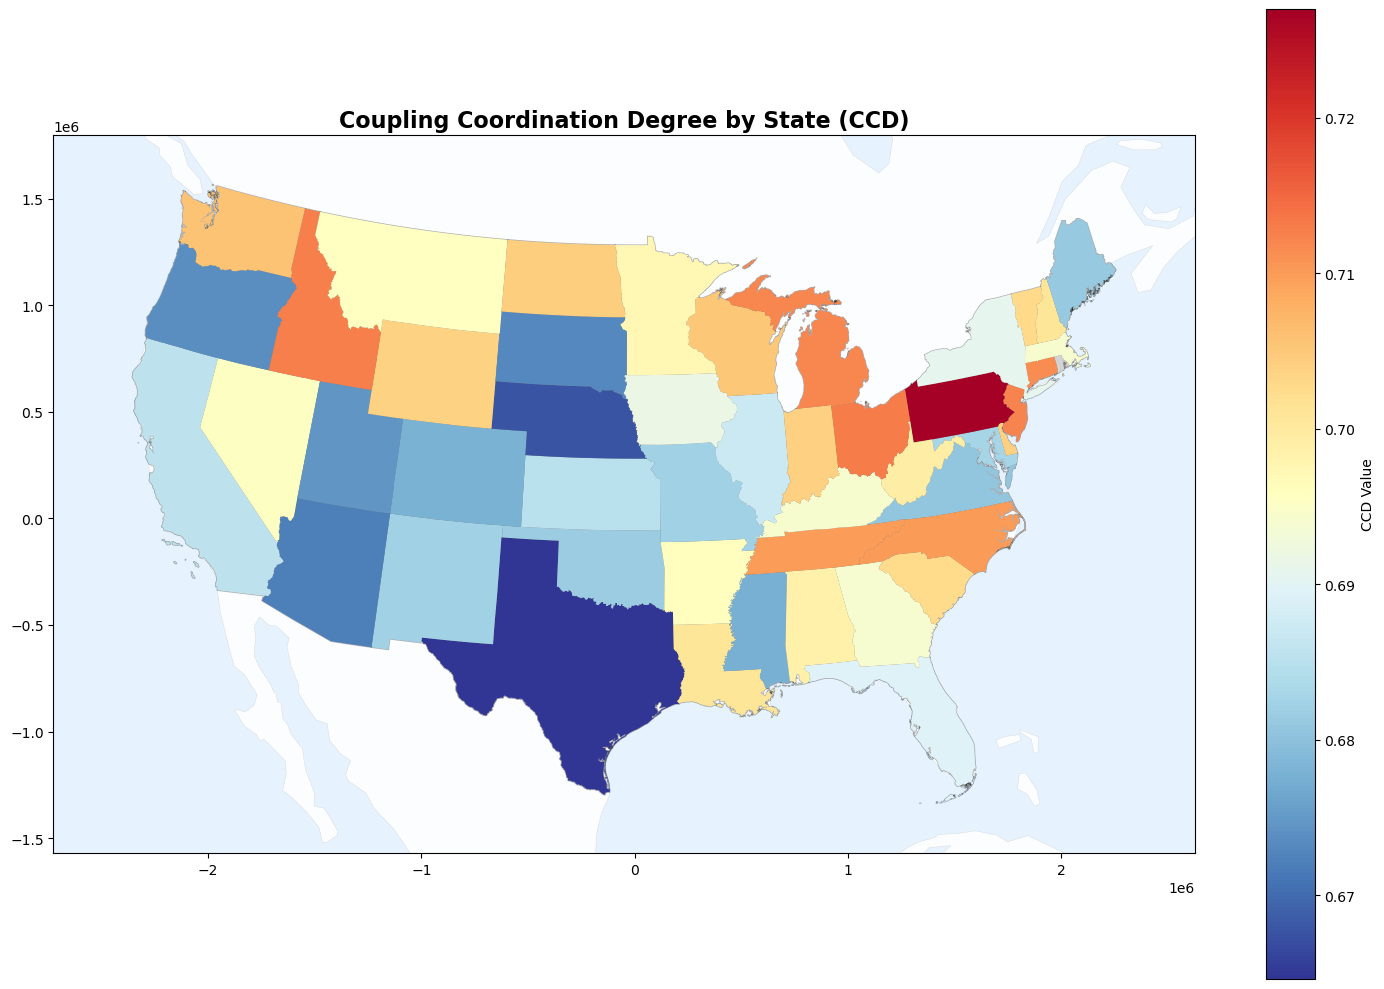

Creating county-level map for ccd...


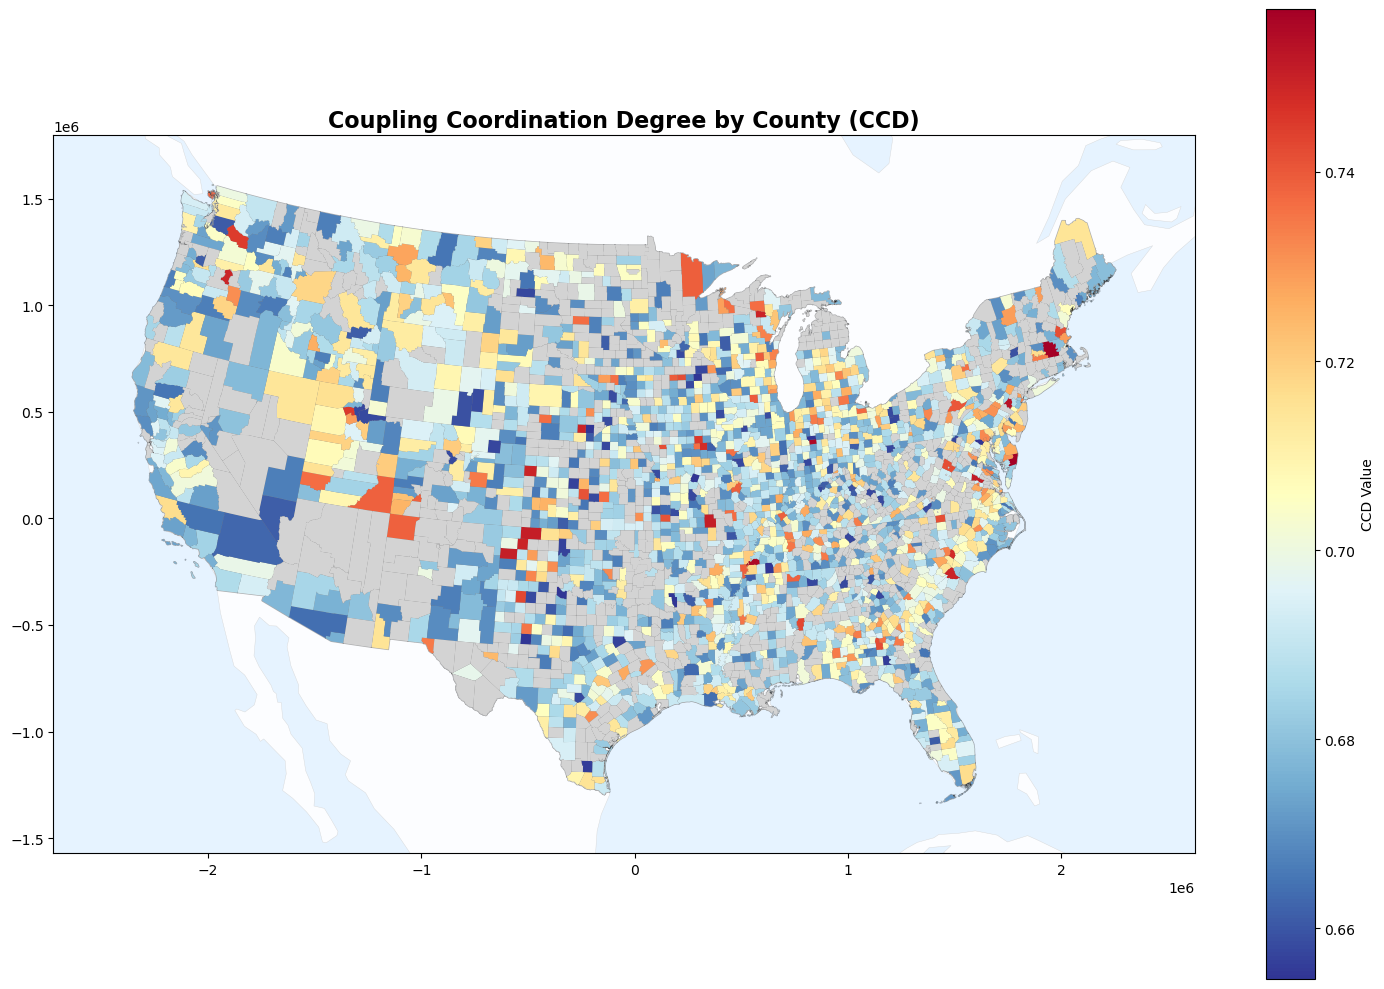


Creating maps for ccd_optimization method...
Creating state-level map for ccd_optimization...


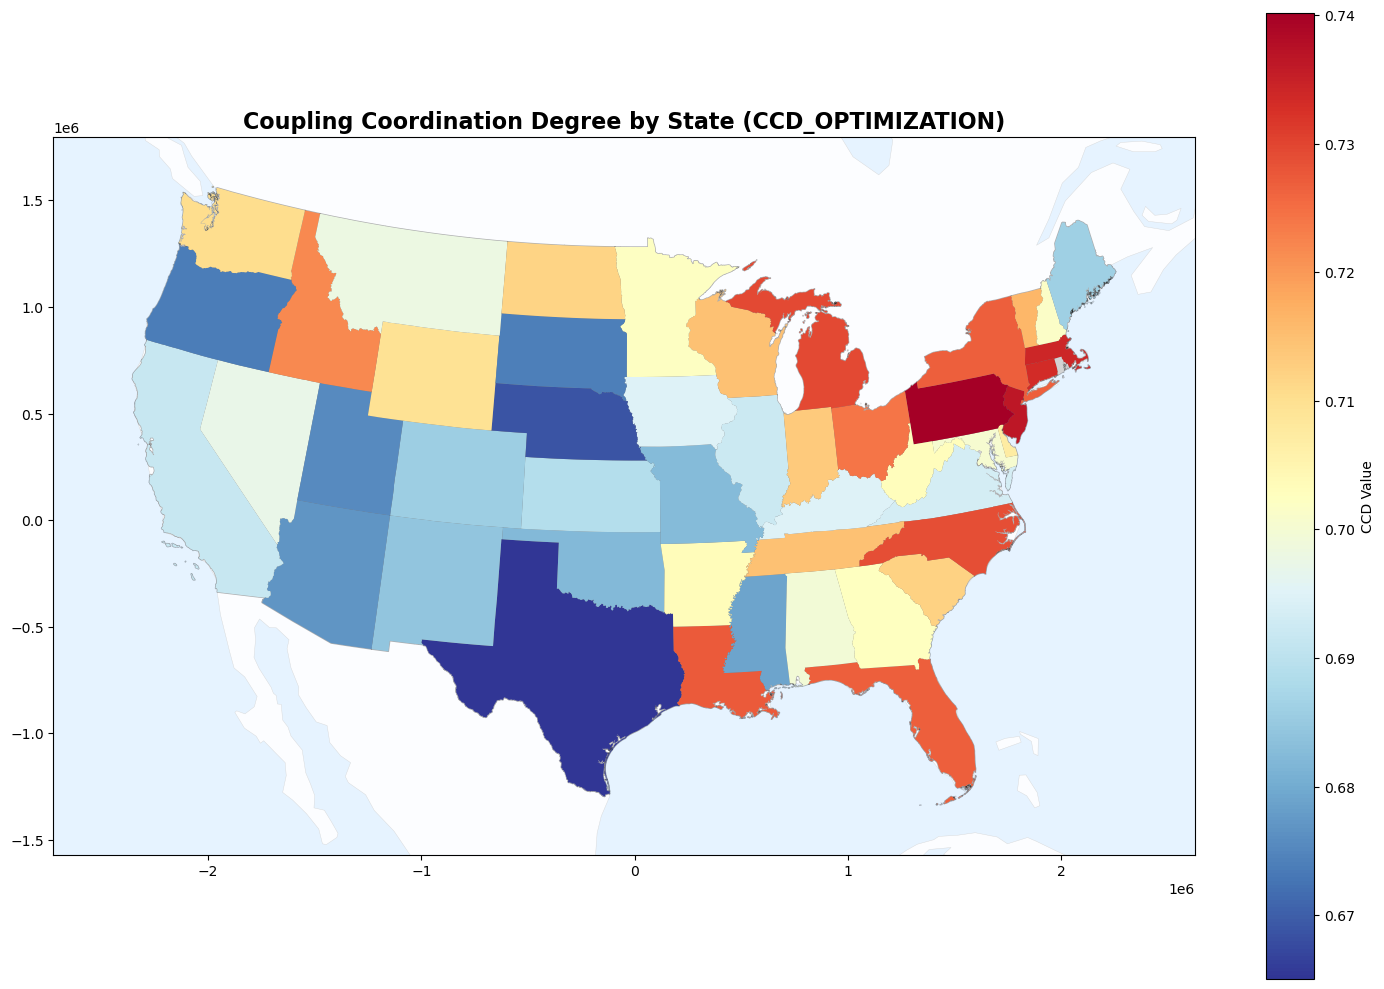

Creating county-level map for ccd_optimization...


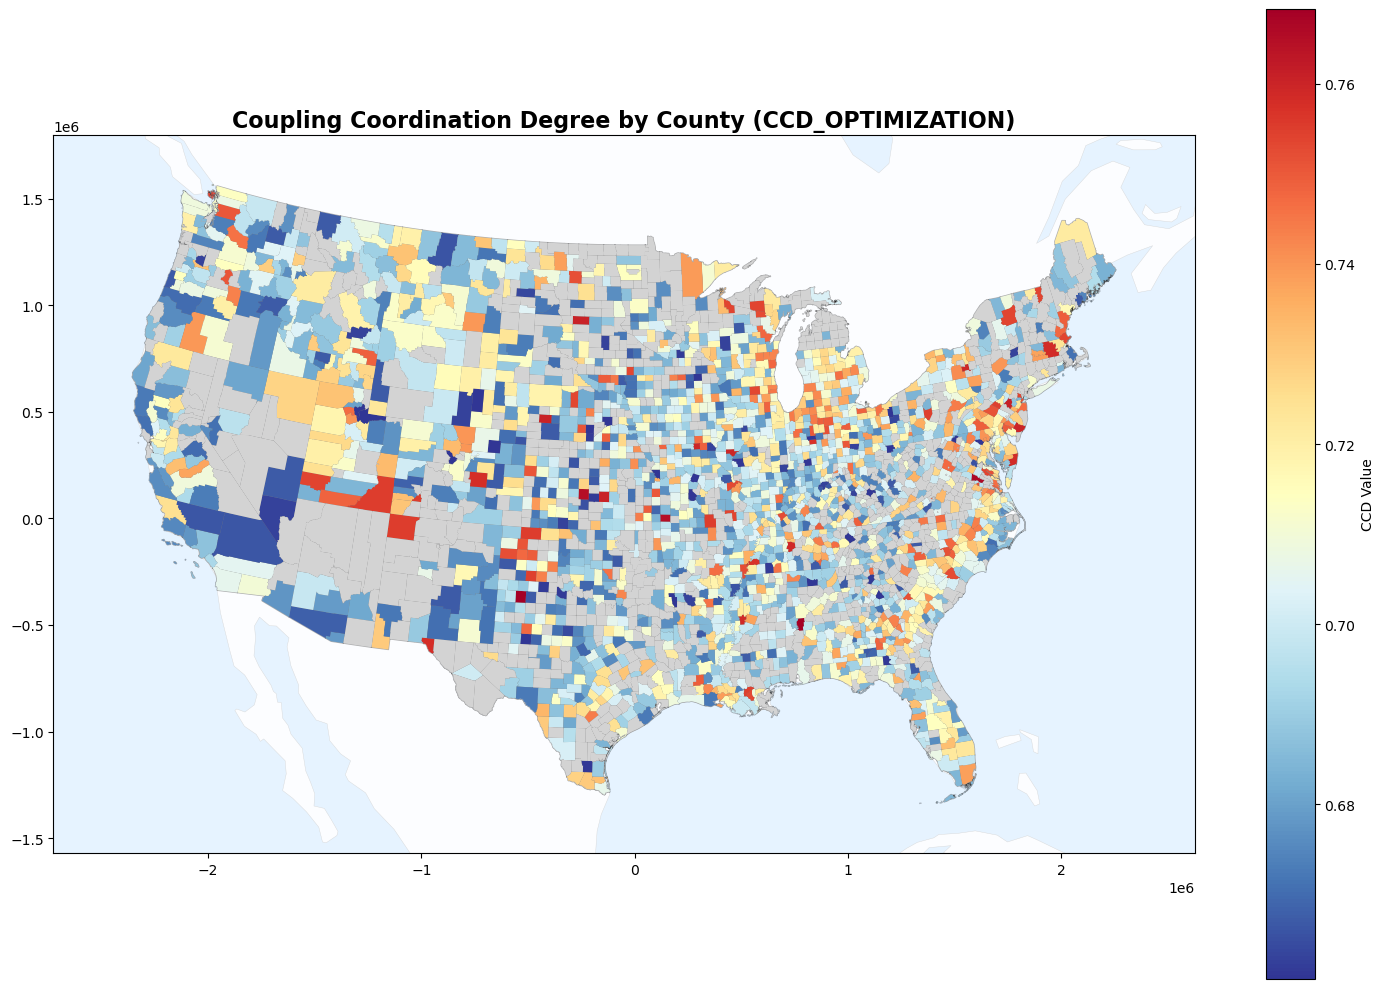


Creating comparison maps...


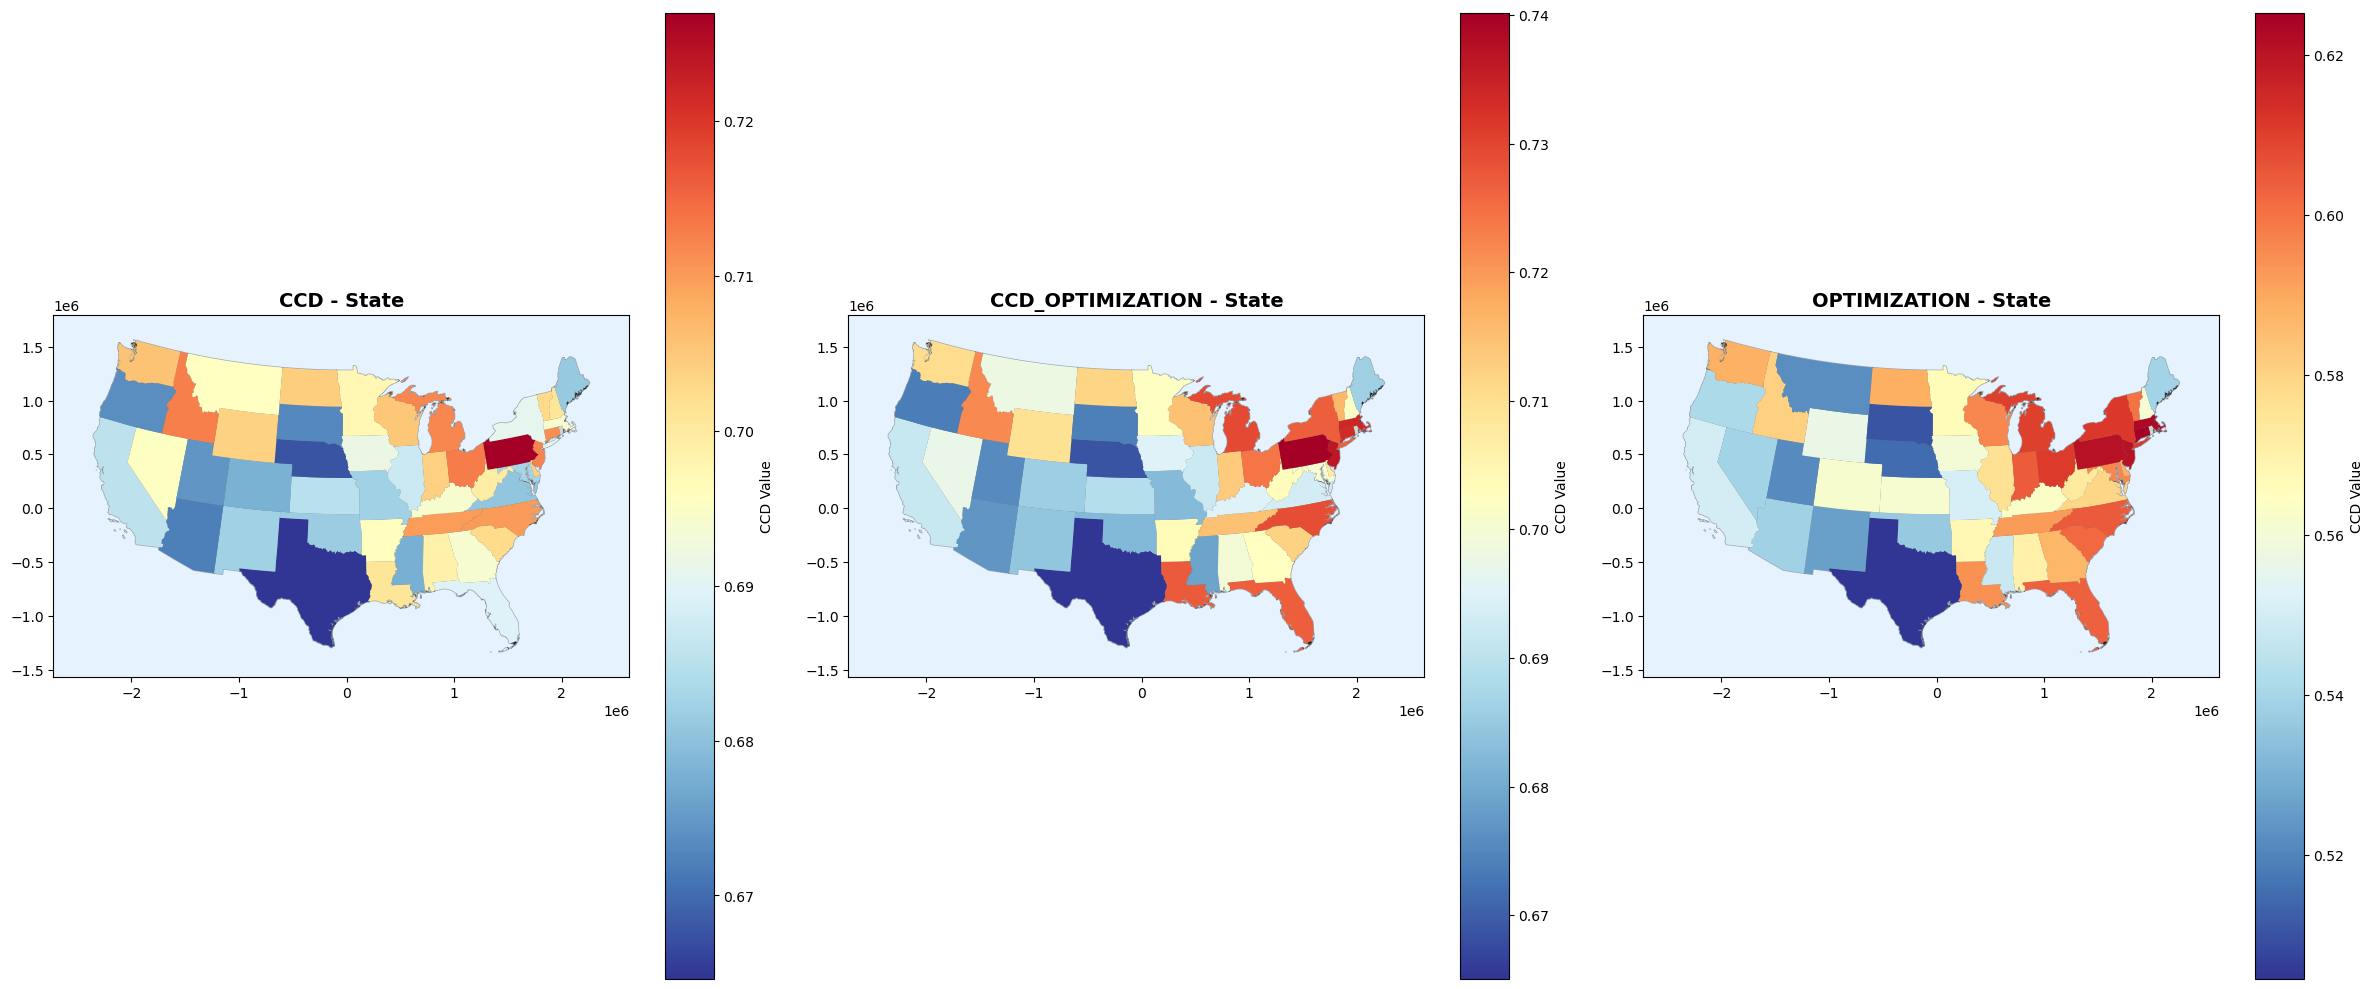

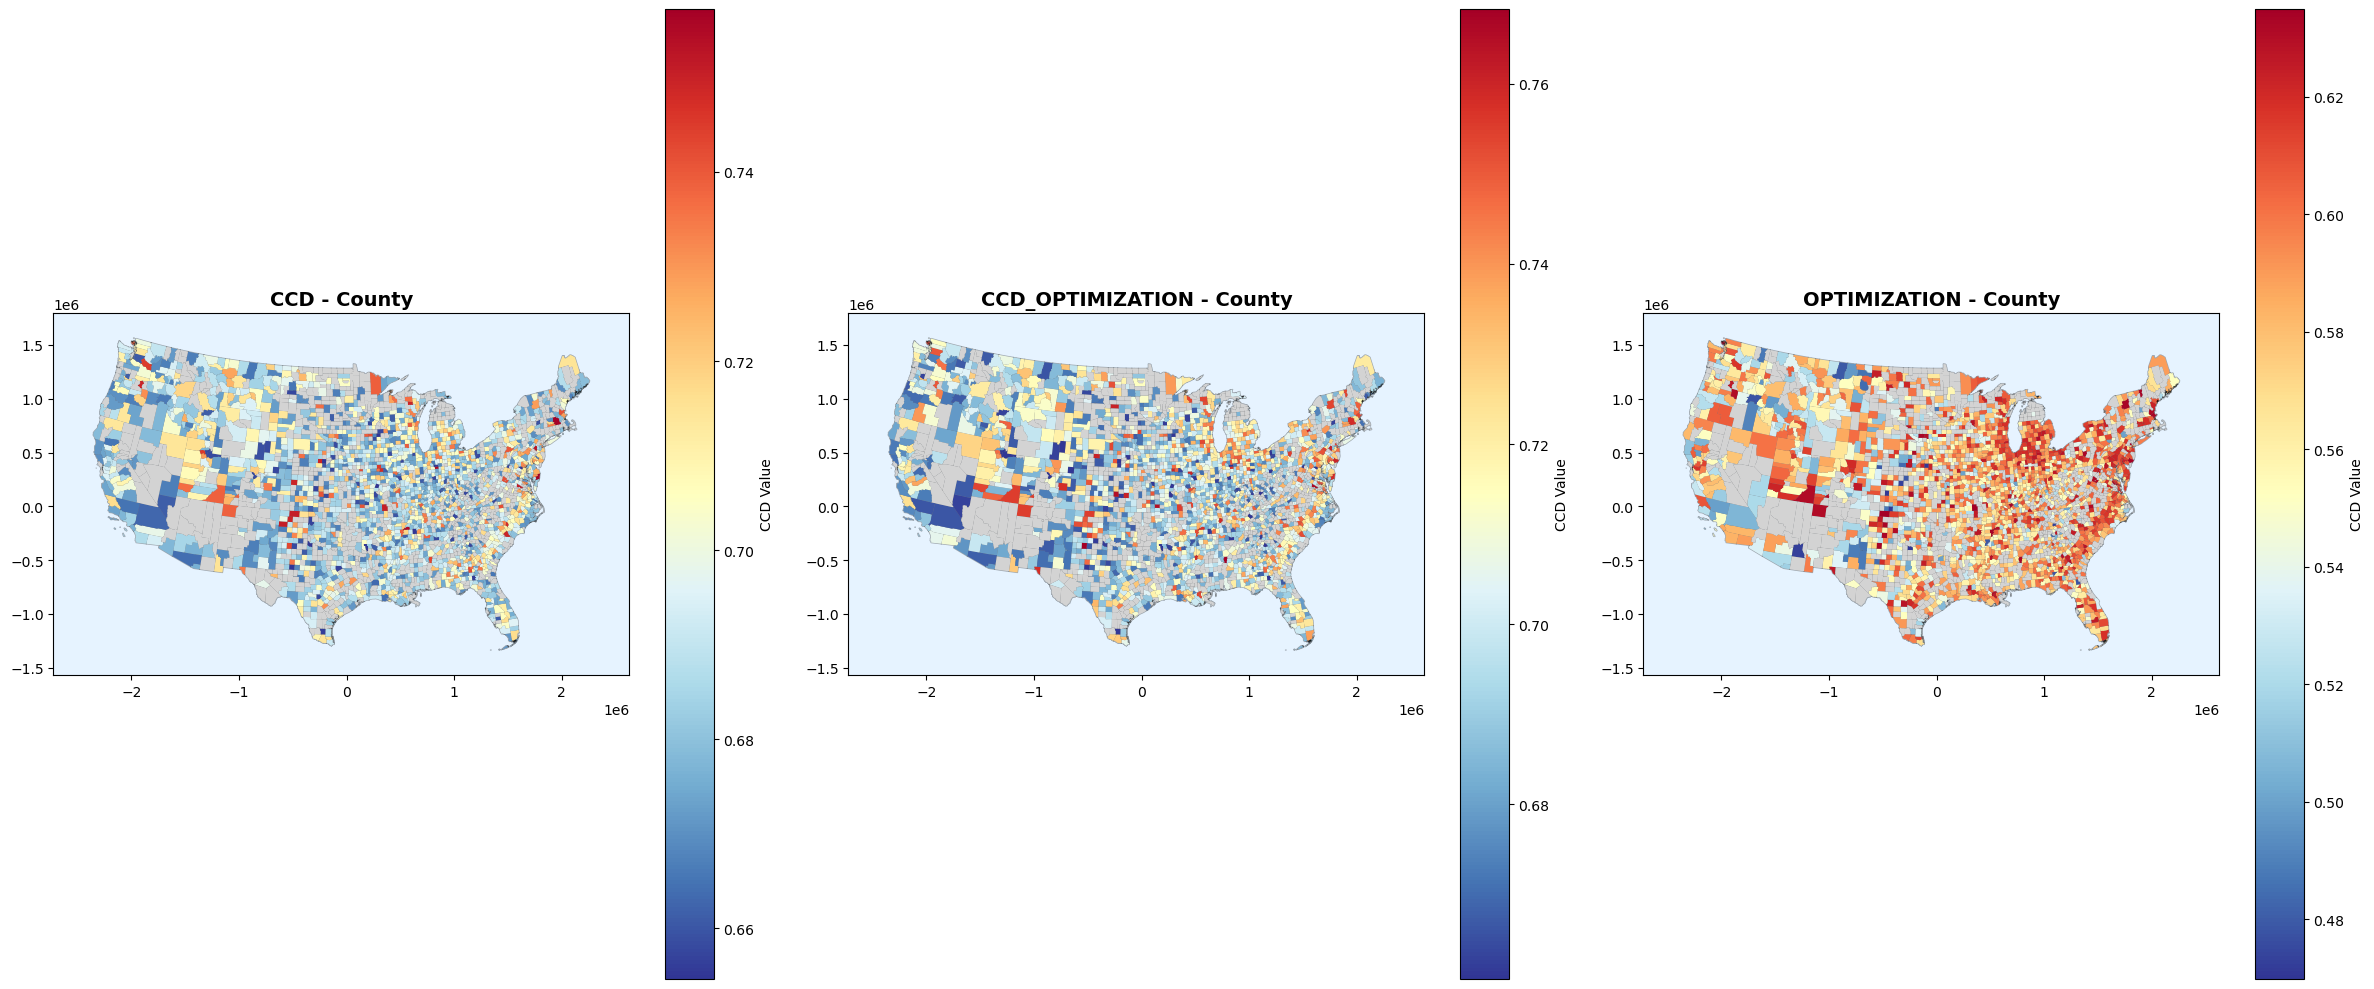

In [34]:

def plot_regional_synergy_with_basemap(regional_df, us_states_gdf, us_counties_gdf, 
                                      aggregation_level='state', method='ccd'):
    """Plot regional synergy results with proper basemap - CCD distribution only"""
    
    # 设置图形 - 只用一个子图
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    
    # 定义美国边界
    usa_bounds_main = {
        'lon_min': -125,
        'lon_max': -65,
        'lat_min': 24,
        'lat_max': 51 
    }
    
    # 创建边界框
    bbox = box(usa_bounds_main['lon_min'], 
              usa_bounds_main['lat_min'], 
              usa_bounds_main['lon_max'], 
              usa_bounds_main['lat_max'])
    
    # 选择区域数据
    if aggregation_level == 'state':
        region_gdf = us_states_gdf
        region_id_col = 'NAME'
    else:
        region_gdf = us_counties_gdf
        region_id_col = 'NAME'
    
    # 裁剪并投影区域边界
    region_bound = region_gdf.to_crs(epsg=4326).clip(bbox)
    region_bound_albers = region_bound.to_crs('ESRI:102003')
    
    # 设置底图
    ax.set_facecolor('#e6f3ff')
    
    # 添加世界大陆底图
    helper_shapefile = r'figure\draw_shp\ne_110m_land.shp'
    try:
        helper_gdf = gpd.read_file(helper_shapefile)
        
        # 创建扩展边界框
        extended_bbox = box(
            usa_bounds_main['lon_min'] - 5,
            usa_bounds_main['lat_min'] - 3,
            usa_bounds_main['lon_max'] + 5,
            usa_bounds_main['lat_max'] + 3
        )
        
        # 裁剪世界大陆底图
        helper_gdf_clipped = helper_gdf.to_crs(epsg=4326).clip(extended_bbox)
        helper_gdf_proj = helper_gdf_clipped.to_crs('ESRI:102003')
        
        # 绘制底图
        helper_gdf_proj.plot(ax=ax, color='white', 
                            edgecolor='lightgray', linewidth=0.3, alpha=0.9)
        
    except Exception as e:
        print(f"Helper map error: {e}")
    
    # 绘制区域边界
    region_bound_albers.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.3)
    
    # 合并结果与几何数据
    plot_gdf = region_bound_albers.merge(regional_df, left_on=region_id_col, right_on='region', how='left')
    
    # 绘制CCD分布图
    plot_gdf.plot(column='ccd_mean', ax=ax, legend=True, 
                  cmap='RdYlBu_r', missing_kwds={'color': 'lightgray'},
                  legend_kwds={'label': 'CCD Value', 'orientation': 'vertical'})
    
    ax.set_title(f'Coupling Coordination Degree by {aggregation_level.title()} ({method.upper()})', 
                  fontsize=16, fontweight='bold')
    
    # 设置地图边界
    xmin, ymin, xmax, ymax = region_bound_albers.total_bounds
    map_width = xmax - xmin
    map_height = ymax - ymin
    margin_percentage = 0.08
    margin_x = map_width * margin_percentage
    margin_y = map_height * margin_percentage
    
    ax.set_xlim(xmin - margin_x, xmax + margin_x)
    ax.set_ylim(ymin - margin_y, ymax + margin_y)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    return plot_gdf

# 为每种方法创建制图
methods = ['ccd', 'ccd_optimization']

for method in methods:
    print(f"\nCreating maps for {method} method...")
    
    # State level maps
    if len(comparison_results[method]['state']) > 0:
        print(f"Creating state-level map for {method}...")
        state_plot = plot_regional_synergy_with_basemap(
            comparison_results[method]['state'], 
            us_states_4326, 
            us_counties_4326, 
            aggregation_level='state', 
            method=method
        )
    
    # County level maps
    if len(comparison_results[method]['county']) > 0:
        print(f"Creating county-level map for {method}...")
        county_plot = plot_regional_synergy_with_basemap(
            comparison_results[method]['county'], 
            us_states_4326, 
            us_counties_4326, 
            aggregation_level='county', 
            method=method
        )

# 创建对比图 - 只显示CCD分布
def create_comparison_maps(comparison_results, aggregation_level='state'):
    """创建不同方法的对比图 - 只显示CCD分布"""
    
    methods = list(comparison_results.keys())
    valid_methods = [m for m in methods if len(comparison_results[m][aggregation_level]) > 0]
    
    if len(valid_methods) == 0:
        print(f"No valid data for {aggregation_level} level")
        return
    
    # 设置图形
    fig, axes = plt.subplots(1, len(valid_methods), figsize=(8*len(valid_methods), 10))
    if len(valid_methods) == 1:
        axes = [axes]
    
    # 定义美国边界
    usa_bounds_main = {
        'lon_min': -125,
        'lon_max': -65,
        'lat_min': 24,
        'lat_max': 51 
    }
    
    bbox = box(usa_bounds_main['lon_min'], 
              usa_bounds_main['lat_min'], 
              usa_bounds_main['lon_max'], 
              usa_bounds_main['lat_max'])
    
    # 选择区域数据
    if aggregation_level == 'state':
        region_gdf = us_states_4326
        region_id_col = 'NAME'
    else:
        region_gdf = us_counties_4326
        region_id_col = 'NAME'
    
    # 裁剪并投影
    region_bound = region_gdf.to_crs(epsg=4326).clip(bbox)
    region_bound_albers = region_bound.to_crs('ESRI:102003')
    
    for i, method in enumerate(valid_methods):
        ax = axes[i]
        ax.set_facecolor('#e6f3ff')
        
        # 添加底图
        helper_shapefile = r'figure\draw_shp\ne_110m_land.shp'
        try:
            helper_gdf = gpd.read_file(helper_shapefile)
            extended_bbox = box(
                usa_bounds_main['lon_min'] - 5,
                usa_bounds_main['lat_min'] - 3,
                usa_bounds_main['lon_max'] + 5,
                usa_bounds_main['lon_max'] + 3
            )
            helper_gdf_clipped = helper_gdf.to_crs(epsg=4326).clip(extended_bbox)
            helper_gdf_proj = helper_gdf_clipped.to_crs('ESRI:102003')
            helper_gdf_proj.plot(ax=ax, color='white', 
                                edgecolor='lightgray', linewidth=0.3, alpha=0.9)
        except Exception as e:
            print(f"Helper map error: {e}")
        
        # 绘制区域边界
        region_bound_albers.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.3)
        
        # 合并数据并绘制
        plot_gdf = region_bound_albers.merge(
            comparison_results[method][aggregation_level], 
            left_on=region_id_col, right_on='region', how='left'
        )
        
        plot_gdf.plot(column='ccd_mean', ax=ax, legend=True, 
                      cmap='RdYlBu_r', missing_kwds={'color': 'lightgray'},
                      legend_kwds={'label': 'CCD Value'})
        
        ax.set_title(f'{method.upper()} - {aggregation_level.title()}', 
                     fontsize=14, fontweight='bold')
        
        # 设置地图边界
        xmin, ymin, xmax, ymax = region_bound_albers.total_bounds
        map_width = xmax - xmin
        map_height = ymax - ymin
        margin_percentage = 0.08
        margin_x = map_width * margin_percentage
        margin_y = map_height * margin_percentage
        
        ax.set_xlim(xmin - margin_x, xmax + margin_x)
        ax.set_ylim(ymin - margin_y, ymax + margin_y)
        ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

# 创建对比图
print("\nCreating comparison maps...")
create_comparison_maps(comparison_results, 'state')
create_comparison_maps(comparison_results, 'county')

## 4、像素计算模块（为5提供数据）

Starting pixel-level optimization...
Processing 64,982 pixels...
Standardization completed:
  Economic values range: [0.105, 1.000]
  Environmental values range: [0.114, 0.831]
  Emission values range: [0.100, 1.000]

Standardization Analysis:
  Economic feasible pixels: 19,881 (30.6%)
  Economic infeasible pixels: 45,101 (69.4%)

Standardized values by economic feasibility:
  Feasible regions - Economic: 0.876, Env: 0.521, Emission: 0.858
  Infeasible regions - Economic: 0.364, Env: 0.647, Emission: 0.372

Equal weights baseline: [0.33333333 0.33333333 0.33333333]
Processed 10,000/64,982 pixels (15.4%)
Processed 20,000/64,982 pixels (30.8%)
Processed 30,000/64,982 pixels (46.2%)
Processed 40,000/64,982 pixels (61.6%)
Processed 50,000/64,982 pixels (76.9%)
Processed 60,000/64,982 pixels (92.3%)
Processed 64,982/64,982 pixels (100.0%)

Weight Analysis by Economic Feasibility:

Feasible regions (NPV > 0):
  Economic weight: 0.374
  Environmental weight: 0.173
  Emission weight: 0.452

In

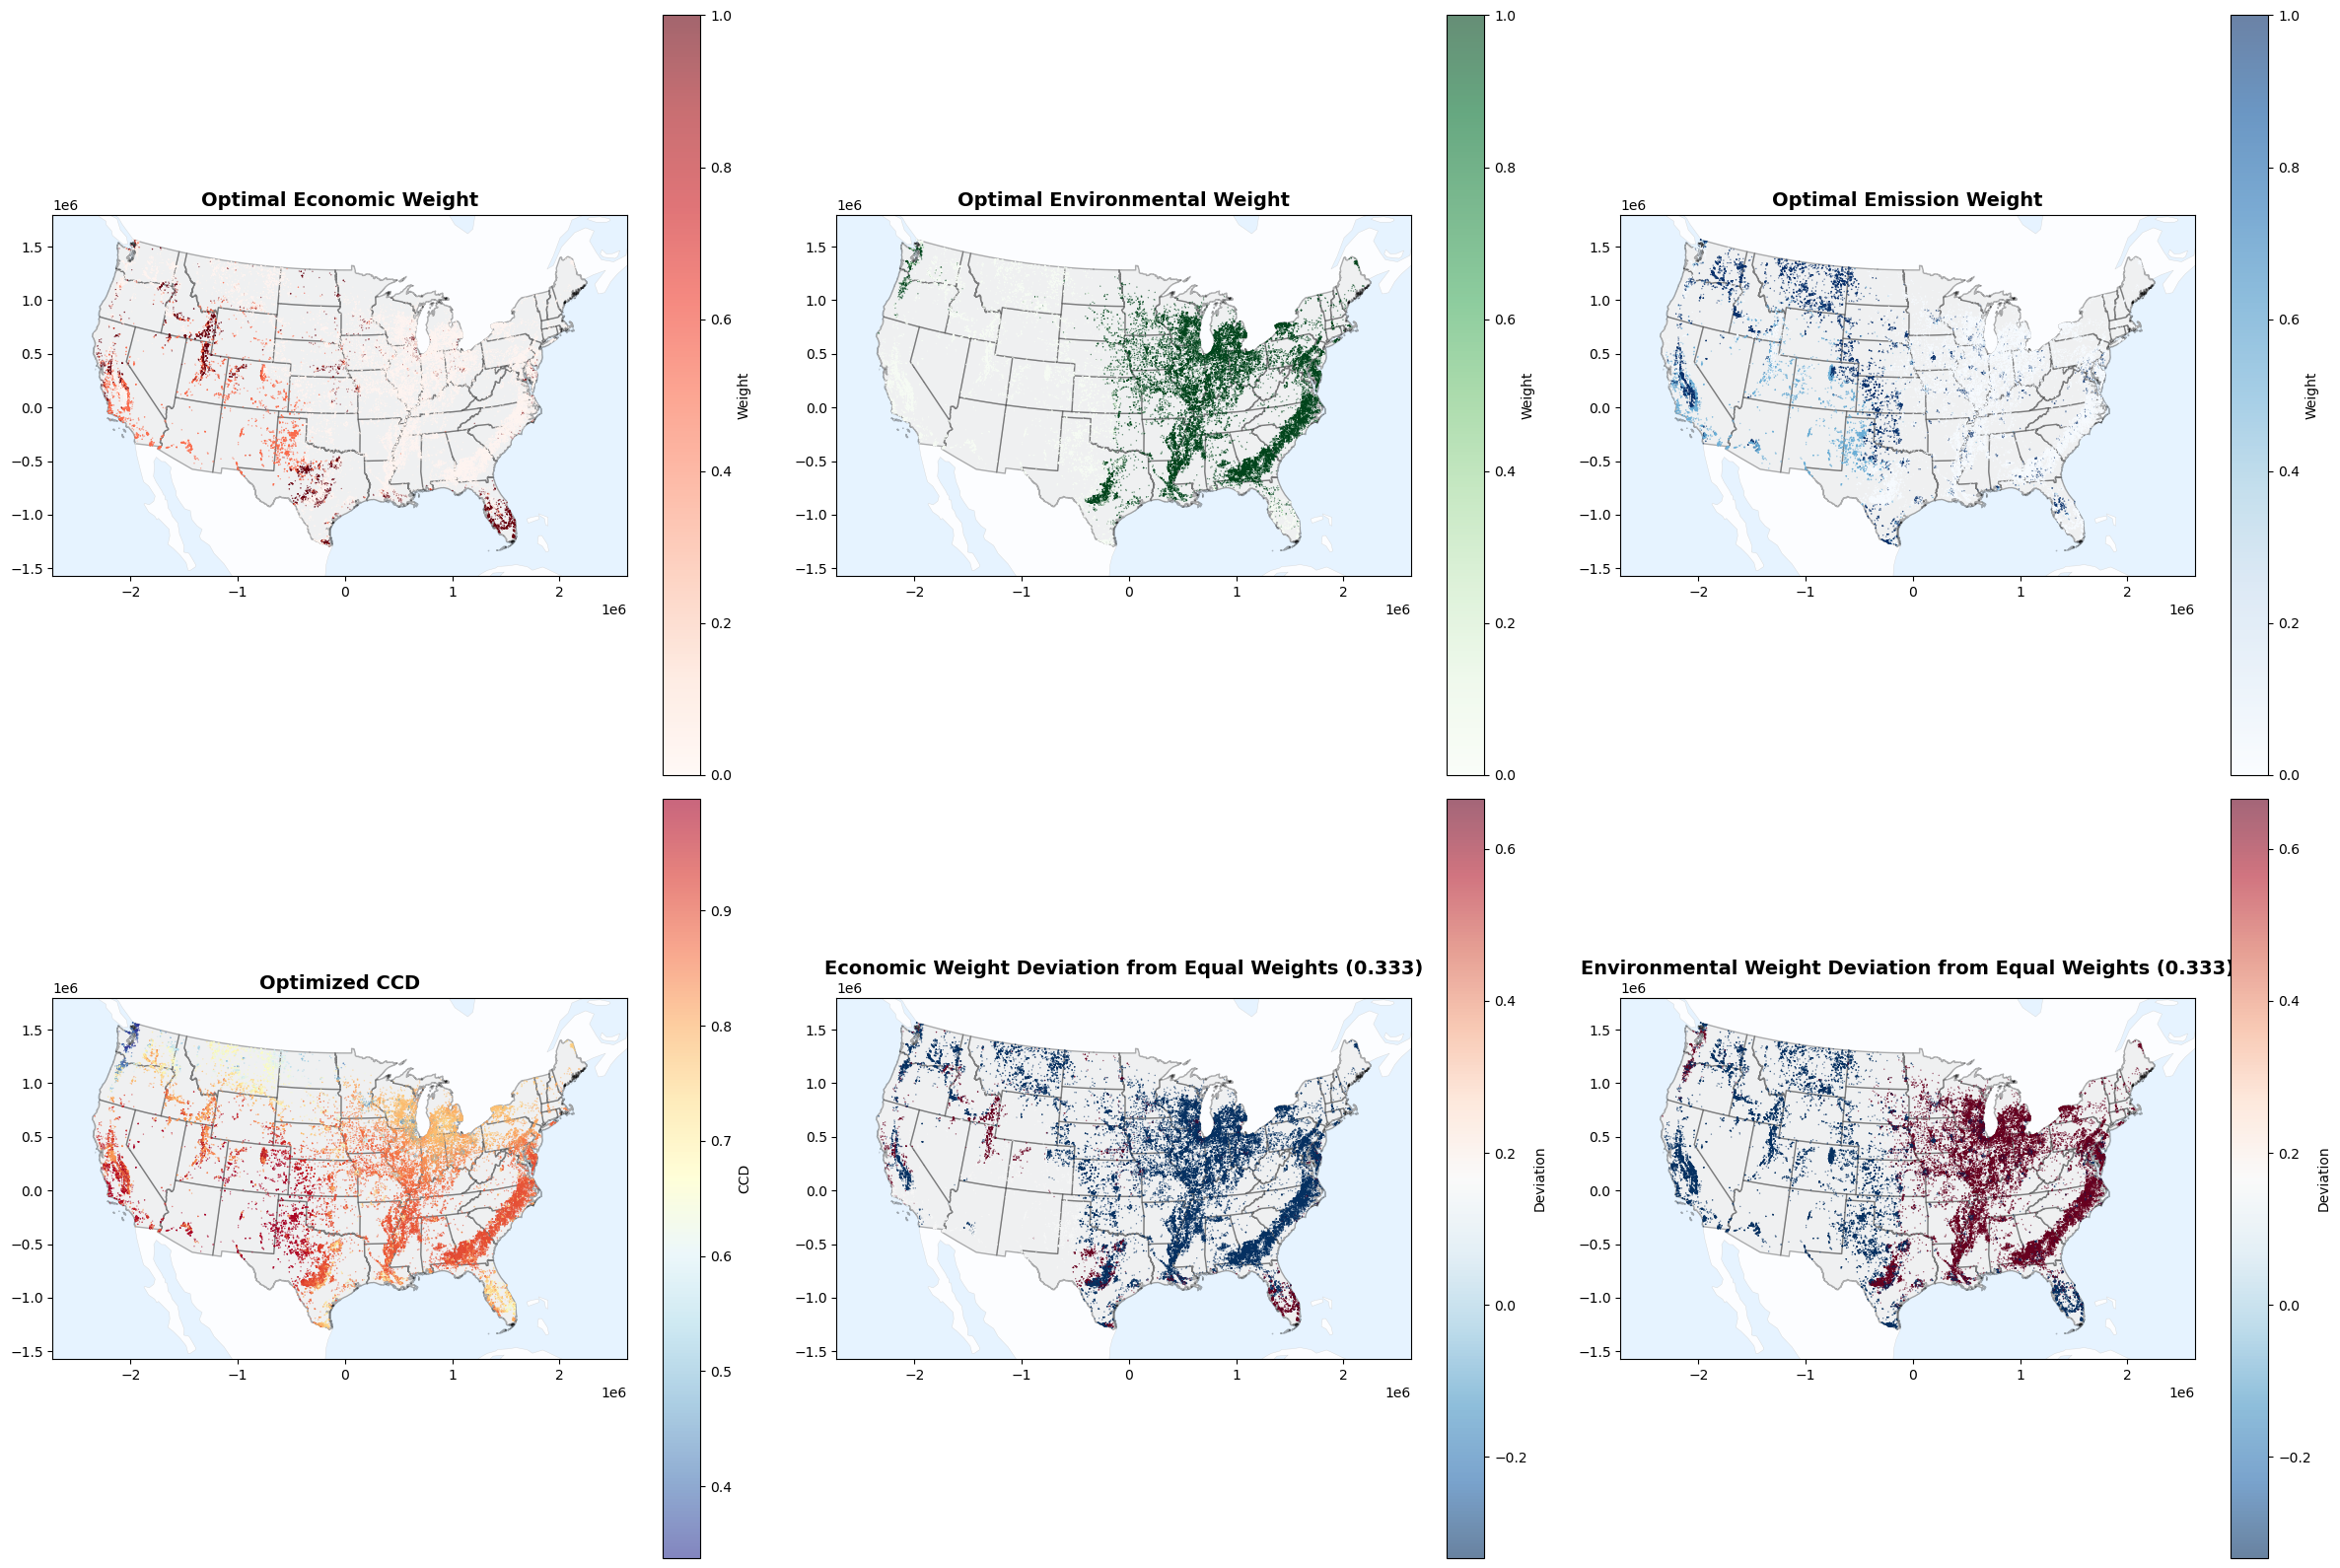


=== PIXEL-LEVEL OPTIMIZATION STATISTICS ===
Total pixels processed: 64,982

Optimal Weights Statistics:
Economic weight - Mean: 0.154, Std: 0.322
Environmental weight - Mean: 0.596, Std: 0.490
Emission weight - Mean: 0.250, Std: 0.401

CCD Statistics:
Optimized CCD - Mean: 0.817, Std: 0.122

Weight Deviation Statistics (vs Equal Weights 0.333):
Economic deviation - Mean: -0.180, Std: 0.322
Environmental deviation - Mean: 0.263, Std: 0.490
Emission deviation - Mean: -0.083, Std: 0.401

Weight Distribution Analysis:
Pixels with economic weight > 0.5: 9,372 (14.4%)
Pixels with environmental weight > 0.5: 38,753 (59.6%)
Pixels with emission weight > 0.5: 16,850 (25.9%)


In [4]:
def calculate_pixel_level_optimization(df_economic, df_weight, us_states_gdf, us_counties_gdf):
    """Calculate optimal weights for each pixel individually with sigmoid-based standardization"""
    
    # Prepare data
    economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
    avg_npv = economic_2050.groupby(['lon', 'lat'])['net_npv_usd'].mean().reset_index()
    avg_npv.columns = ['lon', 'lat', 'avg_npv']
    
    env_data = df_weight[['lon', 'lat', 'predicted_prob']].copy()
    emission_data = df_weight[['lon', 'lat', 'Expectation_net_benefit']].copy()
    
    # Merge data
    merged_data = avg_npv.merge(env_data, on=['lon', 'lat'], how='inner')
    merged_data = merged_data.merge(emission_data, on=['lon', 'lat'], how='inner')
    
    print(f"Processing {len(merged_data):,} pixels...")
    
    # Sigmoid标准化
    def sigmoid_standardization(data_matrix):
        """
        Sigmoid函数标准化：
        - 使用sigmoid函数处理大范围数据
        - 保持负值的相对重要性
        - 输出范围(0.1, 1.0)
        """
        standardized_data = np.zeros_like(data_matrix)
        
        for col in range(data_matrix.shape[1]):
            values = data_matrix[:, col]
            
            # 计算sigmoid参数
            mean_val = np.mean(values)
            std_val = np.std(values)
            
            # 避免标准差为0
            if std_val < 1e-8:
                std_val = np.abs(mean_val) if mean_val != 0 else 1.0
            
            # 使用sigmoid函数
            sigmoid_values = 1 / (1 + np.exp(-(values - mean_val) / (std_val * 0.5)))
            
            # 调整到(0.1, 1.0)范围
            standardized_data[:, col] = 0.1 + 0.9 * sigmoid_values
        
        return standardized_data
    
    # 应用sigmoid标准化
    variables = ['avg_npv', 'predicted_prob', 'Expectation_net_benefit']
    scaled_data = sigmoid_standardization(merged_data[variables].values)
    
    print(f"Standardization completed:")
    print(f"  Economic values range: [{scaled_data[:, 0].min():.3f}, {scaled_data[:, 0].max():.3f}]")
    print(f"  Environmental values range: [{scaled_data[:, 1].min():.3f}, {scaled_data[:, 1].max():.3f}]")
    print(f"  Emission values range: [{scaled_data[:, 2].min():.3f}, {scaled_data[:, 2].max():.3f}]")
    
    # 分析标准化效果
    print(f"\nStandardization Analysis:")
    print(f"  Economic feasible pixels: {(merged_data['avg_npv'] > 0).sum():,} ({(merged_data['avg_npv'] > 0).mean()*100:.1f}%)")
    print(f"  Economic infeasible pixels: {(merged_data['avg_npv'] <= 0).sum():,} ({(merged_data['avg_npv'] <= 0).mean()*100:.1f}%)")
    
    # 分析标准化后的值分布
    feasible_mask = merged_data['avg_npv'] > 0
    infeasible_mask = merged_data['avg_npv'] <= 0
    
    print(f"\nStandardized values by economic feasibility:")
    if np.any(feasible_mask):
        print(f"  Feasible regions - Economic: {scaled_data[feasible_mask, 0].mean():.3f}, Env: {scaled_data[feasible_mask, 1].mean():.3f}, Emission: {scaled_data[feasible_mask, 2].mean():.3f}")
    if np.any(infeasible_mask):
        print(f"  Infeasible regions - Economic: {scaled_data[infeasible_mask, 0].mean():.3f}, Env: {scaled_data[infeasible_mask, 1].mean():.3f}, Emission: {scaled_data[infeasible_mask, 2].mean():.3f}")
    
    # 定义等权重基准（与算法中的initial_weights一致）
    n_features = 3  # 经济、环境、减排三个变量
    equal_weights = np.ones(n_features) / n_features  # [0.333, 0.333, 0.333]
    
    print(f"\nEqual weights baseline: {equal_weights}")
    
    # 逐像素计算最优权重
    optimal_weights = np.zeros((len(scaled_data), 3))
    ccd_values = np.zeros(len(scaled_data))
    coupling_values = np.zeros(len(scaled_data))
    coordination_values = np.zeros(len(scaled_data))
    
    # 创建优化器
    calculator = SynergyCalculator(method='ccd_optimization')
    
    # 批量处理以提高效率
    batch_size = 1000
    total_batches = (len(scaled_data) + batch_size - 1) // batch_size
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(scaled_data))
        
        batch_data = scaled_data[start_idx:end_idx]
        
        for i, pixel_data in enumerate(batch_data):
            pixel_idx = start_idx + i
            
            # 重塑数据为2D数组（单个像素，3个变量）
            pixel_matrix = pixel_data.reshape(1, -1)
            
            try:
                # 计算最优权重
                result = calculator.calculate_synergy(pixel_matrix)
                
                if len(result) == 4:
                    ccd, coupling, coordination, weights = result
                    optimal_weights[pixel_idx] = weights
                    ccd_values[pixel_idx] = ccd[0]
                    coupling_values[pixel_idx] = coupling[0]
                    coordination_values[pixel_idx] = coordination[0]
                else:
                    # 如果优化失败，使用等权重
                    optimal_weights[pixel_idx] = equal_weights
                    ccd_values[pixel_idx] = 0
                    coupling_values[pixel_idx] = 0
                    coordination_values[pixel_idx] = 0
                    
            except Exception as e:
                # 如果出错，使用等权重
                optimal_weights[pixel_idx] = equal_weights
                ccd_values[pixel_idx] = 0
                coupling_values[pixel_idx] = 0
                coordination_values[pixel_idx] = 0
        
        # 显示进度
        if (batch_idx + 1) % 10 == 0 or batch_idx == total_batches - 1:
            print(f"Processed {end_idx:,}/{len(scaled_data):,} pixels ({end_idx/len(scaled_data)*100:.1f}%)")
    
    # 添加结果到数据框
    merged_data['optimal_weight_economic'] = optimal_weights[:, 0]
    merged_data['optimal_weight_environmental'] = optimal_weights[:, 1]
    merged_data['optimal_weight_emission'] = optimal_weights[:, 2]
    merged_data['ccd_optimized'] = ccd_values
    merged_data['coupling_degree'] = coupling_values
    merged_data['coordination_degree'] = coordination_values
    
    # 计算权重差异（与等权重的差异）
    merged_data['weight_deviation_economic'] = merged_data['optimal_weight_economic'] - equal_weights[0]
    merged_data['weight_deviation_environmental'] = merged_data['optimal_weight_environmental'] - equal_weights[1]
    merged_data['weight_deviation_emission'] = merged_data['optimal_weight_emission'] - equal_weights[2]
    
    # 添加经济可行性标识
    merged_data['economic_feasible'] = (merged_data['avg_npv'] > 0).astype(int)
    
    # 分析不同经济可行性组的权重分布
    print(f"\nWeight Analysis by Economic Feasibility:")
    
    if np.any(feasible_mask):
        print(f"\nFeasible regions (NPV > 0):")
        print(f"  Economic weight: {merged_data.loc[feasible_mask, 'optimal_weight_economic'].mean():.3f}")
        print(f"  Environmental weight: {merged_data.loc[feasible_mask, 'optimal_weight_environmental'].mean():.3f}")
        print(f"  Emission weight: {merged_data.loc[feasible_mask, 'optimal_weight_emission'].mean():.3f}")
    
    if np.any(infeasible_mask):
        print(f"\nInfeasible regions (NPV ≤ 0):")
        print(f"  Economic weight: {merged_data.loc[infeasible_mask, 'optimal_weight_economic'].mean():.3f}")
        print(f"  Environmental weight: {merged_data.loc[infeasible_mask, 'optimal_weight_environmental'].mean():.3f}")
        print(f"  Emission weight: {merged_data.loc[infeasible_mask, 'optimal_weight_emission'].mean():.3f}")
    
    return merged_data

# 创建逐像素优化结果的可视化
def plot_pixel_optimization_results(pixel_data, us_states_gdf):
    """Plot pixel-level optimization results"""
    import shapely.geometry

    # 设置图形
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    
    # 定义美国边界
    usa_bounds_main = {
        'lon_min': -125,
        'lon_max': -65,
        'lat_min': 24,
        'lat_max': 51 
    }
    
    # Fix: use shapely.geometry.box, not box (which may be shadowed by a dict)
    bbox = shapely.geometry.box(
        usa_bounds_main['lon_min'], 
        usa_bounds_main['lat_min'], 
        usa_bounds_main['lon_max'], 
        usa_bounds_main['lat_max']
    )
    
    # 裁剪并投影州边界
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    
    # 转换像素坐标到投影坐标系
    from pyproj import Transformer
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    x_proj, y_proj = transformer.transform(pixel_data['lon'].values, pixel_data['lat'].values)
    
    # 为每个子图设置底图
    for ax in axes.flat:
        ax.set_facecolor('#e6f3ff')
        
        # 添加世界大陆底图
        helper_shapefile = r'figure\draw_shp\ne_110m_land.shp'
        try:
            helper_gdf = gpd.read_file(helper_shapefile)
            extended_bbox = shapely.geometry.box(
                usa_bounds_main['lon_min'] - 5,
                usa_bounds_main['lat_min'] - 3,
                usa_bounds_main['lon_max'] + 5,
                usa_bounds_main['lat_max'] + 3
            )
            helper_gdf_clipped = helper_gdf.to_crs(epsg=4326).clip(extended_bbox)
            helper_gdf_proj = helper_gdf_clipped.to_crs('ESRI:102003')
            helper_gdf_proj.plot(ax=ax, color='white', 
                                edgecolor='lightgray', linewidth=0.3, alpha=0.9)
        except Exception as e:
            print(f"Helper map error: {e}")
        
        # 绘制州边界
        us_states_albers.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.3)
        
        # 设置地图边界
        xmin, ymin, xmax, ymax = us_states_albers.total_bounds
        map_width = xmax - xmin
        map_height = ymax - ymin
        margin_percentage = 0.08
        margin_x = map_width * margin_percentage
        margin_y = map_height * margin_percentage
        
        ax.set_xlim(xmin - margin_x, xmax + margin_x)
        ax.set_ylim(ymin - margin_y, ymax + margin_y)
        ax.set_aspect('equal')
    
    # 图1: 最优经济权重
    scatter1 = axes[0, 0].scatter(x_proj, y_proj, c=pixel_data['optimal_weight_economic'], 
                                 cmap='Reds', s=1, alpha=0.6, edgecolors='none')
    axes[0, 0].set_title('Optimal Economic Weight', fontsize=14, fontweight='bold')
    plt.colorbar(scatter1, ax=axes[0, 0], label='Weight')
    
    # 图2: 最优环境权重
    scatter2 = axes[0, 1].scatter(x_proj, y_proj, c=pixel_data['optimal_weight_environmental'], 
                                 cmap='Greens', s=1, alpha=0.6, edgecolors='none')
    axes[0, 1].set_title('Optimal Environmental Weight', fontsize=14, fontweight='bold')
    plt.colorbar(scatter2, ax=axes[0, 1], label='Weight')
    
    # 图3: 最优减排权重
    scatter3 = axes[0, 2].scatter(x_proj, y_proj, c=pixel_data['optimal_weight_emission'], 
                                 cmap='Blues', s=1, alpha=0.6, edgecolors='none')
    axes[0, 2].set_title('Optimal Emission Weight', fontsize=14, fontweight='bold')
    plt.colorbar(scatter3, ax=axes[0, 2], label='Weight')
    
    # 图4: 优化后的CCD
    scatter4 = axes[1, 0].scatter(x_proj, y_proj, c=pixel_data['ccd_optimized'], 
                                 cmap='RdYlBu_r', s=1, alpha=0.6, edgecolors='none')
    axes[1, 0].set_title('Optimized CCD', fontsize=14, fontweight='bold')
    plt.colorbar(scatter4, ax=axes[1, 0], label='CCD')
    
    # 图5: 权重偏差（经济）- 与等权重比较
    scatter5 = axes[1, 1].scatter(x_proj, y_proj, c=pixel_data['weight_deviation_economic'], 
                                 cmap='RdBu_r', s=1, alpha=0.6, edgecolors='none')
    axes[1, 1].set_title('Economic Weight Deviation from Equal Weights (0.333)', fontsize=14, fontweight='bold')
    plt.colorbar(scatter5, ax=axes[1, 1], label='Deviation')
    
    # 图6: 权重偏差（环境）- 与等权重比较
    scatter6 = axes[1, 2].scatter(x_proj, y_proj, c=pixel_data['weight_deviation_environmental'], 
                                 cmap='RdBu_r', s=1, alpha=0.6, edgecolors='none')
    axes[1, 2].set_title('Environmental Weight Deviation from Equal Weights (0.333)', fontsize=14, fontweight='bold')
    plt.colorbar(scatter6, ax=axes[1, 2], label='Deviation')
    
    plt.tight_layout()
    plt.show()
    
    return pixel_data


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')

# 执行逐像素优化
print("Starting pixel-level optimization...")
pixel_optimized_data = calculate_pixel_level_optimization(df_economic, df_weight, us_states_4326, us_counties_4326)

# 创建可视化
print("Creating pixel-level optimization visualizations...")
optimized_visualization = plot_pixel_optimization_results(pixel_optimized_data, us_states_4326)

# 打印统计信息
print("\n=== PIXEL-LEVEL OPTIMIZATION STATISTICS ===")
print(f"Total pixels processed: {len(pixel_optimized_data):,}")

print(f"\nOptimal Weights Statistics:")
print(f"Economic weight - Mean: {pixel_optimized_data['optimal_weight_economic'].mean():.3f}, Std: {pixel_optimized_data['optimal_weight_economic'].std():.3f}")
print(f"Environmental weight - Mean: {pixel_optimized_data['optimal_weight_environmental'].mean():.3f}, Std: {pixel_optimized_data['optimal_weight_environmental'].std():.3f}")
print(f"Emission weight - Mean: {pixel_optimized_data['optimal_weight_emission'].mean():.3f}, Std: {pixel_optimized_data['optimal_weight_emission'].std():.3f}")

print(f"\nCCD Statistics:")
print(f"Optimized CCD - Mean: {pixel_optimized_data['ccd_optimized'].mean():.3f}, Std: {pixel_optimized_data['ccd_optimized'].std():.3f}")

print(f"\nWeight Deviation Statistics (vs Equal Weights 0.333):")
print(f"Economic deviation - Mean: {pixel_optimized_data['weight_deviation_economic'].mean():.3f}, Std: {pixel_optimized_data['weight_deviation_economic'].std():.3f}")
print(f"Environmental deviation - Mean: {pixel_optimized_data['weight_deviation_environmental'].mean():.3f}, Std: {pixel_optimized_data['weight_deviation_environmental'].std():.3f}")
print(f"Emission deviation - Mean: {pixel_optimized_data['weight_deviation_emission'].mean():.3f}, Std: {pixel_optimized_data['weight_deviation_emission'].std():.3f}")

# 分析权重分布
print(f"\nWeight Distribution Analysis:")
print(f"Pixels with economic weight > 0.5: {(pixel_optimized_data['optimal_weight_economic'] > 0.5).sum():,} ({(pixel_optimized_data['optimal_weight_economic'] > 0.5).sum()/len(pixel_optimized_data)*100:.1f}%)")
print(f"Pixels with environmental weight > 0.5: {(pixel_optimized_data['optimal_weight_environmental'] > 0.5).sum():,} ({(pixel_optimized_data['optimal_weight_environmental'] > 0.5).sum()/len(pixel_optimized_data)*100:.1f}%)")
print(f"Pixels with emission weight > 0.5: {(pixel_optimized_data['optimal_weight_emission'] > 0.5).sum():,} ({(pixel_optimized_data['optimal_weight_emission'] > 0.5).sum()/len(pixel_optimized_data)*100:.1f}%)")

In [ ]:
# pixel_optimized_data.to_csv(r'data\US_data\df_pixel_optimized_data.csv', index=False)

## 5、（最终绘图模块-叠加DEM底图）

In [8]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy as np

# 1. 读取美国州界
us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')

# 2. 读取DEM并设置CRS（如果缺失）
dem = rioxarray.open_rasterio(r'figure\draw_shp\DEM.nc', masked=True)

# 检查DEM的CRS，如果缺失则手动设置
if dem.rio.crs is None:
    # 根据DEM数据的坐标范围判断，通常全球DEM使用EPSG:4326
    print("DEM CRS缺失，设置为EPSG:4326")
    dem = dem.rio.write_crs("EPSG:4326")

# 3. 确保US nation的CRS与DEM一致
if us_nation.crs != dem.rio.crs:
    print(f"转换US nation CRS从 {us_nation.crs} 到 {dem.rio.crs}")
    us_nation = us_nation.to_crs(dem.rio.crs)



# 4. 用us_nation精确裁剪DEM
print("开始裁剪DEM（使用us_nation）...")
dem_us = dem.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)
print("DEM裁剪完成！")


# 5. 可视化美观的DEM底图
# 修复DEM显示问题 - 统一坐标系统


DEM CRS缺失，设置为EPSG:4326
转换US nation CRS从 EPSG:4269 到 EPSG:4326
开始裁剪DEM（使用us_nation）...
DEM裁剪完成！


C:\Users\zpy10\AppData\Local\Temp\ipykernel_161732\2241798283.py:81: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(dem_x_proj, dem_y_proj, elev_masked, cmap=terrain_colors, norm=norm,
C:\Users\zpy10\AppData\Local\Temp\ipykernel_161732\2241798283.py:83: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(dem_x_proj, dem_y_proj, hillshade, cmap='gray', alpha=0.3, zorder=2)
C:\Users\zpy10\AppData\Local\Temp\ipykernel_161732\2241798283.py:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tig

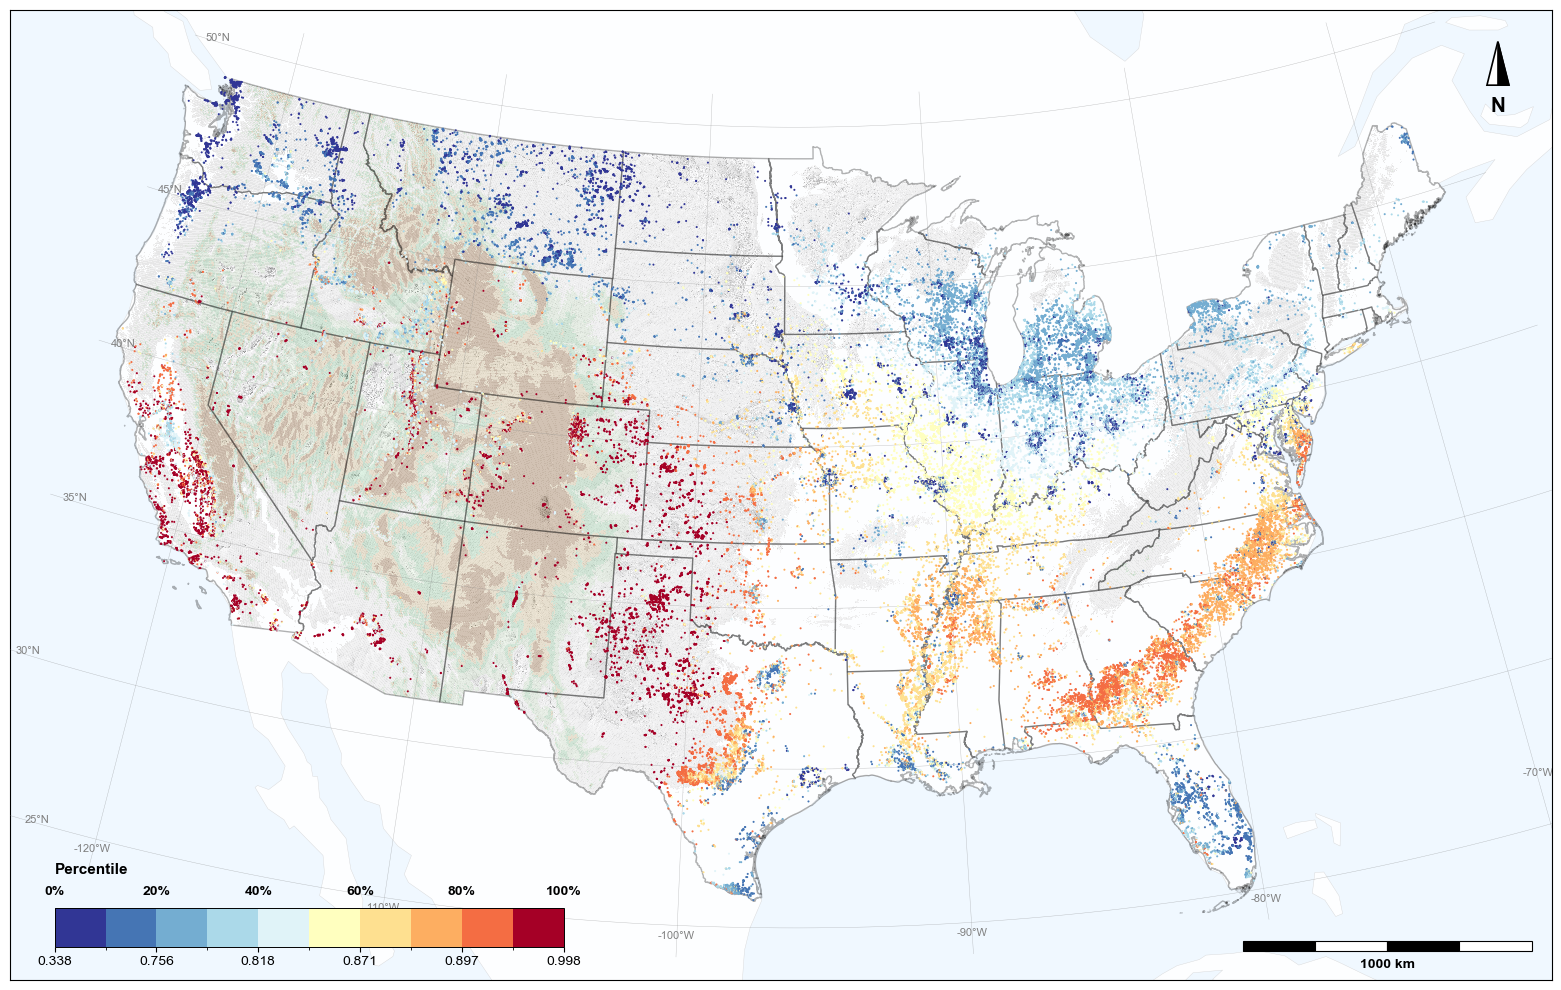

In [9]:
from matplotlib_scalebar.scalebar import ScaleBar

def plot_ccd_optimized_global_style_with_dem_line(pixel_optimized_data, us_states_gdf, dem_data):
    """Plot CCD optimized results with DEM hillshade and professional map style (with scalebar and north arrow)"""
    import matplotlib.pyplot as plt
    import geopandas as gpd
    import numpy as np
    from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
    from pyproj import Transformer
    from shapely.geometry import box
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    from matplotlib import font_manager

    # Set default font
    plt.rcParams['font.family'] = 'Arial'

    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    x_proj, y_proj = transformer.transform(pixel_optimized_data['lon'].values, pixel_optimized_data['lat'].values)
    ax.set_facecolor('#f0f8ff')

    try:
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp')
        extended_bbox = box(usa_bounds_main['lon_min'] - 5, usa_bounds_main['lat_min'] - 3,
                            usa_bounds_main['lon_max'] + 5, usa_bounds_main['lat_max'] + 3)
        helper_gdf_proj = helper_gdf.to_crs(epsg=4326).clip(extended_bbox).to_crs('ESRI:102003')
        helper_gdf_proj.plot(ax=ax, color='white', edgecolor='lightgray', linewidth=0.3, alpha=0.9)
    except Exception as e:
        print(f"Helper map error: {e}")

    # DEM + hillshade
    dem_lon = dem_data.x.values
    dem_lat = dem_data.y.values
    lon_mask = (dem_lon >= usa_bounds_main['lon_min']) & (dem_lon <= usa_bounds_main['lon_max'])
    lat_mask = (dem_lat >= usa_bounds_main['lat_min']) & (dem_lat <= usa_bounds_main['lat_max'])
    lon_indices = np.where(lon_mask)[0]
    lat_indices = np.where(lat_mask)[0]

    if len(lon_indices) > 0 and len(lat_indices) > 0:
        step = max(1, len(lon_indices) // 200000)
        lon_subset = lon_indices[::step]
        lat_subset = lat_indices[::step]
        elev_subset = dem_data.squeeze().values[np.ix_(lat_subset, lon_subset)]
        valid_mask = ~np.isnan(elev_subset)
        valid_elev = elev_subset[valid_mask]

        if valid_elev.size > 0:
            low_elev_threshold = np.percentile(valid_elev, 40)
            elev_masked = elev_subset.copy()
            elev_masked[elev_subset < low_elev_threshold] = np.nan
            valid_elev_masked = elev_masked[~np.isnan(elev_masked)]
            if valid_elev_masked.size > 0:
                def generate_hillshade(elevation_array, azimuth=315, altitude=45):
                    elev_filled = np.where(np.isnan(elevation_array), 0, elevation_array)
                    dy, dx = np.gradient(elev_filled)
                    slope = np.arctan(np.sqrt(dx**2 + dy**2))
                    aspect = np.arctan2(-dx, dy)
                    azimuth_rad = np.radians(azimuth)
                    altitude_rad = np.radians(altitude)
                    hillshade = (np.sin(altitude_rad) * np.sin(slope) +
                                 np.cos(altitude_rad) * np.cos(slope) *
                                 np.cos(azimuth_rad - aspect))
                    hillshade = (hillshade + 1) / 2
                    hillshade[np.isnan(elevation_array)] = np.nan
                    return hillshade

                hillshade = generate_hillshade(elev_masked, azimuth=315, altitude=45)
                terrain_colors = ListedColormap(["#ffffff", "#ffffff", "#e0f3db", "#a8ddb5",
                                                 "#e6cfa1", "#c9a86b", "#a97c50"])
                percentiles = np.percentile(valid_elev_masked, [30, 45, 60, 70, 80, 90, 100])
                norm = BoundaryNorm(percentiles, terrain_colors.N)
                lon_grid, lat_grid = np.meshgrid(dem_lon[lon_subset], dem_lat[lat_subset])
                dem_x_proj, dem_y_proj = transformer.transform(lon_grid.flatten(), lat_grid.flatten())
                dem_x_proj = dem_x_proj.reshape(lon_grid.shape)
                dem_y_proj = dem_y_proj.reshape(lat_grid.shape)
                ax.pcolormesh(dem_x_proj, dem_y_proj, elev_masked, cmap=terrain_colors, norm=norm,
                              alpha=0.5, zorder=1)
                ax.pcolormesh(dem_x_proj, dem_y_proj, hillshade, cmap='gray', alpha=0.3, zorder=2)


     # --- Map border ---
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds
    mx, my = (xmax - xmin) * 0.08, (ymax - ymin) * 0.08
    ax.set_xlim(xmin - mx, xmax + mx)
    ax.set_ylim(ymin - my, ymax + my)
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', alpha=0.3, zorder=3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    
    # --- Graticule ---
    lon_ticks = np.arange(-120, -60, 10)
    lat_ticks = np.arange(25, 55, 5)
    for i, lon in enumerate(lon_ticks):
        lat_line = np.linspace(usa_bounds_main['lat_min'], usa_bounds_main['lat_max'], 100)
        lon_line = np.full_like(lat_line, lon)
        x_line, y_line = transformer.transform(lon_line, lat_line)
        ax.plot(x_line, y_line, color='gray', linewidth=0.3, alpha=0.5, zorder=4)
        # Special handling for 70°W (lon == -70)
        if lon == -70:
            label_lat = usa_bounds_main['lat_min'] + 2.5  # Move label further inside
        else:
            label_lat = usa_bounds_main['lat_min'] + 0.5
        x_label, y_label = transformer.transform([lon], [label_lat])
        ax.text(x_label[0], y_label[0], f'{lon}°W', ha='center', va='bottom',
                fontsize=8, color='gray', zorder=6, clip_on=True)

    for j, lat in enumerate(lat_ticks):
        lon_line = np.linspace(usa_bounds_main['lon_min'], usa_bounds_main['lon_max'], 100)
        lat_line = np.full_like(lon_line, lat)
        x_line, y_line = transformer.transform(lon_line, lat_line)
        ax.plot(x_line, y_line, color='gray', linewidth=0.3, alpha=0.5, zorder=4)
        # Special handling for 25°N (lat == 25)
        if lat == 25:
            label_lon = usa_bounds_main['lon_min'] + 2.5  # Move label further inside
        else:
            label_lon = usa_bounds_main['lon_min'] + 0.5
        x_label, y_label = transformer.transform([label_lon], [lat])
        ax.text(x_label[0], y_label[0], f'{lat}°N', ha='left', va='center',
                fontsize=8, color='gray', zorder=6, clip_on=True)
    # CCD scatter
    ccd_values = pixel_optimized_data['ccd_optimized'].values
    diverging_colors = ['#313695', '#4575b4', '#74add1', '#abd9e9', '#e0f3f8',
                        '#ffffbf', '#fee090', '#fdae61', '#f46d43', '#d73027', '#a50026']
    ccd_cmap = LinearSegmentedColormap.from_list("ccd_diverging", diverging_colors, N=11)
    ccd_bins = np.percentile(ccd_values, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    ccd_norm = BoundaryNorm(ccd_bins, ncolors=ccd_cmap.N)
    scatter = ax.scatter(x_proj, y_proj, c=ccd_values, cmap=ccd_cmap, norm=ccd_norm,
                         s=2.2, alpha=1.0, edgecolors='none', zorder=5)

    # Colorbar
    cbar_ax = inset_axes(ax, width="33%", height="4%",
                         loc='lower left',
                         bbox_to_anchor=(0.02, 0.02, 1, 1),
                         bbox_transform=ax.transAxes, borderpad=1)
    cbar = plt.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
    cbar.set_ticks(ccd_bins[::2])
    cbar.set_ticklabels([f'{v:.3f}' for v in ccd_bins[::2]])
    cbar.ax.tick_params(labelsize=10) 
    cbar.outline.set_linewidth(0.7)
    # Add "Percentile" text above the colorbar
    cbar_ax.text(0, 1.8, "Percentile", ha='left', va='bottom', fontsize=11, fontweight='bold', transform=cbar_ax.transAxes)

    percentile_labels = [f'{p}%' for p in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100][::2]]
    for i, label in enumerate(percentile_labels):
        cbar_ax.text(i / (len(percentile_labels) - 1), 1.25, label,
                     transform=cbar_ax.transAxes, ha='center', va='bottom',
                     fontsize=10, fontweight='bold')  #

    def add_nature_north_arrow(ax, size=0.04):
        """Nature-style black and white segmented north arrow, larger for better visibility"""
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        dx, dy = x1 - x0, y1 - y0

        # 调整 north arrow 到合适的大小
        desired_size = 0.045  # 明显更大
        h = desired_size * dy
        w = h * 0.5

        cx = x0 + 0.965 * dx
        cy = y0 + 0.945 * dy

        coords = [[cx, cy + h / 2], [cx - w / 2, cy - h / 2], [cx + w / 2, cy - h / 2]]
        ax.add_patch(mpatches.Polygon(coords, closed=True, facecolor="white", edgecolor="black", lw=1.2, zorder=10))
        ax.add_patch(mpatches.Polygon([[cx, cy + h / 2], [cx, cy - h / 2], [cx + w / 2, cy - h / 2]],
                                      closed=True, facecolor="black", edgecolor="black", lw=1.2, zorder=11))

        # 加 N，字体更大，稍微远离指北针一点
        ax.text(cx, cy - h * 1.0, 'N', ha='center', va='center',
                    fontsize=15, fontweight='bold', color='black', zorder=12)

    import matplotlib.patches as mpatches

    def add_nature_scalebar(ax, length_km=500):
        """Nature-style black and white segmented scale bar"""
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        dx, dy = x1 - x0, y1 - y0

        bar_x = x0 + 0.80*dx
        bar_y = y0 + 0.03*dy
        bar_height = 0.01*dy
        bar_length = length_km * 1000  # Assume coordinate units are meters

        # 4 segments (alternating black and white)
        n_segments = 4
        seg_len = bar_length / n_segments
        for i in range(n_segments):
            color = "black" if i % 2 == 0 else "white"
            ax.add_patch(mpatches.Rectangle((bar_x + i*seg_len, bar_y),
                                            seg_len, bar_height,
                                            facecolor=color, edgecolor="black", lw=0.8))
        # Label - move text closer to the scale bar
        ax.text(bar_x + bar_length/2, bar_y - 0.008*dy,
                f"{length_km} km", ha="center", va="top",
                fontsize=10, fontweight="bold", color="black")


    # 然后在你的主函数里替换
    add_nature_north_arrow(ax, size=0.08)
    add_nature_scalebar(ax, length_km=1000)

    plt.tight_layout()
    plt.show()
    return fig, ax

fig_geo, ax = plot_ccd_optimized_global_style_with_dem_line(pixel_optimized_data, us_states_4326, dem_us)
fig_geo.savefig("figure/US_figure/ccd_optimized_with_mainland_300dpi.png", dpi=300, bbox_inches='tight')

### 5.2 不带底图绘制

C:\Users\zpy10\AppData\Local\Temp\ipykernel_161732\3080682870.py:91: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(dem_x_proj, dem_y_proj, elev_masked, cmap=terrain_colors, norm=norm,
C:\Users\zpy10\AppData\Local\Temp\ipykernel_161732\3080682870.py:93: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(dem_x_proj, dem_y_proj, hillshade, cmap='gray', alpha=0.3, zorder=2)
C:\Users\zpy10\AppData\Local\Temp\ipykernel_161732\3080682870.py:226: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tig

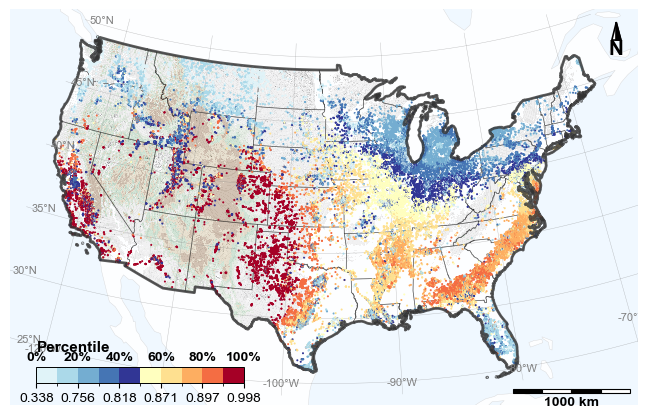

In [11]:
from matplotlib_scalebar.scalebar import ScaleBar

def plot_ccd_optimized_global_style_with_dem(pixel_optimized_data, us_states_gdf, dem_data, us_nation):
    """Plot CCD optimized results with DEM hillshade and professional map style (with scalebar and north arrow)"""
    import matplotlib.pyplot as plt
    import geopandas as gpd
    import numpy as np
    from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
    from pyproj import Transformer
    from shapely.geometry import box
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    from matplotlib import font_manager

    # Set default font
    plt.rcParams.update({
    "font.family": "Arial",
    "pdf.fonttype": 42,  # 便于期刊排版系统识别
    "ps.fonttype": 42,
    })

    # 移除 constrained_layout=True，改用 tight_layout
    fig, ax = plt.subplots(1, 1, figsize=(7.20, 4.30))
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    
    # 处理国界线
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')
    
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    x_proj, y_proj = transformer.transform(pixel_optimized_data['lon'].values, pixel_optimized_data['lat'].values)
    ax.set_facecolor('#f0f8ff')

    try:
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp')
        extended_bbox = box(usa_bounds_main['lon_min'] - 5, usa_bounds_main['lat_min'] - 3,
                            usa_bounds_main['lon_max'] + 5, usa_bounds_main['lat_max'] + 3)
        helper_gdf_proj = helper_gdf.to_crs(epsg=4326).clip(extended_bbox).to_crs('ESRI:102003')
        helper_gdf_proj.plot(ax=ax, color='white', edgecolor='lightgray', linewidth=0.3, alpha=0.9)
    except Exception as e:
        print(f"Helper map error: {e}")

    # DEM + hillshade
    dem_lon = dem_data.x.values
    dem_lat = dem_data.y.values
    lon_mask = (dem_lon >= usa_bounds_main['lon_min']) & (dem_lon <= usa_bounds_main['lon_max'])
    lat_mask = (dem_lat >= usa_bounds_main['lat_min']) & (dem_lat <= usa_bounds_main['lat_max'])
    lon_indices = np.where(lon_mask)[0]
    lat_indices = np.where(lat_mask)[0]

    if len(lon_indices) > 0 and len(lat_indices) > 0:
        step = max(1, len(lon_indices) // 200000)
        lon_subset = lon_indices[::step]
        lat_subset = lat_indices[::step]
        elev_subset = dem_data.squeeze().values[np.ix_(lat_subset, lon_subset)]
        valid_mask = ~np.isnan(elev_subset)
        valid_elev = elev_subset[valid_mask]

        if valid_elev.size > 0:
            low_elev_threshold = np.percentile(valid_elev, 40)
            elev_masked = elev_subset.copy()
            elev_masked[elev_subset < low_elev_threshold] = np.nan
            valid_elev_masked = elev_masked[~np.isnan(elev_masked)]
            if valid_elev_masked.size > 0:
                def generate_hillshade(elevation_array, azimuth=315, altitude=45):
                    elev_filled = np.where(np.isnan(elevation_array), 0, elevation_array)
                    dy, dx = np.gradient(elev_filled)
                    slope = np.arctan(np.sqrt(dx**2 + dy**2))
                    aspect = np.arctan2(-dx, dy)
                    azimuth_rad = np.radians(azimuth)
                    altitude_rad = np.radians(altitude)
                    hillshade = (np.sin(altitude_rad) * np.sin(slope) +
                                 np.cos(altitude_rad) * np.cos(slope) *
                                 np.cos(azimuth_rad - aspect))
                    hillshade = (hillshade + 1) / 2
                    hillshade[np.isnan(elevation_array)] = np.nan
                    return hillshade

                hillshade = generate_hillshade(elev_masked, azimuth=315, altitude=45)
                terrain_colors = ListedColormap(["#ffffff", "#ffffff", "#e0f3db", "#a8ddb5",
                                                 "#e6cfa1", "#c9a86b", "#a97c50"])
                percentiles = np.percentile(valid_elev_masked, [30, 45, 60, 70, 80, 90, 100])
                norm = BoundaryNorm(percentiles, terrain_colors.N)
                lon_grid, lat_grid = np.meshgrid(dem_lon[lon_subset], dem_lat[lat_subset])
                dem_x_proj, dem_y_proj = transformer.transform(lon_grid.flatten(), lat_grid.flatten())
                dem_x_proj = dem_x_proj.reshape(lon_grid.shape)
                dem_y_proj = dem_y_proj.reshape(lat_grid.shape)
                ax.pcolormesh(dem_x_proj, dem_y_proj, elev_masked, cmap=terrain_colors, norm=norm,
                              alpha=0.5, zorder=1)
                ax.pcolormesh(dem_x_proj, dem_y_proj, hillshade, cmap='gray', alpha=0.3, zorder=2)

    # --- Map border ---
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds
    mx, my = (xmax - xmin) * 0.08, (ymax - ymin) * 0.08
    ax.set_xlim(xmin - mx, xmax + mx)
    ax.set_ylim(ymin - my, ymax + my)
    # Draw a bold national border line in dark gray
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5, alpha=0.4, zorder=3)
    us_nation_albers.plot(ax=ax, color='none', edgecolor='#333333', linewidth=2, alpha=0.8, zorder=6)
    # 去掉坐标轴和刻度
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    
    # 去掉数据框线
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # --- Graticule ---
    lon_ticks = np.arange(-120, -60, 10)
    lat_ticks = np.arange(25, 55, 5)
    for i, lon in enumerate(lon_ticks):
        lat_line = np.linspace(usa_bounds_main['lat_min'], usa_bounds_main['lat_max'], 100)
        lon_line = np.full_like(lat_line, lon)
        x_line, y_line = transformer.transform(lon_line, lat_line)
        ax.plot(x_line, y_line, color='gray', linewidth=0.3, alpha=0.5, zorder=4)
        # Special handling for 70°W (lon == -70)
        if lon == -70:
            label_lat = usa_bounds_main['lat_min'] + 2.5  # Move label further inside
        else:
            label_lat = usa_bounds_main['lat_min'] + 0.5
        x_label, y_label = transformer.transform([lon], [label_lat])
        ax.text(x_label[0], y_label[0], f'{lon}°W', ha='center', va='bottom',
                fontsize=8, color='gray', zorder=6, clip_on=True)

    for j, lat in enumerate(lat_ticks):
        lon_line = np.linspace(usa_bounds_main['lon_min'], usa_bounds_main['lon_max'], 100)
        lat_line = np.full_like(lon_line, lat)
        x_line, y_line = transformer.transform(lon_line, lat_line)
        ax.plot(x_line, y_line, color='gray', linewidth=0.3, alpha=0.5, zorder=4)
        # Special handling for 25°N (lat == 25)
        if lat == 25:
            label_lon = usa_bounds_main['lon_min'] + 2.5  # Move label further inside
        else:
            label_lon = usa_bounds_main['lon_min'] + 0.5
        x_label, y_label = transformer.transform([label_lon], [lat])
        ax.text(x_label[0], y_label[0], f'{lat}°N', ha='left', va='center',
                fontsize=8, color='gray', zorder=6, clip_on=True)
    
    # CCD scatter
    ccd_values = pixel_optimized_data['ccd_optimized'].values
    # 浅蓝→深蓝→深红
    diverging_colors = ['#e0f3f8', '#abd9e9', '#74add1', '#4575b4', '#313695',
                        '#ffffbf', '#fee090', '#fdae61', '#f46d43', '#d73027', '#a50026']
    ccd_cmap = LinearSegmentedColormap.from_list("ccd_diverging", diverging_colors, N=11)
    ccd_bins = np.percentile(ccd_values, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    ccd_norm = BoundaryNorm(ccd_bins, ncolors=ccd_cmap.N)
    scatter = ax.scatter(x_proj, y_proj, c=ccd_values, cmap=ccd_cmap, norm=ccd_norm,
                         s=2.2, alpha=1.0, edgecolors='none', zorder=5)

    # Colorbar
    cbar_ax = inset_axes(ax, width="33%", height="4%",
                         loc='lower left',
                         bbox_to_anchor=(0.02, 0.02, 1, 1),
                         bbox_transform=ax.transAxes, borderpad=1)
    cbar = plt.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
    cbar.set_ticks(ccd_bins[::2])
    cbar.set_ticklabels([f'{v:.3f}' for v in ccd_bins[::2]])
    cbar.ax.tick_params(labelsize=10) 
    cbar.outline.set_linewidth(0.7)
    cbar_ax.text(0, 1.8, "Percentile", ha='left', va='bottom', fontsize=11, fontweight='bold', transform=cbar_ax.transAxes)

    percentile_labels = [f'{p}%' for p in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100][::2]]
    for i, label in enumerate(percentile_labels):
        cbar_ax.text(i / (len(percentile_labels) - 1), 1.25, label,
                     transform=cbar_ax.transAxes, ha='center', va='bottom',
                     fontsize=10, fontweight='bold')

    def add_nature_north_arrow(ax, size=0.04):
        """Nature-style black and white segmented north arrow, larger for better visibility"""
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        dx, dy = x1 - x0, y1 - y0

        # 调整 north arrow 到合适的大小
        desired_size = 0.045  # 明显更大
        h = desired_size * dy
        w = h * 0.5

        cx = x0 + 0.965 * dx
        cy = y0 + 0.945 * dy

        coords = [[cx, cy + h / 2], [cx - w / 2, cy - h / 2], [cx + w / 2, cy - h / 2]]
        ax.add_patch(mpatches.Polygon(coords, closed=True, facecolor="white", edgecolor="black", lw=1.2, zorder=10))
        ax.add_patch(mpatches.Polygon([[cx, cy + h / 2], [cx, cy - h / 2], [cx + w / 2, cy - h / 2]],
                                      closed=True, facecolor="black", edgecolor="black", lw=1.2, zorder=11))

        # 加 N，字体更大，稍微远离指北针一点
        ax.text(cx, cy - h * 1.0, 'N', ha='center', va='center',
                    fontsize=15, fontweight='bold', color='black', zorder=12)

    import matplotlib.patches as mpatches

    def add_nature_scalebar(ax, length_km=500):
        """Nature-style black and white segmented scale bar"""
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        dx, dy = x1 - x0, y1 - y0

        bar_x = x0 + 0.80*dx
        bar_y = y0 + 0.03*dy
        bar_height = 0.01*dy
        bar_length = length_km * 1000  # Assume coordinate units are meters

        # 4 segments (alternating black and white)
        n_segments = 4
        seg_len = bar_length / n_segments
        for i in range(n_segments):
            color = "black" if i % 2 == 0 else "white"
            ax.add_patch(mpatches.Rectangle((bar_x + i*seg_len, bar_y),
                                            seg_len, bar_height,
                                            facecolor=color, edgecolor="black", lw=0.8))
        # Label - move text closer to the scale bar
        ax.text(bar_x + bar_length/2, bar_y - 0.008*dy,
                f"{length_km} km", ha="center", va="top",
                fontsize=10, fontweight="bold", color="black")

    # 添加指北针和比例尺
    add_nature_north_arrow(ax, size=0.08)
    add_nature_scalebar(ax, length_km=1000)

    # 使用 tight_layout 而不是 constrained_layout
    plt.tight_layout()
    plt.show()
    return fig, ax

# 执行绘图
fig_geo2, ax2 = plot_ccd_optimized_global_style_with_dem(df_pixel_optimized_data, us_states_4326, dem_us, us_nation)
fig_geo2.savefig("figure/US_figure/ccd_optimized_with_dem_300dpi.png", dpi=500, bbox_inches='tight')

### 5.3 PV最优路径绘制

CCD阈值 (0.14770000000000005%分位数): 0.3408
高值数据点 (1): 64886
低值数据点 (0): 96
高值比例: 99.85%
目标比例: 70.0%
边界约束数量: 30
初始路径维度: 30
纬度边界数量: 15
经度边界数量: 15
正在优化路径...
路径优化成功！

最终结果:
  路径右侧高值比例: 100.00%
  路径左侧高值比例: 99.71%
  目标比例: 70.0%
  右侧高值数据点: 32210
  左侧高值数据点: 32676


C:\Users\zpy10\AppData\Local\Temp\ipykernel_161732\3080682870.py:91: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(dem_x_proj, dem_y_proj, elev_masked, cmap=terrain_colors, norm=norm,
C:\Users\zpy10\AppData\Local\Temp\ipykernel_161732\3080682870.py:93: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(dem_x_proj, dem_y_proj, hillshade, cmap='gray', alpha=0.3, zorder=2)
C:\Users\zpy10\AppData\Local\Temp\ipykernel_161732\3080682870.py:226: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tig

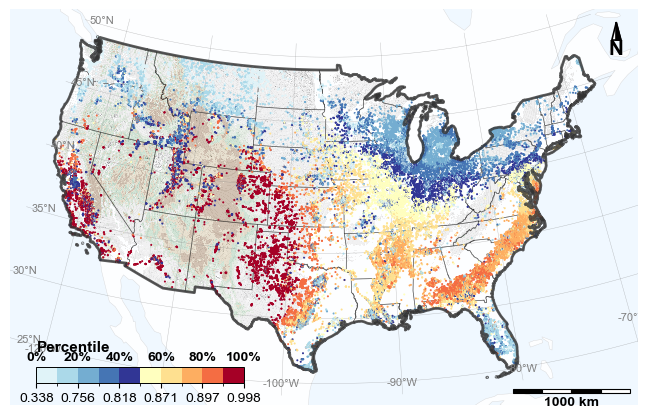

投影后的路径坐标:
  X范围: -2121424 到 1975663
  Y范围: 55973 到 642255
地图边界:
  X范围: -2725259 到 2627345
  Y范围: -1569452 到 1798021

路径坐标:
  点1: 纬度 36.000°, 经度 -120.000°
  点2: 纬度 36.357°, 经度 -118.500°
  点3: 纬度 36.714°, 经度 -114.929°
  点4: 纬度 37.071°, 经度 -111.357°
  点5: 纬度 37.429°, 经度 -107.786°
  点6: 纬度 37.786°, 经度 -104.214°
  点7: 纬度 38.143°, 经度 -100.643°
  点8: 纬度 38.500°, 经度 -97.071°
  点9: 纬度 38.857°, 经度 -93.500°
  点10: 纬度 39.214°, 经度 -89.929°
  点11: 纬度 39.571°, 经度 -86.357°
  点12: 纬度 39.929°, 经度 -82.786°
  点13: 纬度 40.286°, 经度 -79.214°
  点14: 纬度 40.643°, 经度 -75.643°
  点15: 纬度 41.000°, 经度 -72.071°

拟合直线信息:
  起点: 纬度 36.000°, 经度 -120.000°
  终点: 纬度 41.000°, 经度 -72.071°
  直线长度: 4132.7 km


<Figure size 640x480 with 0 Axes>


路径绘制检查:
  图形对象: Figure(720x430)
  坐标轴对象: Axes(0.0636772,0.0458507;0.872646x0.919266)
  路径坐标数量: 15
  坐标轴上的线条数量: 13
    线条0: X数据点 100, Y数据点 100
    线条1: X数据点 100, Y数据点 100
    线条2: X数据点 100, Y数据点 100
    线条3: X数据点 100, Y数据点 100
    线条4: X数据点 100, Y数据点 100
    线条5: X数据点 100, Y数据点 100
    线条6: X数据点 100, Y数据点 100
    线条7: X数据点 100, Y数据点 100
    线条8: X数据点 100, Y数据点 100
    线条9: X数据点 100, Y数据点 100
    线条10: X数据点 100, Y数据点 100
    线条11: X数据点 100, Y数据点 100
    线条12: X数据点 2, Y数据点 2


In [12]:
from pyproj import Transformer
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import geopandas as gpd
from pyproj import Transformer


def find_optimal_path_binary_ccd_distribution(pixel_optimized_data, us_states_gdf, dem_data, us_nation, 
                                            n_points=10, ccd_threshold_percentile=30, target_ratio=0.7,
                                            lat_direction='decreasing', lon_direction='decreasing',
                                            custom_start_lat=None, custom_end_lat=None,
                                            target_side='right'): 
    """
    基于CCD二值化分布的最优路径算法
    新增参数：
    - custom_start_lat: 自定义起点纬度
    - custom_end_lat: 自定义终点纬度
    """
    
    # 获取CCD数据
    ccd_values = pixel_optimized_data['ccd_optimized'].values
    lats = pixel_optimized_data['lat'].values
    lons = pixel_optimized_data['lon'].values
    
    # 计算CCD阈值并二值化
    ccd_threshold = np.percentile(ccd_values, ccd_threshold_percentile)
    high_ccd_binary = (ccd_values >= ccd_threshold).astype(int)  # 1表示高值，0表示低值
    
    print(f"CCD阈值 ({ccd_threshold_percentile}%分位数): {ccd_threshold:.4f}")
    print(f"高值数据点 (1): {np.sum(high_ccd_binary)}")
    print(f"低值数据点 (0): {np.sum(1 - high_ccd_binary)}")
    print(f"高值比例: {np.mean(high_ccd_binary):.2%}")
    print(f"目标比例: {target_ratio:.1%}")


    def objective_function(path_points):
        """目标函数：路径指定侧的高值数据比例接近target_ratio"""
        path_lats = path_points[:n_points]
        path_lons = path_points[n_points:]
        
        # 计算路径上的采样点
        path_coords = np.column_stack([path_lons, path_lats])
        
        # 计算所有数据点到路径的距离
        all_coords = np.column_stack([lons, lats])
        distances_to_path = cdist(all_coords, path_coords, metric='euclidean').min(axis=1)
        
        # 定义路径的"左侧"和"右侧"
        # 使用路径方向向量来确定左右
        if len(path_coords) > 1:
            # 计算路径的主要方向向量
            path_direction = path_coords[-1] - path_coords[0]
            path_direction = path_direction / np.linalg.norm(path_direction)
            
            # 计算每个数据点到路径起点的向量
            vectors_to_path = all_coords - path_coords[0]
            
            # 计算每个数据点在路径的哪一侧（使用叉积）
            # 正值表示在路径"左侧"，负值表示在"右侧"
            cross_products = np.cross(path_direction, vectors_to_path)
            
            # 定义左侧和右侧
            left_side_mask = cross_products > 0
            right_side_mask = cross_products <= 0
            
            # 根据目标侧选择计算比例
            if target_side == 'right':
                # 目标是右侧包含更多高值点
                target_side_mask = right_side_mask
                target_side_high_ratio = np.mean(high_ccd_binary[right_side_mask])
                other_side_high_ratio = np.mean(high_ccd_binary[left_side_mask])
            else:
                # 目标是左侧包含更多高值点（默认）
                target_side_mask = left_side_mask
                target_side_high_ratio = np.mean(high_ccd_binary[left_side_mask])
                other_side_high_ratio = np.mean(high_ccd_binary[right_side_mask])
            
            # 目标：指定侧高值比例接近target_ratio
            ratio_error = abs(target_side_high_ratio - target_ratio)
            
            # 方向性约束惩罚
            direction_penalty = 0
            
            # 纬度单调性约束
            if lat_direction == 'decreasing':
                lat_violations = np.sum(np.maximum(0, np.diff(path_lats)))
                direction_penalty += lat_violations * 50
            elif lat_direction == 'increasing':
                lat_violations = np.sum(np.maximum(0, -np.diff(path_lats)))
                direction_penalty += lat_violations * 50
            
            # 经度单调性约束
            if lon_direction == 'decreasing':
                lon_violations = np.sum(np.maximum(0, np.diff(path_lons)))
                direction_penalty += lon_violations * 50
            elif lon_direction == 'increasing':
                lon_violations = np.sum(np.maximum(0, -np.diff(path_lons)))
                direction_penalty += lon_violations * 50
            
            # 目标：最小化比例误差和方向性惩罚
            return ratio_error + direction_penalty
        else:
            return 1.0  # 如果路径点不足，返回大的惩罚值
    if custom_start_lat is not None and custom_end_lat is not None:
        # 使用自定义的起点和终点纬度
        start_lat = custom_start_lat
        end_lat = custom_end_lat
    else:
        # 默认设置：更关注35°N附近的高值区域
        if lat_direction == 'decreasing':
            start_lat, end_lat = 38, 30  # 从38°N到30°N，更好地覆盖35°N区域
        else:
            start_lat, end_lat = 30, 38  # 从30°N到38°N
    
    if lat_direction == 'decreasing':
        initial_lats = np.linspace(start_lat, end_lat, n_points)
    else:
        initial_lats = np.linspace(start_lat, end_lat, n_points)
    
    if lon_direction == 'decreasing':
        initial_lons = np.linspace(-70, -120, n_points)
    else:
        initial_lons = np.linspace(-120, -70, n_points)
    
    initial_path = np.concatenate([initial_lats, initial_lons])
    
    # 设置边界约束（相应调整）
    bounds = []
    
    # 纬度边界（前n_points个元素）
    for i in range(n_points):
        if lat_direction == 'decreasing':
            if i == 0:
                bounds.append((min(start_lat, end_lat), max(start_lat, end_lat)))
            else:
                min_lat = max(min(start_lat, end_lat), initial_lats[i-1] - 1.5)
                bounds.append((min_lat, max(start_lat, end_lat)))
        else:
            if i == 0:
                bounds.append((min(start_lat, end_lat), max(start_lat, end_lat)))
            else:
                max_lat = min(max(start_lat, end_lat), initial_lats[i-1] + 1.5)
                bounds.append((min(start_lat, end_lat), max_lat))
    
    # 经度边界（后n_points个元素）
    for i in range(n_points):
        if lon_direction == 'decreasing':
            if i == 0:
                bounds.append((-120, -70))
            else:
                min_lon = max(-120, initial_lons[i-1] - 1.5)
                bounds.append((min_lon, -70))
        else:
            if i == 0:
                bounds.append((-120, -70))
            else:
                max_lon = min(-70, initial_lons[i-1] + 1.5)
                bounds.append((-120, max_lon))
    
    # 验证边界数量
    print(f"边界约束数量: {len(bounds)}")
    print(f"初始路径维度: {len(initial_path)}")
    print(f"纬度边界数量: {n_points}")
    print(f"经度边界数量: {n_points}")
    
    # 优化路径
    print("正在优化路径...")
    result = minimize(objective_function, initial_path, method='L-BFGS-B', 
                     bounds=bounds, options={'maxiter': 1000, 'disp': False})
    
    if result.success:
        print("路径优化成功！")
        optimal_lats = result.x[:n_points]
        optimal_lons = result.x[n_points:]
        
        # 计算最终结果
        path_coords = np.column_stack([optimal_lons, optimal_lats])
        all_coords = np.column_stack([lons, lats])
        
        # 计算路径方向向量
        path_direction = path_coords[-1] - path_coords[0]
        path_direction = path_direction / np.linalg.norm(path_direction)
        
        # 计算每个数据点在路径的哪一侧
        vectors_to_path = all_coords - path_coords[0]
        cross_products = np.cross(path_direction, vectors_to_path)
        left_side_mask = cross_products > 0
        right_side_mask = cross_products <= 0
        
        # 计算左右两侧的高值比例
        left_side_high_ratio = np.mean(high_ccd_binary[left_side_mask])
        right_side_high_ratio = np.mean(high_ccd_binary[right_side_mask])
        
        # 根据目标侧选择显示信息
        if target_side == 'right':
            target_side_name = "右侧"
            target_side_ratio = right_side_high_ratio
            target_side_mask = right_side_mask  # 定义target_side_mask
            other_side_name = "左侧"
            other_side_ratio = left_side_high_ratio
            other_side_mask = left_side_mask
        else:
            target_side_name = "左侧"
            target_side_ratio = left_side_high_ratio
            target_side_mask = left_side_mask  # 定义target_side_mask
            other_side_name = "右侧"
            other_side_ratio = right_side_high_ratio
            other_side_mask = right_side_mask
        
        print(f"\n最终结果:")
        print(f"  路径{target_side_name}高值比例: {target_side_ratio:.2%}")
        print(f"  路径{other_side_name}高值比例: {other_side_ratio:.2%}")
        print(f"  目标比例: {target_ratio:.1%}")
        print(f"  {target_side_name}高值数据点: {np.sum(high_ccd_binary[target_side_mask])}")
        print(f"  {other_side_name}高值数据点: {np.sum(high_ccd_binary[other_side_mask])}")
        
        # 绘制结果
        fig, ax = plot_ccd_optimized_global_style_with_dem(pixel_optimized_data, us_states_gdf, dem_data, us_nation)
        
        # 在现有地图上添加路径的拟合直线
        transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
        path_x_proj, path_y_proj = transformer.transform(optimal_lons, optimal_lats)
        
        print(f"投影后的路径坐标:")
        print(f"  X范围: {path_x_proj.min():.0f} 到 {path_x_proj.max():.0f}")
        print(f"  Y范围: {path_y_proj.min():.0f} 到 {path_y_proj.max():.0f}")
        
        # 检查坐标是否在合理范围内
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        print(f"地图边界:")
        print(f"  X范围: {xmin:.0f} 到 {xmax:.0f}")
        print(f"  Y范围: {ymin:.0f} 到 {ymax:.0f}")
        
        # 仅绘制拟合的直线（不绘制路径本身）
        # 使用起点和终点拟合直线
        start_point = np.array([path_x_proj[0], path_y_proj[0]])
        end_point = np.array([path_x_proj[-1], path_y_proj[-1]])
        
        # 计算直线方向向量
        line_direction = end_point - start_point
        line_length = np.linalg.norm(line_direction)
        
        # 生成直线上的点（稍微延长一点）
        extension_factor = 0.1  # 延长10%
        extended_start = start_point - line_direction * extension_factor
        extended_end = end_point + line_direction * extension_factor
        
        # 绘制拟合的直线（红色虚线）
        ax.plot([extended_start[0], extended_end[0]], 
                [extended_start[1], extended_end[1]], 
                'r--', linewidth=4, alpha=0.8, zorder=19,
                label=f'Fitted Line ({target_side_name}: {target_side_ratio:.1%} high)')
        
        # # 标记路径起点和终点（更大的标记）
        # ax.plot(path_x_proj[0], path_y_proj[0], 'go', markersize=15, zorder=21, 
        #         label='Start', markeredgecolor='black', markeredgewidth=2)
        # ax.plot(path_x_proj[-1], path_y_proj[-1], 'ro', markersize=15, zorder=21, 
        #         label='End', markeredgecolor='black', markeredgewidth=2)
        
        # # 添加图例（确保可见）
        # # legend = ax.legend(loc='upper right', fontsize=12, framealpha=0.9)
        # # 设置图例的zorder
        # legend.set_zorder(25)
        
        # 显示路径坐标
        print(f"\n路径坐标:")
        for i in range(n_points):
            print(f"  点{i+1}: 纬度 {optimal_lats[i]:.3f}°, 经度 {optimal_lons[i]:.3f}°")
        
        # 显示拟合直线信息
        print(f"\n拟合直线信息:")
        print(f"  起点: 纬度 {optimal_lats[0]:.3f}°, 经度 {optimal_lons[0]:.3f}°")
        print(f"  终点: 纬度 {optimal_lats[-1]:.3f}°, 经度 {optimal_lons[-1]:.3f}°")
        print(f"  直线长度: {line_length/1000:.1f} km")
        
        # 强制刷新图形
        plt.draw()
        
        return fig, ax, optimal_lats, optimal_lons

# 使用示例：寻找路径，使得路径左侧包含约70%的高值数据
fig_optimal, ax_optimal, optimal_lats, optimal_lons = find_optimal_path_binary_ccd_distribution(
    df_pixel_optimized_data, us_states_4326, dem_us, us_nation, 
    n_points=15,                    # 路径控制点数量
    ccd_threshold_percentile= (1-0.8523),    # CCD阈值（30%分位数）
    target_ratio=0.7,               # 目标比例70%
    lat_direction='increasing',     # 纬度递增（向北）
    lon_direction='increasing',     # 经度递增（向东）
    target_side='right',             # 目标是右侧包含更多高值点
    custom_start_lat=36,
    custom_end_lat=41,
)

if fig_optimal is not None:
    # 保存图片
    fig_optimal.savefig("figure/US_figure/ccd_binary_distribution_300dpi.png", 
                        dpi=500, bbox_inches='tight')
    
    # 确保图形显示
    plt.show()
    
    # 额外检查：打印路径是否真的被绘制
    print(f"\n路径绘制检查:")
    print(f"  图形对象: {fig_optimal}")
    print(f"  坐标轴对象: {ax_optimal}")
    print(f"  路径坐标数量: {len(optimal_lats)}")
    
    # 检查坐标轴上的线条
    lines = ax_optimal.get_lines()
    print(f"  坐标轴上的线条数量: {len(lines)}")
    for i, line in enumerate(lines):
        if len(line.get_xdata()) > 0:
            print(f"    线条{i}: X数据点 {len(line.get_xdata())}, Y数据点 {len(line.get_ydata())}")

## 6、（累积效益图绘制-数据统计）

此处的图是地图的累积效应图

主要需求：根据数据的分位数，绘制撂荒耕地'ccd_optimized'分位数变化绘制三个维度的accumulative benefit，生成三张折线图，每个折线图要求像Nature Climate Change\ Nature Communication 2023年之后发表期刊的图表一样

计算逻辑：要求随着ccd分数的递增遍历各个pixel，sum up : pixel_optimized_data['env_scores'], pixel_optimized_data['Expectation_net_benefit'], pixel_optimized_data['avg_npv']，

在每个图中，要求绘制根据曲率计算出的切线，以说明这个数据变化最剧烈对应的CCD值。并且以这个CCD为点，在x轴上绘制一个confidence区间（让决策者注意处理这段数据）

数据申明：

根据以下数据的分位数
ccd_values = pixel_optimized_data['ccd_optimized'].values
ccd_bins = np.percentile(ccd_values, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

除了pixel_optimized_data['env_scores']是没有量纲，其余都是USD/ha；Mg C/ha的密度单位



us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')

### 6.1（最终：组合图1-带州的数据）

Environmental Scores TOP5州: ['Texas', 'Illinois', 'Indiana', 'Georgia', 'Michigan']
Carbon Mitigation TOP5州: ['Texas', 'California', 'Illinois', 'Georgia', 'Indiana']
Economic NPV TOP5州: ['California', 'Texas', 'Colorado', 'Utah', 'Idaho']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


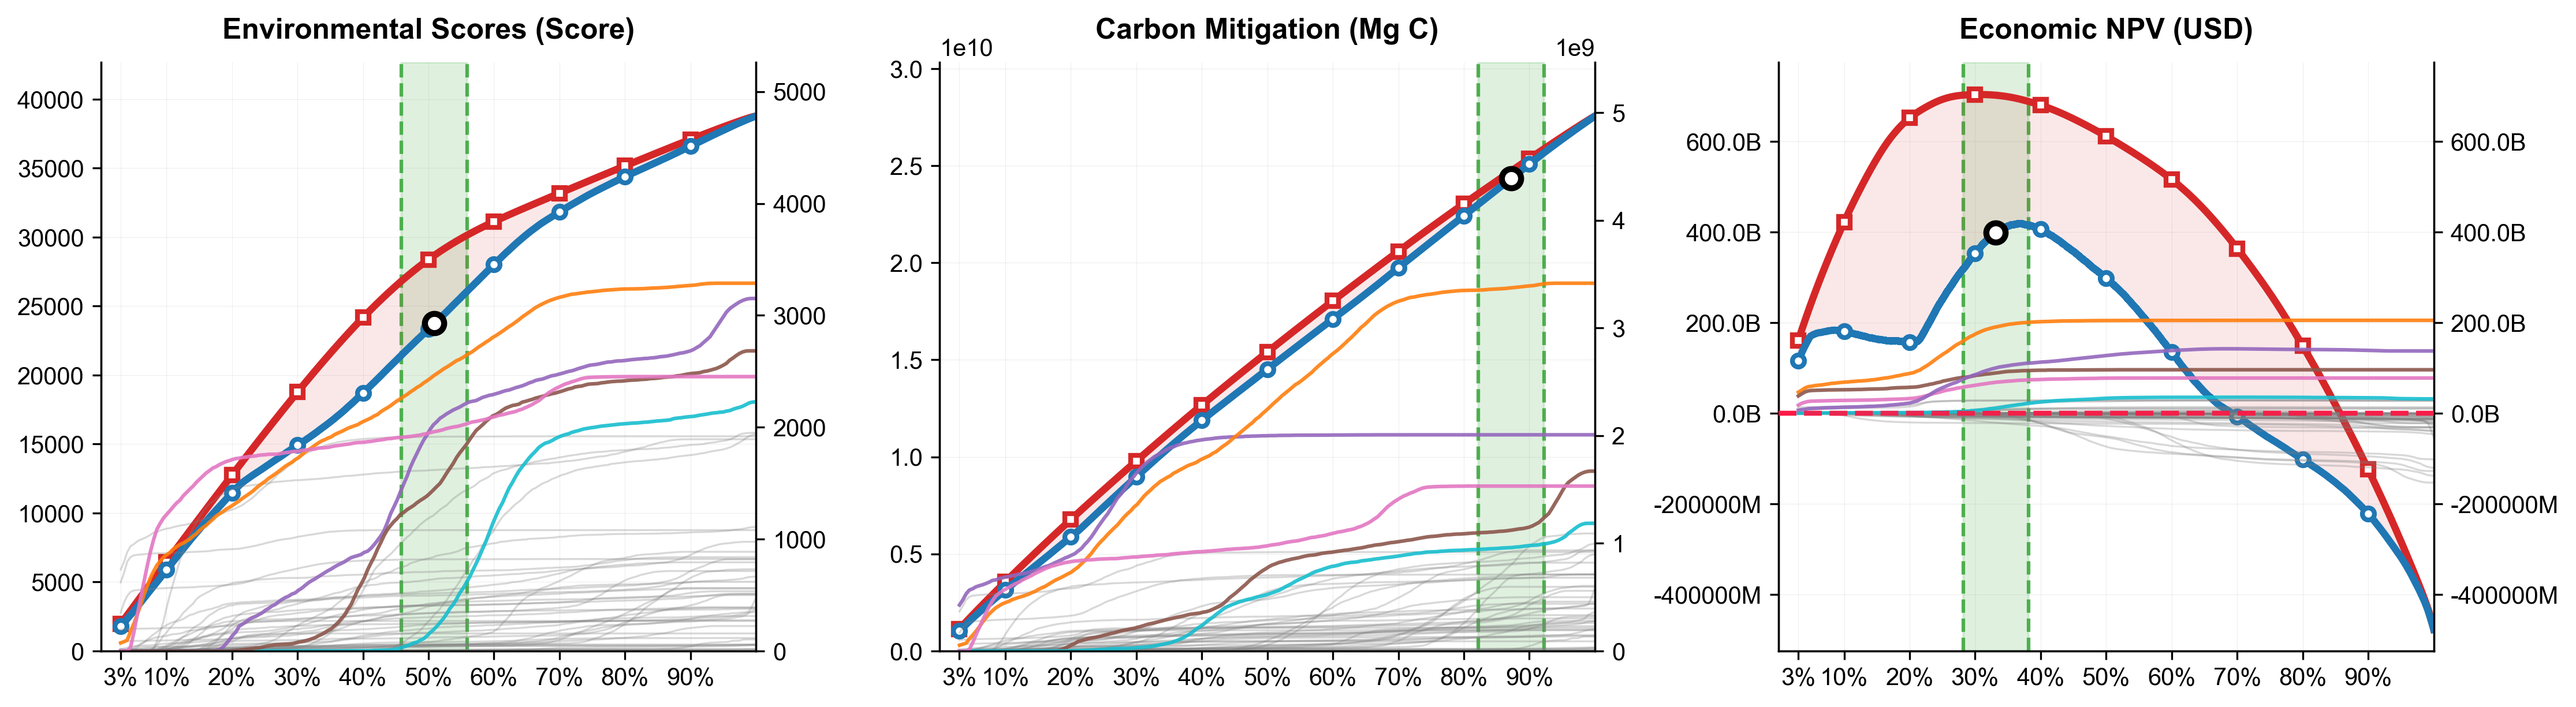

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


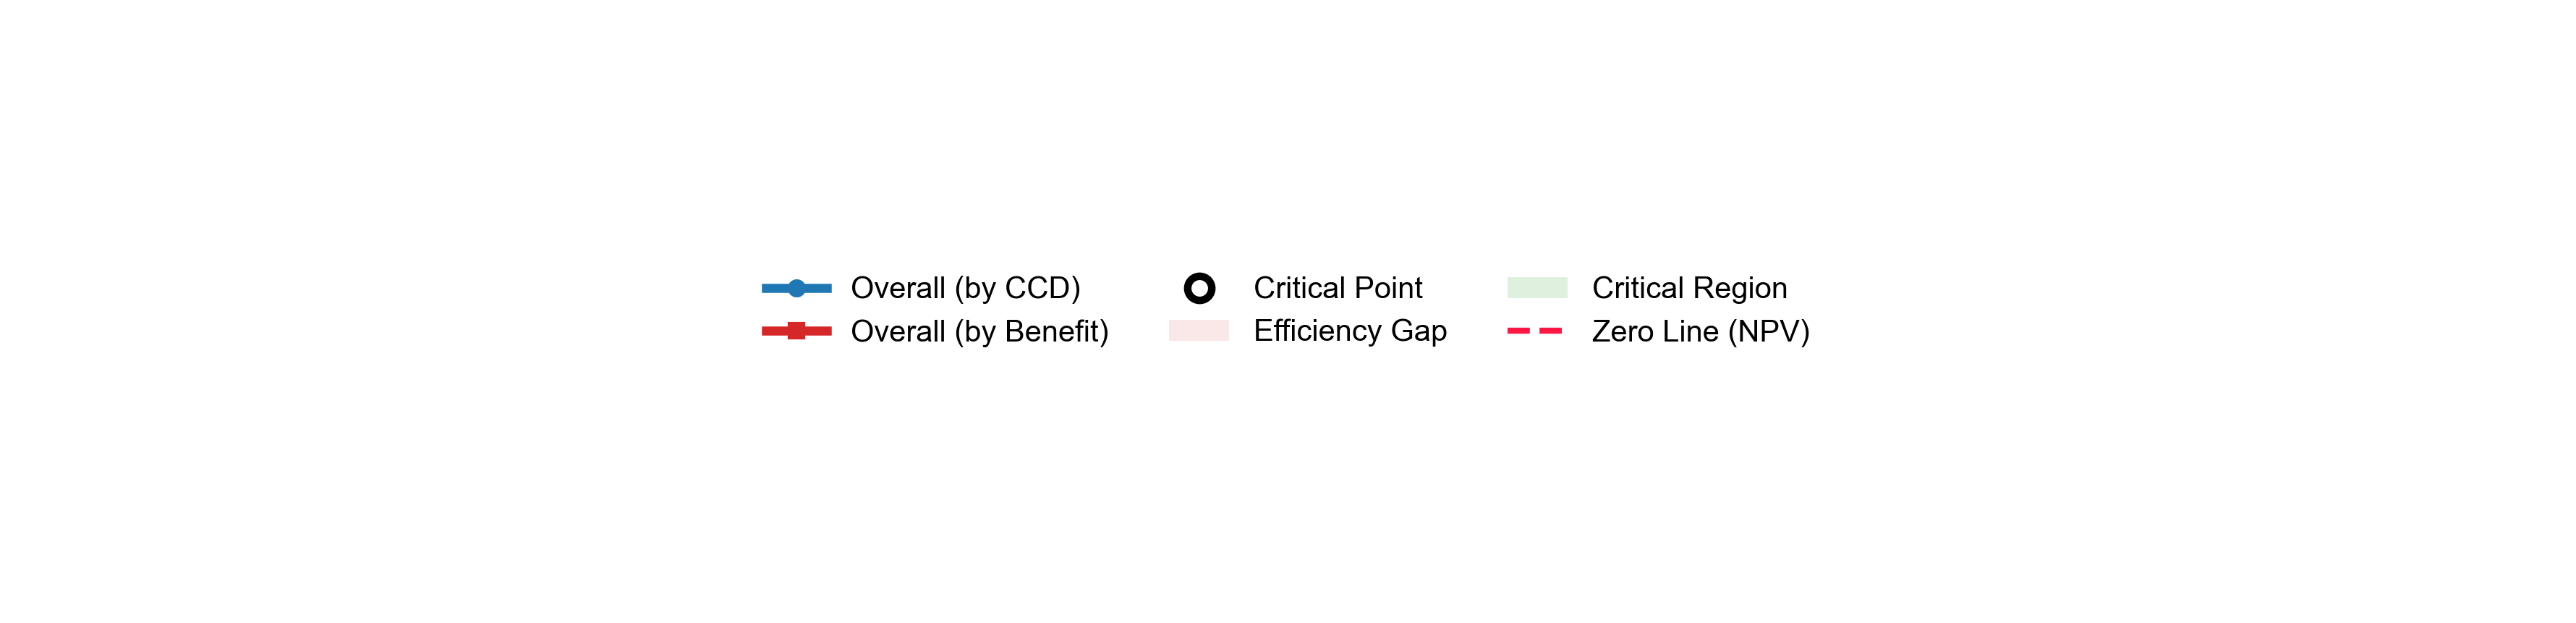

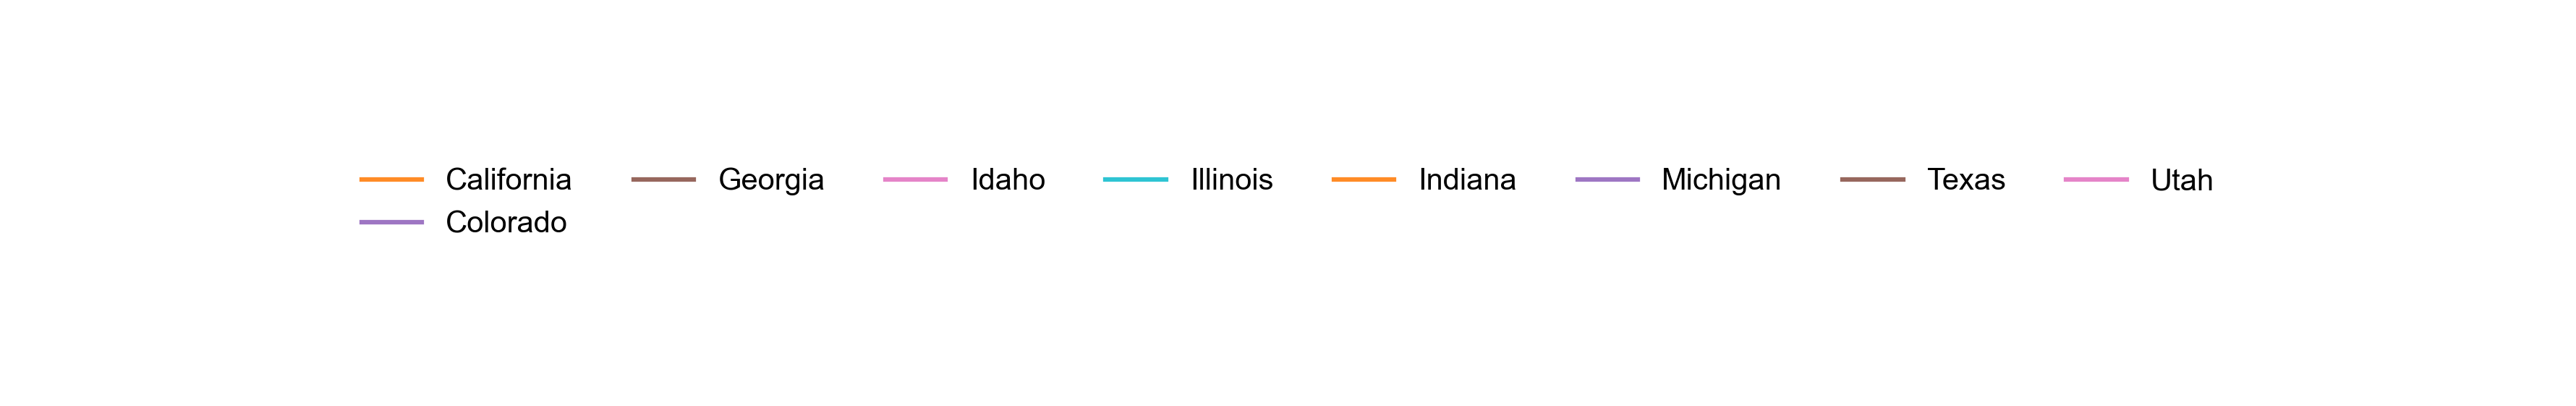

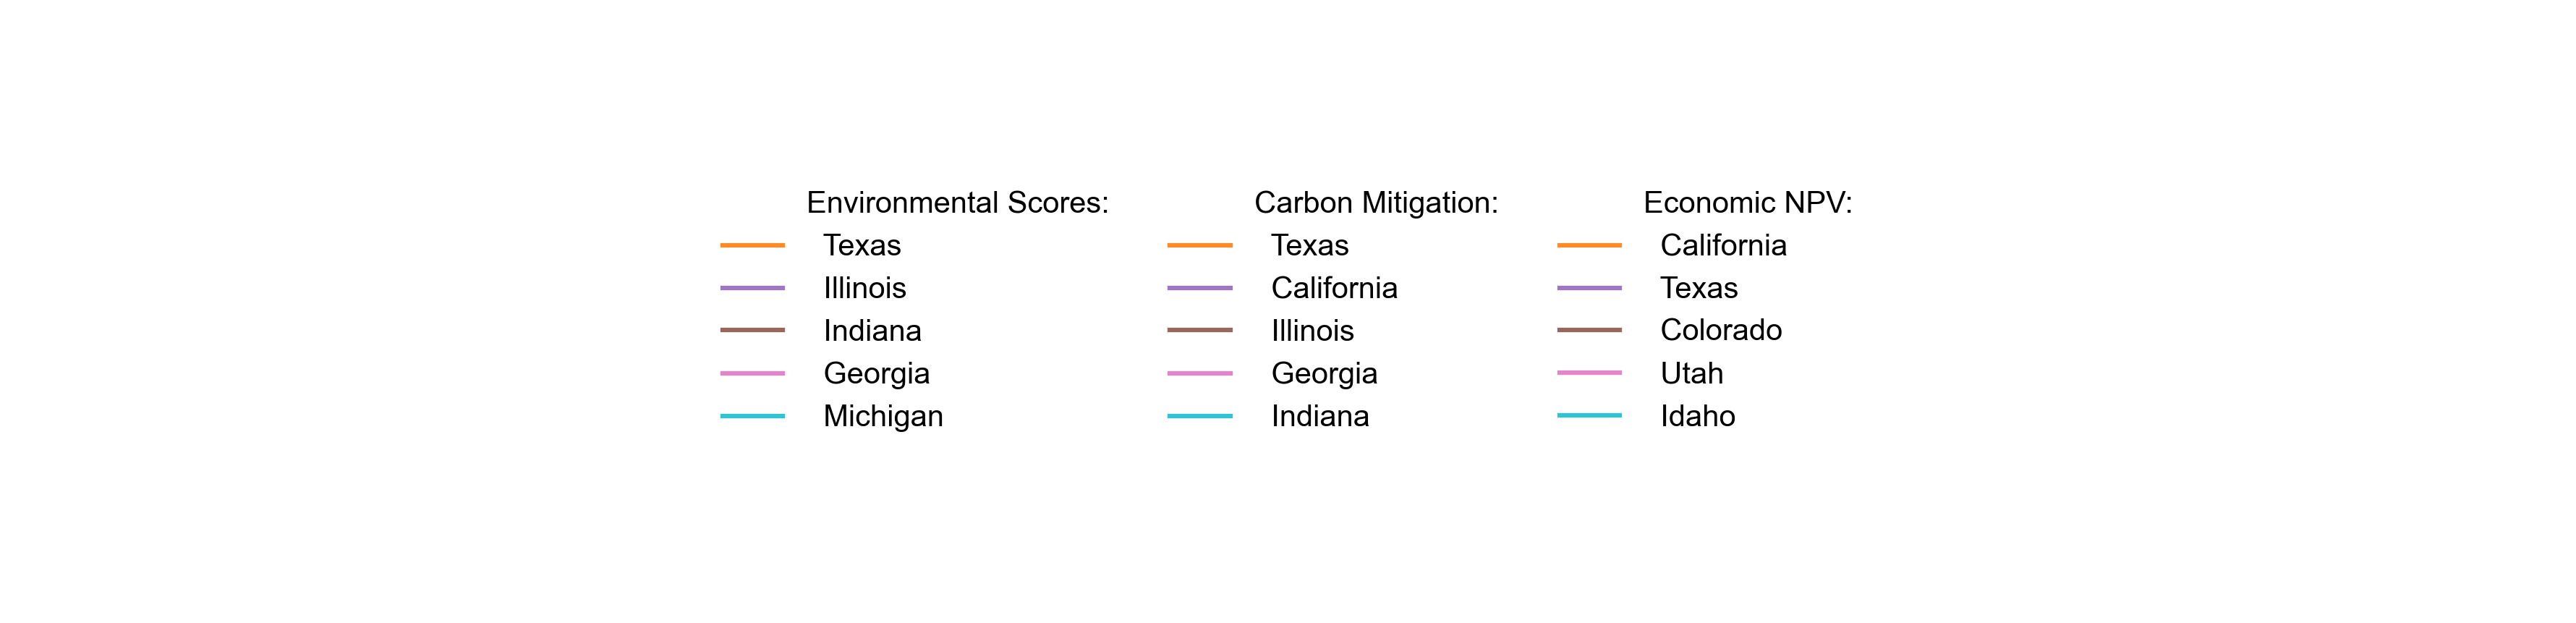

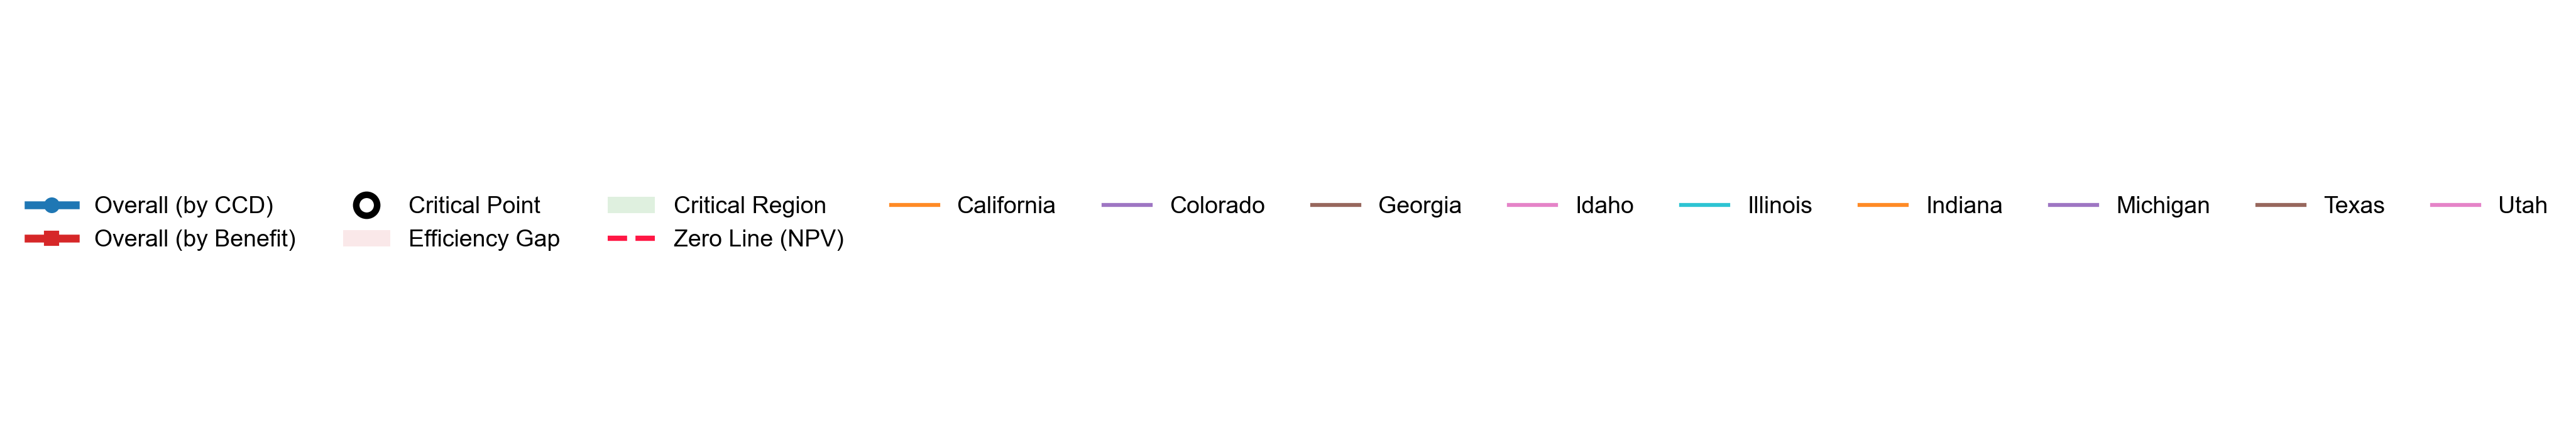

整合图和图例创建完成！
保存的文件：
1. 主图：Figure4_combined_cumulative_analysis.eps/png
2. 总体图例：Figure4_overall_legend.eps/png
3. 紧凑州图例：Figure4_compact_states_legend.eps/png
4. 分类州图例：Figure4_categorized_states_legend.eps/png
5. 完整图例：Figure4_complete_legend.eps/png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
from matplotlib.ticker import FuncFormatter
import os

# Nature期刊标准设置 - 增大字体
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 11,  # 从9增加到11
    'axes.linewidth': 0.8,  # 从0.6增加到0.8
    'axes.labelsize': 12,  # 从10增加到12
    'xtick.labelsize': 10,  # 从8增加到10
    'ytick.labelsize': 10,  # 从8增加到10
    'legend.fontsize': 10,  # 从8增加到10
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

def create_combined_cumulative_analysis(pixel_optimized_data, us_states_4326, df_net_benefit):
    """
    创建A4布局的累积分析图，整合三个累积曲线 - Nature风格配色，使用面积乘以密度计算总累积效应
    """
    
    # 创建1行3列的布局
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))  # 压缩Y轴高度
    
    # 定义三个变量
    variables = [
        ('predicted_prob', 'Environmental Scores', 'Score'),
        ('Expectation_net_benefit', 'Carbon Mitigation', 'Mg C'),
        ('avg_npv', 'Economic NPV', 'USD')
    ]
    
    # Nature风格配色方案 - 与地图配色协调
    # 主曲线颜色（更鲜艳，突出）
    main_colors = {
        'ccd': '#1f77b4',      # 深蓝色 - 与地图蓝色呼应
        'benefit': '#d62728',   # 深红色 - 与地图红色呼应
        'critical': '#2ca02c'   # 深绿色 - 突出关键点
    }
    
    # TOP5州颜色 - 与地图配色协调的鲜艳色彩
    top_state_colors = [
        '#ff7f0e',  # 橙色 - 与地图橙色呼应
        '#9467bd',  # 紫色 - 与地图紫色呼应  
        '#8c564b',  # 棕色 - 与地图棕色呼应
        '#e377c2',  # 粉色 - 与地图粉色呼应
        '#17becf'   # 青色 - 与地图青色呼应
    ]
    
    other_state_color = '#7f7f7f'  # 中性灰色
    
    # 存储每个变量的TOP5州
    all_top_states = {}
    
    for idx, (variable_name, variable_label, unit) in enumerate(variables):
        # 创建双Y轴
        ax1 = axes[idx]
        ax2 = ax1.twinx()
        
        # 去除顶部边框
        ax1.spines['top'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        
        # ==================== 数据准备 ====================
        ccd_values_total = pixel_optimized_data['ccd_optimized'].values
        benefit_density_values = pixel_optimized_data[variable_name].values  # 密度值
        
        # 获取面积数据并转换为公顷
        area_values = df_net_benefit['area_m2'].values / 10000  # 转换为公顷
        
        # 计算总效益值（密度 × 面积）
        if variable_name == 'predicted_prob':
            # 环境分数不需要乘以面积，直接使用原始值
            benefit_total_values = benefit_density_values
        else:
            # 碳减排和NPV需要乘以面积
            benefit_total_values = benefit_density_values * area_values
        
        # 特殊处理NPV数据（保留负值）
        if variable_name == 'avg_npv':
            benefit_total_values = benefit_total_values.copy()  # 保留负值
        
        # 创建精细分位数区间
        fine_ccd_percentiles = np.arange(100, -0.5, -0.5)
        fine_ccd_bins = np.percentile(ccd_values_total, fine_ccd_percentiles)
        
        # ==================== 按CCD排序的累积效应曲线 ====================
        ccd_sorted_indices = np.argsort(ccd_values_total)[::-1]
        ccd_sorted_benefits = benefit_total_values[ccd_sorted_indices]
        ccd_cumulative_benefits = np.cumsum(ccd_sorted_benefits)
        ccd_cumulative_percentage = np.arange(1, len(ccd_cumulative_benefits) + 1) / len(ccd_cumulative_benefits) * 100
        
        # 确保从0开始
        ccd_cumulative_benefits = np.concatenate([[0], ccd_cumulative_benefits])
        ccd_cumulative_percentage = np.concatenate([[0], ccd_cumulative_percentage])
        
        # ==================== 按效益排序的累积效应曲线 ====================
        benefit_sorted_indices = np.argsort(benefit_total_values)[::-1]
        benefit_sorted_benefits = benefit_total_values[benefit_sorted_indices]
        benefit_cumulative_benefits = np.cumsum(benefit_sorted_benefits)
        benefit_cumulative_percentage = np.arange(1, len(benefit_cumulative_benefits) + 1) / len(benefit_cumulative_benefits) * 100
        
        # 确保从0开始
        benefit_cumulative_benefits = np.concatenate([[0], benefit_cumulative_benefits])
        benefit_cumulative_percentage = np.concatenate([[0], benefit_cumulative_percentage])
        
        # ==================== 各州数据计算 ====================
        geometry = [Point(xy) for xy in zip(pixel_optimized_data['lon'], pixel_optimized_data['lat'])]
        pixel_gdf = gpd.GeoDataFrame(pixel_optimized_data, geometry=geometry, crs='EPSG:4326')
        pixel_with_states = gpd.sjoin(pixel_gdf, us_states_4326, how='left', predicate='within')
        
        state_cumulative_data = {}
        state_total_benefits = {}
        
        for state_name in pixel_with_states['NAME'].unique():
            if pd.isna(state_name):
                continue
                
            state_mask = pixel_with_states['NAME'] == state_name
            state_data = pixel_with_states[state_mask]
            
            if len(state_data) == 0:
                continue
                
            state_ccd = state_data['ccd_optimized'].values
            state_indices = state_data.index
            state_benefit_density = benefit_density_values[state_indices]  # 密度值
            state_area = area_values[state_indices]  # 面积值
            
            # 计算州级总效益值
            if variable_name == 'predicted_prob':
                state_benefit_total = state_benefit_density
            else:
                state_benefit_total = state_benefit_density * state_area
            
            state_total_benefits[state_name] = np.sum(state_benefit_total)
            
            # 按照总体精细分位数区间来划分该州的数据
            state_cumulative_benefits = []
            
            for i in range(len(fine_ccd_bins) - 1):
                mask = (state_ccd <= fine_ccd_bins[i]) & (state_ccd >= fine_ccd_bins[i + 1])
                if np.any(mask):
                    cumulative_benefit = np.sum(state_benefit_total[mask])
                    state_cumulative_benefits.append(cumulative_benefit)
                else:
                    state_cumulative_benefits.append(0)
            
            state_cumulative_benefits = np.array(state_cumulative_benefits)
            state_cumulative_sum = np.cumsum(state_cumulative_benefits)
            state_cumulative_percentage = np.arange(len(state_cumulative_sum)) / (len(state_cumulative_sum) - 1) * 100
            
            state_cumulative_data[state_name] = {
                'cumulative_sum': state_cumulative_sum,
                'cumulative_percentage': state_cumulative_percentage,
                'data_count': len(state_data),
                'total_benefit': state_total_benefits[state_name]
            }
        
        # 选择TOP5州 - 根据当前变量的累积效益
        sorted_states = sorted(state_total_benefits.items(), key=lambda x: x[1], reverse=True)
        top_states = [state for state, _ in sorted_states[:5]]
        all_top_states[variable_name] = top_states
        
        print(f"{variable_label} TOP5州: {top_states}")
        
        # ==================== 绘制州曲线（在右Y轴） ====================
        all_states = list(state_cumulative_data.keys())
        
        for i, state_name in enumerate(all_states):
            if state_name in state_cumulative_data:
                data = state_cumulative_data[state_name]
                cumulative_sum = data['cumulative_sum']
                cumulative_percentage = data['cumulative_percentage']

                # 找到3%对应的索引
                start_idx_state = np.argmin(np.abs(cumulative_percentage - 3))
                
                # 判断是否为TOP5州
                is_top_state = state_name in top_states

                if is_top_state:
                    # TOP5州用鲜艳色彩
                    color = top_state_colors[top_states.index(state_name)]
                    ax2.plot(cumulative_percentage[start_idx_state:], cumulative_sum[start_idx_state:],
                            color=color, linewidth=1.5, alpha=0.9, zorder=2)
                else:
                    # 其他州用淡灰色
                    ax2.plot(cumulative_percentage[start_idx_state:], cumulative_sum[start_idx_state:], 
                             color=other_state_color, linewidth=0.8, alpha=0.3, zorder=1)
        
        # ==================== 绘制总体曲线（在左Y轴） ====================
        start_idx_ccd = np.argmin(np.abs(ccd_cumulative_percentage - 3))
        start_idx_benefit = np.argmin(np.abs(benefit_cumulative_percentage - 3))
        
        # 选择关键点位 - 避免3%和5%重合
        key_percentages = [3, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # 移除5%
        key_indices_ccd = []
        key_indices_benefit = []
        
        for p in key_percentages:
            idx_ccd = np.argmin(np.abs(ccd_cumulative_percentage - p))
            if idx_ccd < len(ccd_cumulative_percentage):
                key_indices_ccd.append(idx_ccd)
            
            idx_benefit = np.argmin(np.abs(benefit_cumulative_percentage - p))
            if idx_benefit < len(benefit_cumulative_percentage):
                key_indices_benefit.append(idx_benefit)
        
        # 绘制CCD曲线 - 更粗更鲜艳
        ax1.plot(ccd_cumulative_percentage[start_idx_ccd:], ccd_cumulative_benefits[start_idx_ccd:], '-', 
                color=main_colors['ccd'], linewidth=3.0, alpha=1.0, zorder=4, label='Overall (by CCD)')
        
        # 关键点marker - 更突出
        valid_key_indices_ccd = [idx for idx in key_indices_ccd if idx >= start_idx_ccd]
        if valid_key_indices_ccd:
            ax1.plot(ccd_cumulative_percentage[valid_key_indices_ccd], ccd_cumulative_benefits[valid_key_indices_ccd], 'o', 
                    color=main_colors['ccd'], markersize=5, markerfacecolor='white', markeredgewidth=2.0, 
                    markeredgecolor=main_colors['ccd'], zorder=4)
        
        # 绘制效益曲线 - 更粗更鲜艳
        ax1.plot(benefit_cumulative_percentage[start_idx_benefit:], benefit_cumulative_benefits[start_idx_benefit:], '-', 
                color=main_colors['benefit'], linewidth=3.0, alpha=1.0, zorder=3, label='Overall (by Benefit)')
        
        # 关键点marker - 更突出
        valid_key_indices_benefit = [idx for idx in key_indices_benefit if idx >= start_idx_benefit]
        if valid_key_indices_benefit:
            ax1.plot(benefit_cumulative_percentage[valid_key_indices_benefit], benefit_cumulative_benefits[valid_key_indices_benefit], 's', 
                    color=main_colors['benefit'], markersize=5, markerfacecolor='white', markeredgewidth=2.0, 
                    markeredgecolor=main_colors['benefit'], zorder=3)
        
        # 效率差异区域 - 更淡的背景
        ax1.fill_between(ccd_cumulative_percentage[start_idx_ccd:], 
                        ccd_cumulative_benefits[start_idx_ccd:], 
                        benefit_cumulative_benefits[start_idx_benefit:], 
                        alpha=0.1, color=main_colors['benefit'], zorder=2)
        
        # Critical点计算和标记
        if len(ccd_cumulative_percentage) > 2:
            dx = np.diff(ccd_cumulative_percentage)
            dy = np.diff(ccd_cumulative_benefits)
            d2y = np.diff(dy)
            
            slopes = dy[:-1] / dx[:-1]
            curvature = np.abs(d2y) / (1 + slopes**2)**1.5
            max_curvature_idx = np.argmax(curvature) + 1
            
            max_curvature_percentage = ccd_cumulative_percentage[max_curvature_idx]
            max_curvature_y = ccd_cumulative_benefits[max_curvature_idx]
            
            # Critical点 - 更突出
            ax1.plot(max_curvature_percentage, max_curvature_y, 'o', color=main_colors['critical'], markersize=8, 
                   markeredgecolor='black', markeredgewidth=2.5, zorder=5, markerfacecolor='white')
            
            # Critical区域 - 淡绿色背景
            confidence_start_percentage = max(3, max_curvature_percentage - 5)
            confidence_end_percentage = min(100, max_curvature_percentage + 5)
            
            # 使用淡绿色填充，与critical点颜色呼应
            ax1.axvspan(confidence_start_percentage, confidence_end_percentage, color=main_colors['critical'], alpha=0.15, zorder=0)
            
            # 置信区间边界线
            ax1.axvline(x=confidence_start_percentage, color=main_colors['critical'], linestyle='--', linewidth=1.5, alpha=0.8, zorder=1)
            ax1.axvline(x=confidence_end_percentage, color=main_colors['critical'], linestyle='--', linewidth=1.5, alpha=0.8, zorder=1)
        
        # 特殊处理NPV的Y=0线
        if variable_name == 'avg_npv':
            ax1.axhline(y=0, color='#FF1744', linestyle='--', linewidth=2.0, alpha=0.9, zorder=6)
            ax2.axhline(y=0, color='#FF1744', linestyle='--', linewidth=2.0, alpha=0.9, zorder=6)
        
        # 设置X轴刻度 - 避免重合，增大字体
        xtick_positions = [ccd_cumulative_percentage[i] for i in key_indices_ccd]
        xtick_labels = [f'{p}%' for p in key_percentages]
        ax1.set_xticks(xtick_positions)
        ax1.set_xticklabels(xtick_labels, ha='center', fontsize=10)  # 从7增加到10
        ax1.set_xlim(0, 100)
        
        # 设置Y轴范围
        max_state_value = max([data['cumulative_sum'].max() for data in state_cumulative_data.values()])
        max_overall_value = max(ccd_cumulative_benefits.max(), benefit_cumulative_benefits.max())
        
        if variable_name == 'avg_npv':
            min_overall_value = min(ccd_cumulative_benefits.min(), benefit_cumulative_benefits.min())
            min_state_value = min([data['cumulative_sum'].min() for data in state_cumulative_data.values()])
            
            # 对齐双Y轴
            y_min = min(min_overall_value, min_state_value) * 1.1
            y_max = max(max_overall_value, max_state_value) * 1.1

            ax1.set_ylim(y_min, y_max)
            ax2.set_ylim(y_min, y_max)
            
            # 自定义Y轴刻度格式
            def custom_y_formatter(x, pos):
                if x >= 0:
                    return f'{x/1e9:.1f}B'
                else:
                    return f'{x/1e6:.0f}M'
            
            ax1.yaxis.set_major_formatter(FuncFormatter(custom_y_formatter))
            ax2.yaxis.set_major_formatter(FuncFormatter(custom_y_formatter))
        else:
            # 左Y轴（总体）
            ax1.set_ylim(0, max_overall_value * 1.1)
            # 右Y轴（各州）
            ax2.set_ylim(0, max_state_value * 1.6)
        
        # 网格 - 更淡
        ax1.grid(True, alpha=0.2, linestyle='-', linewidth=0.3)
        ax1.set_axisbelow(True)
        
        # 刻度 - 增大字体
        ax1.tick_params(axis='both', which='major', labelsize=10, colors='black')  # 从7增加到10
        ax2.tick_params(axis='y', colors='black', labelsize=10)  # 从7增加到10
        
        # 子图标题（不加a,b,c，加单位）- 增大字体
        ax1.set_title(f'{variable_label} ({unit})', fontsize=12, fontweight='bold', pad=10)  # 从10增加到12
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    
    return fig, axes, all_top_states, main_colors, top_state_colors, variables

# 创建整合图
fig_combined, axes_combined, all_top_states, main_colors, top_state_colors, variables = create_combined_cumulative_analysis(pixel_optimized_data, us_states_4326, df_net_benefit)

# 保存主图
output_dir = 'figure/US_figure'
os.makedirs(output_dir, exist_ok=True)
fig_combined.savefig(f'{output_dir}/Figure4_combined_cumulative_analysis.eps', 
                     bbox_inches='tight', dpi=300, format='eps')
fig_combined.savefig(f'{output_dir}/Figure4_combined_cumulative_analysis.png', 
                     bbox_inches='tight', dpi=300, format='png')

plt.show()

# ==================== 创建优化的图例布局 ====================

# 1. 总体图例（包含效率差异区间和Critical关键区域）- 紧凑布局，无框线
def create_overall_legend():
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.set_xlim(0, 15)
    ax.set_ylim(0, 3)
    ax.axis('off')
    
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch

    # 总体图例元素
    legend_elements = [
        Line2D([0], [0], marker='o', color=main_colors['ccd'], markersize=5, linewidth=3.0, label='Overall (by CCD)'),
        Line2D([0], [0], marker='s', color=main_colors['benefit'], markersize=5, linewidth=3.0, label='Overall (by Benefit)'),
        Line2D([0], [0], marker='o', color=main_colors['critical'], markersize=8, markeredgecolor='black', 
               markeredgewidth=2.5, linewidth=0, label='Critical Point', markerfacecolor='white'),
        Patch(facecolor=main_colors['benefit'], alpha=0.1, label='Efficiency Gap'),
        Patch(facecolor=main_colors['critical'], alpha=0.15, label='Critical Region'),
        Line2D([0], [0], color='#FF1744', linestyle='--', linewidth=2.0, label='Zero Line (NPV)')  # 添加Y=0线
    ]

    # 一行2个，一共3行
    ax.legend(handles=legend_elements, loc='center', ncol=3, fontsize=10, 
              frameon=False, fancybox=False, shadow=False, bbox_to_anchor=(0.5, 0.5))  # ncol=3, 自动分2行

    plt.tight_layout()
    return fig

# 2. 紧凑的州图例（所有州合并，去重）- 无框线
def create_compact_states_legend():
    fig, ax = plt.subplots(figsize=(12, 2))
    ax.set_xlim(0, 15)
    ax.set_ylim(0, 2)
    ax.axis('off')
    
    from matplotlib.lines import Line2D
    
    # 收集所有唯一的州
    all_unique_states = set()
    for top_states in all_top_states.values():
        all_unique_states.update(top_states)
    
    # 按字母顺序排序
    all_unique_states = sorted(list(all_unique_states))
    
    # 州图例元素
    legend_elements = []
    for i, state_name in enumerate(all_unique_states):
        color = top_state_colors[i % len(top_state_colors)]
        legend_elements.append(
            Line2D([0], [0], marker='', color=color, linewidth=1.5, 
                   label=f'{state_name}', alpha=0.9, linestyle='-')
        )
    
    ax.legend(handles=legend_elements, loc='center', ncol=8, fontsize=10, 
              frameon=False, fancybox=False, shadow=False)  # 去掉框线
    
    plt.tight_layout()
    return fig

# 3. 分类州图例（按变量分组）- 无框线
def create_categorized_states_legend():
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.set_xlim(0, 15)
    ax.set_ylim(0, 3)
    ax.axis('off')
    
    from matplotlib.lines import Line2D
    
    # 创建分类图例
    legend_elements = []
    
    # 添加分类标题
    for i, (variable_name, (_, variable_label, _)) in enumerate(zip(['predicted_prob', 'Expectation_net_benefit', 'avg_npv'], variables)):
        # 添加分类标题（使用空行）
        legend_elements.append(
            Line2D([0], [0], marker='', color='none', linewidth=0, 
                   label=f'{variable_label}:', alpha=0)
        )
        
        # 添加该变量的TOP5州
        top_states = all_top_states[variable_name]
        for j, state_name in enumerate(top_states):
            color = top_state_colors[j]
            legend_elements.append(
                Line2D([0], [0], marker='', color=color, linewidth=1.5, 
                       label=f'  {state_name}', alpha=0.9, linestyle='-')
            )
    
    ax.legend(handles=legend_elements, loc='center', ncol=3, fontsize=10, 
              frameon=False, fancybox=False, shadow=False)  # 去掉框线
    
    plt.tight_layout()
    return fig

# 4. 完整图例（总体+紧凑州）- 无框线
def create_complete_legend():
    fig, ax = plt.subplots(figsize=(15, 2.5))
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 2.5)
    ax.axis('off')
    
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    
    # 总体图例元素
    overall_elements = [
        Line2D([0], [0], marker='o', color=main_colors['ccd'], markersize=5, linewidth=3.0, label='Overall (by CCD)'),
        Line2D([0], [0], marker='s', color=main_colors['benefit'], markersize=5, linewidth=3.0, label='Overall (by Benefit)'),
        Line2D([0], [0], marker='o', color=main_colors['critical'], markersize=8, markeredgecolor='black', 
               markeredgewidth=2.5, linewidth=0, label='Critical Point', markerfacecolor='white'),
        Patch(facecolor=main_colors['benefit'], alpha=0.1, label='Efficiency Gap'),
        Patch(facecolor=main_colors['critical'], alpha=0.15, label='Critical Region'),
        Line2D([0], [0], color='#FF1744', linestyle='--', linewidth=2.0, label='Zero Line (NPV)')  # 添加Y=0线
    ]
    
    # 收集所有唯一的州
    all_unique_states = set()
    for top_states in all_top_states.values():
        all_unique_states.update(top_states)
    all_unique_states = sorted(list(all_unique_states))
    
    # 州图例元素
    state_elements = []
    for i, state_name in enumerate(all_unique_states):
        color = top_state_colors[i % len(top_state_colors)]
        state_elements.append(
            Line2D([0], [0], marker='', color=color, linewidth=1.5, 
                   label=f'{state_name}', alpha=0.9, linestyle='-')
        )
    
    # 合并所有图例元素
    all_elements = overall_elements + state_elements
    
    ax.legend(handles=all_elements, loc='center', ncol=12, fontsize=9, 
              frameon=False, fancybox=False, shadow=False)  # 去掉框线
    
    plt.tight_layout()
    return fig

# 创建并保存图例
fig_overall_legend = create_overall_legend()
fig_compact_states_legend = create_compact_states_legend()
fig_categorized_states_legend = create_categorized_states_legend()
fig_complete_legend = create_complete_legend()

# 保存图例
fig_overall_legend.savefig(f'{output_dir}/Figure4_overall_legend.eps', 
                          bbox_inches='tight', dpi=300, format='eps')
fig_overall_legend.savefig(f'{output_dir}/Figure4_overall_legend.png', 
                          bbox_inches='tight', dpi=300, format='png')

fig_compact_states_legend.savefig(f'{output_dir}/Figure4_compact_states_legend.eps', 
                                 bbox_inches='tight', dpi=300, format='eps')
fig_compact_states_legend.savefig(f'{output_dir}/Figure4_compact_states_legend.png', 
                                 bbox_inches='tight', dpi=300, format='png')

fig_categorized_states_legend.savefig(f'{output_dir}/Figure4_categorized_states_legend.eps', 
                                     bbox_inches='tight', dpi=300, format='eps')
fig_categorized_states_legend.savefig(f'{output_dir}/Figure4_categorized_states_legend.png', 
                                     bbox_inches='tight', dpi=300, format='png')

fig_complete_legend.savefig(f'{output_dir}/Figure4_complete_legend.eps', 
                           bbox_inches='tight', dpi=300, format='eps')
fig_complete_legend.savefig(f'{output_dir}/Figure4_complete_legend.png', 
                           bbox_inches='tight', dpi=300, format='png')

plt.show()

print("整合图和图例创建完成！")
print(f"保存的文件：")
print(f"1. 主图：Figure4_combined_cumulative_analysis.eps/png")
print(f"2. 总体图例：Figure4_overall_legend.eps/png")
print(f"3. 紧凑州图例：Figure4_compact_states_legend.eps/png")
print(f"4. 分类州图例：Figure4_categorized_states_legend.eps/png")
print(f"5. 完整图例：Figure4_complete_legend.eps/png")

### 6.2（最终：组合图2-不同目标的数据）

=== 数据预处理：取出需要的列后进行merge ===
与pixel_optimized_data进行merge...
合并后数据行数: 64982
数据合并完成，总面积: 4376972.78 公顷

=== 处理 Environmental Scores ===
数据统计：
  密度值范围: 0.00e+00 到 9.98e-01
  总效益值范围: 0.00e+00 到 9.98e-01
  总累积效应: 2.30e+04
CCD累积曲线范围: 0.00e+00 到 2.30e+04
目标累积曲线范围: 0.00e+00 到 2.30e+04
  计算 Carbon Mitigation 排序下的 Environmental Scores 交叉曲线...
    3%: 8.37e+02
    10%: 2.14e+03
    20%: 3.80e+03
    30%: 5.54e+03
    40%: 7.06e+03
    50%: 9.46e+03
    60%: 1.19e+04
    70%: 1.44e+04
    80%: 1.71e+04
    90%: 1.99e+04
  交叉曲线范围: 0.00e+00 到 2.30e+04
  计算 Economic NPV 排序下的 Environmental Scores 交叉曲线...
    3%: 7.30e+02
    10%: 2.29e+03
    20%: 3.58e+03
    30%: 4.82e+03
    40%: 6.70e+03
    50%: 8.35e+03
    60%: 1.05e+04
    70%: 1.28e+04
    80%: 1.59e+04
    90%: 1.94e+04
  交叉曲线范围: 0.00e+00 到 2.30e+04
所有曲线范围: 0.00e+00 到 2.30e+04

=== 处理 Carbon Mitigation ===
数据统计：
  密度值范围: 2.13e+03 到 9.30e+03
  总效益值范围: 1.64e+05 到 6.54e+05
  总累积效应: 2.76e+10
CCD累积曲线范围: 0.00e+00 到 2.76e+10
目标累积曲线范围: 0.00e+00 到 2

NameError: name 'FuncFormatter' is not defined

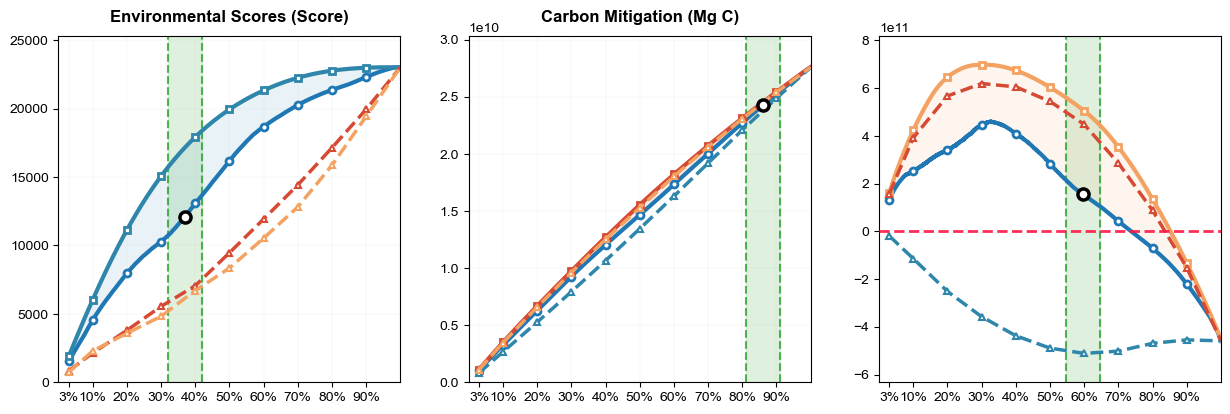

In [16]:
def create_cross_target_analysis(pixel_optimized_data, us_states_4326, df_net_benefit):
    """
    创建交叉目标分析图，比较单目标最优排序在其他目标下的表现
    """
    
    # 创建1行3列的布局
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))  # 压缩Y轴高度
    
    # 定义三个变量
    variables = [
        ('predicted_prob', 'Environmental Scores', 'Score'),
        ('Expectation_net_benefit', 'Carbon Mitigation', 'Mg C'),
        ('avg_npv', 'Economic NPV', 'USD')
    ]
    
    # Nature风格配色方案 - 与地图配色协调
    # 主曲线颜色（更鲜艳，突出）
    main_colors = {
        'ccd': '#1f77b4',      # 深蓝色 - 与地图蓝色呼应
        'predicted_prob': '#2E86AB',      # 蓝色
        'Expectation_net_benefit': '#D64933',  # 红色
        'avg_npv': '#F4A261',          # 橙色
        'critical': '#2ca02c'   # 深绿色 - 突出关键点
    }
    
    # 存储每个目标的最优排序
    optimal_orders = {}
    
    # ==================== 数据预处理：取出需要的列后进行merge ====================
    print("=== 数据预处理：取出需要的列后进行merge ===")
    
    # 从df_net_benefit取出需要的列
    area_data = df_net_benefit[['lat', 'lon', 'area_m2']].copy()
    
    # 与pixel_optimized_data进行merge
    print("与pixel_optimized_data进行merge...")
    merged_data = pixel_optimized_data.merge(area_data, on=['lat', 'lon'], how='inner')
    print(f"合并后数据行数: {len(merged_data)}")
    
    if len(merged_data) == 0:
        raise ValueError("合并后没有数据，请检查lat, lon是否匹配")
    
    # 获取面积数据
    area_values = merged_data['area_m2'].values / 10000  # 转换为公顷
    
    print(f"数据合并完成，总面积: {np.sum(area_values):.2f} 公顷")
    
    for idx, (variable_name, variable_label, unit) in enumerate(variables):
        ax = axes[idx]
        
        print(f"\n=== 处理 {variable_label} ===")
        
        # ==================== 数据准备（使用合并后的数据） ====================
        benefit_density_values = merged_data[variable_name].values
        ccd_values_total = merged_data['ccd_optimized'].values
        
        # 计算总效益值
        if variable_name == 'predicted_prob':
            benefit_total_values = benefit_density_values
        else:
            benefit_total_values = benefit_density_values * area_values
        
        # 特殊处理NPV数据（保留负值）
        if variable_name == 'avg_npv':
            benefit_total_values = benefit_total_values.copy()
        
        # 计算总累积效应（所有曲线都应该达到这个值）
        total_cumulative_benefit = np.sum(benefit_total_values)
        
        print(f"数据统计：")
        print(f"  密度值范围: {benefit_density_values.min():.2e} 到 {benefit_density_values.max():.2e}")
        print(f"  总效益值范围: {benefit_total_values.min():.2e} 到 {benefit_total_values.max():.2e}")
        print(f"  总累积效应: {total_cumulative_benefit:.2e}")
        
        # ==================== 计算各目标的最优排序 ====================
        # 按CCD排序
        ccd_sorted_indices = np.argsort(ccd_values_total)[::-1]
        ccd_cumulative_benefits = np.cumsum(benefit_total_values[ccd_sorted_indices])
        ccd_cumulative_percentage = np.arange(1, len(ccd_cumulative_benefits) + 1) / len(ccd_cumulative_benefits) * 100
        
        # 按当前目标排序
        target_sorted_indices = np.argsort(benefit_total_values)[::-1]
        target_cumulative_benefits = np.cumsum(benefit_total_values[target_sorted_indices])
        target_cumulative_percentage = np.arange(1, len(target_cumulative_benefits) + 1) / len(target_cumulative_benefits) * 100
        
        # 存储当前目标的最优排序
        optimal_orders[variable_name] = target_sorted_indices
        
        # 确保从0开始
        ccd_cumulative_benefits = np.concatenate([[0], ccd_cumulative_benefits])
        ccd_cumulative_percentage = np.concatenate([[0], ccd_cumulative_percentage])
        target_cumulative_benefits = np.concatenate([[0], target_cumulative_benefits])
        target_cumulative_percentage = np.concatenate([[0], target_cumulative_percentage])
        
        print(f"CCD累积曲线范围: {ccd_cumulative_benefits.min():.2e} 到 {ccd_cumulative_benefits.max():.2e}")
        print(f"目标累积曲线范围: {target_cumulative_benefits.min():.2e} 到 {target_cumulative_benefits.max():.2e}")
        
        # ==================== 绘制当前目标的曲线 ====================
        start_idx_ccd = np.argmin(np.abs(ccd_cumulative_percentage - 3))
        start_idx_target = np.argmin(np.abs(target_cumulative_percentage - 3))
        
        # 选择关键点位 - 避免3%和5%重合
        key_percentages = [3, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # 移除5%
        key_indices_ccd = []
        key_indices_target = []
        
        for p in key_percentages:
            idx_ccd = np.argmin(np.abs(ccd_cumulative_percentage - p))
            if idx_ccd < len(ccd_cumulative_percentage):
                key_indices_ccd.append(idx_ccd)
            
            idx_target = np.argmin(np.abs(target_cumulative_percentage - p))
            if idx_target < len(target_cumulative_percentage):
                key_indices_target.append(idx_target)
        
        # 绘制CCD曲线 - 更粗更鲜艳
        ax.plot(ccd_cumulative_percentage[start_idx_ccd:], ccd_cumulative_benefits[start_idx_ccd:], '-', 
                color=main_colors['ccd'], linewidth=3.0, alpha=1.0, zorder=3, label='By CCD')
        
        # 关键点marker - 更突出
        valid_key_indices_ccd = [idx for idx in key_indices_ccd if idx >= start_idx_ccd]
        if valid_key_indices_ccd:
            ax.plot(ccd_cumulative_percentage[valid_key_indices_ccd], ccd_cumulative_benefits[valid_key_indices_ccd], 'o', 
                    color=main_colors['ccd'], markersize=5, markerfacecolor='white', markeredgewidth=2.0, 
                    markeredgecolor=main_colors['ccd'], zorder=3)
        
        # 绘制当前目标最优曲线 - 更粗更鲜艳
        ax.plot(target_cumulative_percentage[start_idx_target:], target_cumulative_benefits[start_idx_target:], '-', 
                color=main_colors[variable_name], linewidth=3.0, alpha=1.0, zorder=4, label=f'By {variable_label}')
        
        # 关键点marker - 更突出
        valid_key_indices_target = [idx for idx in key_indices_target if idx >= start_idx_target]
        if valid_key_indices_target:
            ax.plot(target_cumulative_percentage[valid_key_indices_target], target_cumulative_benefits[valid_key_indices_target], 's', 
                    color=main_colors[variable_name], markersize=5, markerfacecolor='white', markeredgewidth=2.0, 
                    markeredgecolor=main_colors[variable_name], zorder=4)
        
        # ==================== 绘制其他目标的交叉曲线 ====================
        for other_var_name, other_var_label, other_unit in variables:
            if other_var_name != variable_name:
                print(f"  计算 {other_var_label} 排序下的 {variable_label} 交叉曲线...")
                
                # 获取其他目标的数据（使用合并后的数据）
                other_density_values = merged_data[other_var_name].values
                if other_var_name == 'predicted_prob':
                    other_total_values = other_density_values
                else:
                    other_total_values = other_density_values * area_values
                
                if other_var_name == 'avg_npv':
                    other_total_values = other_total_values.copy()
                
                # 计算其他目标的最优排序
                other_sorted_indices = np.argsort(other_total_values)[::-1]
                
                # 关键：使用CCD分位数作为截断标记，计算其他目标排序下的当前目标累积效应
                cross_cumulative_benefits = []
                cross_cumulative_percentage = []
                
                for p in key_percentages:
                    # 找到CCD分位数对应的像素数量
                    ccd_pixel_count = int(len(ccd_sorted_indices) * p / 100)
                    
                    # 获取按其他目标排序的前p%像素索引
                    top_other_pixels = other_sorted_indices[:ccd_pixel_count]
                    
                    # 计算这些像素在当前目标下的累积效应
                    cross_benefit = np.sum(benefit_total_values[top_other_pixels])
                    
                    cross_cumulative_benefits.append(cross_benefit)
                    cross_cumulative_percentage.append(p)
                    
                    print(f"    {p}%: {cross_benefit:.2e}")
                
                # 确保从0开始，并确保100%时达到总累积效应
                cross_cumulative_benefits = np.concatenate([[0], cross_cumulative_benefits, [total_cumulative_benefit]])
                cross_cumulative_percentage = np.concatenate([[0], cross_cumulative_percentage, [100]])
                
                print(f"  交叉曲线范围: {min(cross_cumulative_benefits):.2e} 到 {max(cross_cumulative_benefits):.2e}")
                
                # 找到3%对应的索引
                start_idx_cross = np.argmin(np.abs(cross_cumulative_percentage - 3))
                
                # 绘制交叉曲线（虚线）- 提高zorder确保可见，使用更粗的线
                ax.plot(cross_cumulative_percentage[start_idx_cross:], cross_cumulative_benefits[start_idx_cross:], '--', 
                        color=main_colors[other_var_name], linewidth=2.5, alpha=1.0, zorder=6, 
                        label=f'By {other_var_label}')
                
                # 添加交叉曲线的关键点标记
                valid_key_indices_cross = [i for i, p in enumerate(cross_cumulative_percentage) if p >= 3 and p <= 90]
                if valid_key_indices_cross:
                    ax.plot(cross_cumulative_percentage[valid_key_indices_cross], cross_cumulative_benefits[valid_key_indices_cross], '^', 
                            color=main_colors[other_var_name], markersize=4, markerfacecolor='white', markeredgewidth=1.5, 
                            markeredgecolor=main_colors[other_var_name], zorder=6)
        
        # 效率差异区域 - 更淡的背景，降低zorder
        ax.fill_between(ccd_cumulative_percentage[start_idx_ccd:], 
                        ccd_cumulative_benefits[start_idx_ccd:], 
                        target_cumulative_benefits[start_idx_target:], 
                        alpha=0.1, color=main_colors[variable_name], zorder=1)
        
        # Critical点计算和标记 - 只在CCD曲线上
        if len(ccd_cumulative_percentage) > 2:
            dx = np.diff(ccd_cumulative_percentage)
            dy = np.diff(ccd_cumulative_benefits)
            d2y = np.diff(dy)
            
            slopes = dy[:-1] / dx[:-1]
            curvature = np.abs(d2y) / (1 + slopes**2)**1.5
            max_curvature_idx = np.argmax(curvature) + 1
            
            max_curvature_percentage = ccd_cumulative_percentage[max_curvature_idx]
            max_curvature_y = ccd_cumulative_benefits[max_curvature_idx]
            
            # Critical点 - 更突出
            ax.plot(max_curvature_percentage, max_curvature_y, 'o', color=main_colors['critical'], markersize=8, 
                   markeredgecolor='black', markeredgewidth=2.5, zorder=7, markerfacecolor='white')
            
            # Critical区域 - 淡绿色背景
            confidence_start_percentage = max(3, max_curvature_percentage - 5)
            confidence_end_percentage = min(100, max_curvature_percentage + 5)
            
            # 使用淡绿色填充，与critical点颜色呼应
            ax.axvspan(confidence_start_percentage, confidence_end_percentage, color=main_colors['critical'], alpha=0.15, zorder=0)
            
            # 置信区间边界线
            ax.axvline(x=confidence_start_percentage, color=main_colors['critical'], linestyle='--', linewidth=1.5, alpha=0.8, zorder=1)
            ax.axvline(x=confidence_end_percentage, color=main_colors['critical'], linestyle='--', linewidth=1.5, alpha=0.8, zorder=1)
        
        # 特殊处理NPV的Y=0线
        if variable_name == 'avg_npv':
            ax.axhline(y=0, color='#FF1744', linestyle='--', linewidth=2.0, alpha=0.9, zorder=8)
        
        # 设置X轴刻度 - 避免重合，增大字体
        xtick_positions = [target_cumulative_percentage[i] for i in key_indices_target]
        xtick_labels = [f'{p}%' for p in key_percentages]
        ax.set_xticks(xtick_positions)
        ax.set_xticklabels(xtick_labels, ha='center', fontsize=10)  # 从7增加到10
        ax.set_xlim(0, 100)
        
        # 设置Y轴范围 - 收集所有曲线的数据范围
        all_curves_min = min(ccd_cumulative_benefits.min(), target_cumulative_benefits.min())
        all_curves_max = max(ccd_cumulative_benefits.max(), target_cumulative_benefits.max())
        
        # 添加交叉曲线的范围
        for other_var_name, other_var_label, other_unit in variables:
            if other_var_name != variable_name:
                # 这里需要重新计算交叉曲线来获取范围
                other_density_values = merged_data[other_var_name].values
                if other_var_name == 'predicted_prob':
                    other_total_values = other_density_values
                else:
                    other_total_values = other_density_values * area_values
                
                if other_var_name == 'avg_npv':
                    other_total_values = other_total_values.copy()
                
                other_sorted_indices = np.argsort(other_total_values)[::-1]
                
                cross_benefits = []
                for p in key_percentages:
                    ccd_pixel_count = int(len(ccd_sorted_indices) * p / 100)
                    top_other_pixels = other_sorted_indices[:ccd_pixel_count]
                    cross_benefit = np.sum(benefit_total_values[top_other_pixels])
                    cross_benefits.append(cross_benefit)
                
                cross_benefits = np.concatenate([[0], cross_benefits, [total_cumulative_benefit]])
                all_curves_min = min(all_curves_min, cross_benefits.min())
                all_curves_max = max(all_curves_max, cross_benefits.max())
        
        print(f"所有曲线范围: {all_curves_min:.2e} 到 {all_curves_max:.2e}")
        
        if variable_name == 'avg_npv':
            # 确保Y轴范围合理
            y_range = all_curves_max - all_curves_min
            if y_range == 0:
                y_range = abs(all_curves_max) * 0.1  # 如果所有值相同，设置一个小的范围
            
            ax.set_ylim(all_curves_min - y_range * 0.1, all_curves_max + y_range * 0.1)
            
            # 自定义Y轴刻度格式
            def custom_y_formatter(x, pos):
                if x >= 0:
                    return f'{x/1e9:.1f}B'
                else:
                    return f'{x/1e6:.0f}M'
            ax.yaxis.set_major_formatter(FuncFormatter(custom_y_formatter))
        else:
            ax.set_ylim(0, all_curves_max * 1.1)
        
        # 网格 - 更淡
        ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.3)
        ax.set_axisbelow(True)
        
        # 刻度 - 增大字体
        ax.tick_params(axis='both', which='major', labelsize=10, colors='black')  # 从7增加到10
        
        # 子图标题（不加a,b,c，加单位）- 增大字体
        ax.set_title(f'{variable_label} ({unit})', fontsize=12, fontweight='bold', pad=10)  # 从10增加到12
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    
    return fig, axes, optimal_orders, variables, main_colors

# 创建交叉分析图
fig_cross, axes_cross, optimal_orders, variables, main_colors = create_cross_target_analysis(pixel_optimized_data, us_states_4326, df_net_benefit)

# 保存主图
output_dir = 'figure/US_figure'
os.makedirs(output_dir, exist_ok=True)
fig_cross.savefig(f'{output_dir}/Figure4_cross_target_analysis.eps', 
                  bbox_inches='tight', dpi=300, format='eps')
fig_cross.savefig(f'{output_dir}/Figure4_cross_target_analysis.png', 
                  bbox_inches='tight', dpi=300, format='png')

plt.show()

# ==================== 创建优化的图例布局 ====================

# 1. 总体图例（包含效率差异区间和Critical关键区域）- 紧凑布局，无框线
def create_overall_legend():
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.set_xlim(0, 15)
    ax.set_ylim(0, 3)
    ax.axis('off')
    
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch

    # 总体图例元素
    legend_elements = [
        Line2D([0], [0], marker='o', color=main_colors['ccd'], markersize=5, linewidth=3.0, label='By CCD'),
        Line2D([0], [0], marker='s', color=main_colors['predicted_prob'], markersize=5, linewidth=3.0, label='By Environmental Scores'),
        Line2D([0], [0], marker='s', color=main_colors['Expectation_net_benefit'], markersize=5, linewidth=3.0, label='By Carbon Mitigation'),
        Line2D([0], [0], marker='s', color=main_colors['avg_npv'], markersize=5, linewidth=3.0, label='By Economic NPV'),
        Line2D([0], [0], marker='o', color=main_colors['critical'], markersize=8, markeredgecolor='black', 
               markeredgewidth=2.5, linewidth=0, label='Critical Point', markerfacecolor='white'),
        Patch(facecolor=main_colors['predicted_prob'], alpha=0.1, label='Efficiency Gap'),
        Patch(facecolor=main_colors['critical'], alpha=0.15, label='Critical Region'),
        Line2D([0], [0], color='#FF1744', linestyle='--', linewidth=2.0, label='Zero Line (NPV)')  # 添加Y=0线
    ]

    # 一行2个，一共3行
    ax.legend(handles=legend_elements, loc='center', ncol=4, fontsize=10, 
              frameon=False, fancybox=False, shadow=False, bbox_to_anchor=(0.5, 0.5))  # ncol=4, 自动分2行

    plt.tight_layout()
    return fig

# 2. 交叉曲线图例 - 无框线
def create_cross_curves_legend():
    fig, ax = plt.subplots(figsize=(12, 2))
    ax.set_xlim(0, 15)
    ax.set_ylim(0, 2)
    ax.axis('off')
    
    from matplotlib.lines import Line2D
    
    # 交叉曲线图例元素
    legend_elements = []
    
    # 添加交叉曲线说明
    for var_name, var_label, var_unit in variables:
        legend_elements.append(
            Line2D([0], [0], linestyle='--', color=main_colors[var_name], linewidth=2.5, 
                   label=f'By {var_label}', alpha=1.0)
        )
    
    ax.legend(handles=legend_elements, loc='center', ncol=3, fontsize=10, 
              frameon=False, fancybox=False, shadow=False)  # 去掉框线
    
    plt.tight_layout()
    return fig

# 3. 完整图例（总体+交叉曲线）- 无框线
def create_complete_legend():
    fig, ax = plt.subplots(figsize=(15, 2.5))
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 2.5)
    ax.axis('off')
    
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    
    # 总体图例元素
    overall_elements = [
        Line2D([0], [0], marker='o', color=main_colors['ccd'], markersize=5, linewidth=3.0, label='By CCD'),
        Line2D([0], [0], marker='s', color=main_colors['predicted_prob'], markersize=5, linewidth=3.0, label='By Environmental Scores'),
        Line2D([0], [0], marker='s', color=main_colors['Expectation_net_benefit'], markersize=5, linewidth=3.0, label='By Carbon Mitigation'),
        Line2D([0], [0], marker='s', color=main_colors['avg_npv'], markersize=5, linewidth=3.0, label='By Economic NPV'),
        Line2D([0], [0], marker='o', color=main_colors['critical'], markersize=8, markeredgecolor='black', 
               markeredgewidth=2.5, linewidth=0, label='Critical Point', markerfacecolor='white'),
        Patch(facecolor=main_colors['predicted_prob'], alpha=0.1, label='Efficiency Gap'),
        Patch(facecolor=main_colors['critical'], alpha=0.15, label='Critical Region'),
        Line2D([0], [0], color='#FF1744', linestyle='--', linewidth=2.0, label='Zero Line (NPV)')  # 添加Y=0线
    ]
    
    # 交叉曲线图例元素
    cross_elements = []
    for var_name, var_label, var_unit in variables:
        cross_elements.append(
            Line2D([0], [0], linestyle='--', color=main_colors[var_name], linewidth=2.5, 
                   label=f'By {var_label}', alpha=1.0)
        )
    
    # 合并所有图例元素
    all_elements = overall_elements + cross_elements
    
    ax.legend(handles=all_elements, loc='center', ncol=8, fontsize=9, 
              frameon=False, fancybox=False, shadow=False)  # 去掉框线
    
    plt.tight_layout()
    return fig

# 创建并保存图例
fig_overall_legend = create_overall_legend()
fig_cross_curves_legend = create_cross_curves_legend()
fig_complete_legend = create_complete_legend()

# 保存图例
fig_overall_legend.savefig(f'{output_dir}/Figure4_cross_overall_legend.eps', 
                          bbox_inches='tight', dpi=300, format='eps')
fig_overall_legend.savefig(f'{output_dir}/Figure4_cross_overall_legend.png', 
                          bbox_inches='tight', dpi=300, format='png')

fig_cross_curves_legend.savefig(f'{output_dir}/Figure4_cross_curves_legend.eps', 
                               bbox_inches='tight', dpi=300, format='eps')
fig_cross_curves_legend.savefig(f'{output_dir}/Figure4_cross_curves_legend.png', 
                               bbox_inches='tight', dpi=300, format='png')

fig_complete_legend.savefig(f'{output_dir}/Figure4_cross_complete_legend.eps', 
                           bbox_inches='tight', dpi=300, format='eps')
fig_complete_legend.savefig(f'{output_dir}/Figure4_cross_complete_legend.png', 
                           bbox_inches='tight', dpi=300, format='png')

plt.show()

# 输出分析结果
print("=== 交叉目标分析结果 ===")

print("\n交叉分析图和图例创建完成！")
print(f"保存的文件：")
print(f"1. 主图：Figure4_cross_target_analysis.eps/png")
print(f"2. 总体图例：Figure4_cross_overall_legend.eps/png")
print(f"3. 交叉曲线图例：Figure4_cross_curves_legend.eps/png")
print(f"4. 完整图例：Figure4_cross_complete_legend.eps/png")

## 7、（决策权重密度图）

pixel_optimized_data

要求你绘制一个基于数据密度的三角图，并且在图上绘制凸包表示聚类


每个Pixel的optimal_weight_economic+optimal_weight_environmental+optimal_weight_emission=1
不同权重的分布、数据密度是有不同经济含义的，比如pixel总体有60000多个，有30000个pixel的optimal_weight_economic权重低，这表示要减少经济权重
要求风格符合Nature style

这是以下三个变量：

['optimal_weight_economic'] 
['optimal_weight_environmental'] 
['optimal_weight_emission'] 


换个数据

weight_deviation_economic
weight_deviation_environmental
weight_deviation_emission

=== 数据预处理：取出需要的列后进行merge ===
与pixel_optimized_data进行merge...
合并后数据行数: 64982
数据合并完成，总面积: 4376972.78 公顷


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


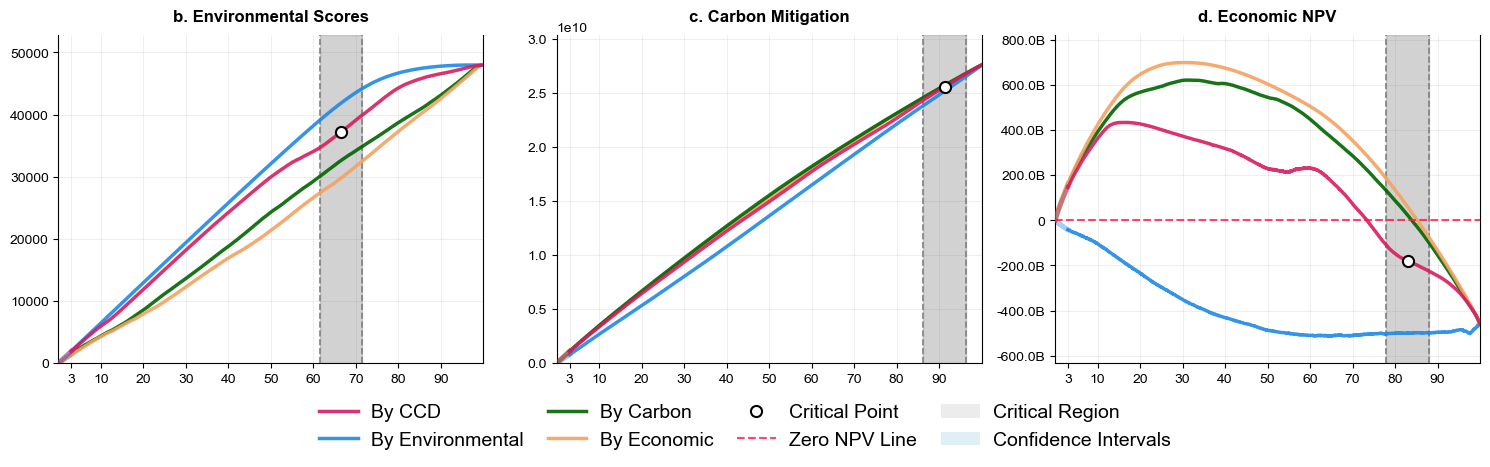

交叉目标分析图创建完成！


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def create_cross_target_analysis(pixel_optimized_data, us_states_4326=None, df_net_benefit=None):
    """
    创建交叉目标分析图，比较单目标最优排序在其他目标下的表现
    """
    # 创建1行3列的布局
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))  # 压缩Y轴高度

    # 定义三个变量
    variables = [
        ('predicted_prob', 'Environmental Scores', 'Score'),
        ('Expectation_net_benefit', 'Carbon Mitigation', 'Mg C'),
        ('avg_npv', 'Economic NPV', 'USD')
    ]

    # 颜色方案
    ccd_color = '#D81B60'   # 洋红色
    env_color = '#1E88E5'   # 蓝色
    carbon_color = '#006400'  # 深绿色
    economic_color = '#F4A261'  # 橙色

    # 映射变量名到颜色
    variable_colors = {
        'predicted_prob': env_color,
        'Expectation_net_benefit': carbon_color,
        'avg_npv': economic_color
    }

    # 定义标记样式（不再用于数据点，仅用于图例）
    markers = {
        'ccd': 'o',
        'predicted_prob': 's',
        'Expectation_net_benefit': '^',
        'avg_npv': 'D'
    }

    # 用于收集所有图例元素
    all_legend_elements = []

    # ==================== 数据预处理：取出需要的列后进行merge ====================
    print("=== 数据预处理：取出需要的列后进行merge ===")
    area_data = df_net_benefit[['lat', 'lon', 'area_m2']].copy()
    print("与pixel_optimized_data进行merge...")
    merged_data = pixel_optimized_data.merge(area_data, on=['lat', 'lon'], how='inner')
    print(f"合并后数据行数: {len(merged_data)}")
    if len(merged_data) == 0:
        raise ValueError("合并后没有数据，请检查lat, lon是否匹配")
    area_values = merged_data['area_m2'].values / 10000  # 转换为公顷
    print(f"数据合并完成，总面积: {np.sum(area_values):.2f} 公顷")

    for idx, (variable_name, variable_label, unit) in enumerate(variables):
        ax1 = axes[idx]
        ax1.spines['top'].set_visible(False)

        # ==================== 数据准备 ====================
        benefit_density_values = merged_data[variable_name].values
        ccd_values = merged_data['ccd_optimized'].values

        if variable_name == 'predicted_prob':
            benefit_total_values = benefit_density_values
        else:
            benefit_total_values = benefit_density_values * area_values

        # ==================== 曲线计算 ====================
        ccd_sorted_indices = np.argsort(ccd_values)[::-1]
        ccd_cumulative_benefits = np.cumsum(benefit_total_values[ccd_sorted_indices])
        ccd_cumulative_percentage = np.arange(1, len(ccd_cumulative_benefits) + 1) / len(ccd_cumulative_benefits) * 100
        ccd_cumulative_benefits = np.concatenate([[0], ccd_cumulative_benefits])
        ccd_cumulative_percentage = np.concatenate([[0], ccd_cumulative_percentage])

        target_sorted_indices = np.argsort(benefit_total_values)[::-1]
        target_cumulative_benefits = np.cumsum(benefit_total_values[target_sorted_indices])
        target_cumulative_percentage = np.arange(1, len(target_cumulative_benefits) + 1) / len(target_cumulative_benefits) * 100
        target_cumulative_benefits = np.concatenate([[0], target_cumulative_benefits])
        target_cumulative_percentage = np.concatenate([[0], target_cumulative_percentage])

        cross_curves_data = []
        for other_var_name, other_var_label, other_unit in variables:
            if other_var_name != variable_name:
                other_density_values = merged_data[other_var_name].values
                if other_var_name == 'predicted_prob':
                    other_total_values = other_density_values
                else:
                    other_total_values = other_density_values * area_values
                cross_sorted_indices = np.argsort(other_total_values)[::-1]
                cross_cumulative_benefits = np.cumsum(benefit_total_values[cross_sorted_indices])
                cross_cumulative_percentage = np.arange(1, len(cross_cumulative_benefits) + 1) / len(cross_cumulative_benefits) * 100
                cross_cumulative_benefits = np.concatenate([[0], cross_cumulative_benefits])
                cross_cumulative_percentage = np.concatenate([[0], cross_cumulative_percentage])
                cross_curves_data.append({
                    'label': f'By {other_var_label.split(" ")[0]}',
                    'color': variable_colors[other_var_name],
                    'marker': markers[other_var_name],
                    'percentage': cross_cumulative_percentage,
                    'benefits': cross_cumulative_benefits
                })

        # ==================== 绘制曲线 ====================
        start_idx_ccd = np.argmin(np.abs(ccd_cumulative_percentage - 3))

        # CCD曲线
        ax1.plot(ccd_cumulative_percentage[0:start_idx_ccd], ccd_cumulative_benefits[0:start_idx_ccd],
                 color=ccd_color, linewidth=3.5, alpha=0.4, linestyle='-', zorder=4)
        ax1.plot(ccd_cumulative_percentage[start_idx_ccd:], ccd_cumulative_benefits[start_idx_ccd:],
                 color=ccd_color, linewidth=2.5, alpha=0.9, linestyle='-', zorder=4,
                 label='By CCD')

        # 目标曲线
        target_color_current = variable_colors[variable_name]
        ax1.plot(target_cumulative_percentage[0:start_idx_ccd], target_cumulative_benefits[0:start_idx_ccd],
                 color=target_color_current, linewidth=3.5, alpha=0.4, linestyle='-', zorder=3)
        ax1.plot(target_cumulative_percentage[start_idx_ccd:], target_cumulative_benefits[start_idx_ccd:],
                 color=target_color_current, linewidth=2.5, alpha=0.9, linestyle='-', zorder=3,
                 label=f'By {variable_label.split(" ")[0]}')

        # 交叉曲线
        for curve in cross_curves_data:
            ax1.plot(curve['percentage'][0:start_idx_ccd], curve['benefits'][0:start_idx_ccd],
                     color=curve['color'], linewidth=3.5, alpha=0.4, linestyle='-', zorder=2)
            ax1.plot(curve['percentage'][start_idx_ccd:], curve['benefits'][start_idx_ccd:],
                     color=curve['color'], linewidth=2.5, alpha=0.9, linestyle='-', zorder=2,
                     label=curve['label'])

        # Critical点计算和标记 (仅CCD曲线)
        if len(ccd_cumulative_percentage) > 2:
            dx = np.diff(ccd_cumulative_percentage)
            dy = np.diff(ccd_cumulative_benefits)
            slopes = np.divide(dy[:-1], dx[:-1], out=np.zeros_like(dy[:-1], dtype=float), where=dx[:-1]!=0)
            d2y = np.diff(dy)
            denominator = (1 + slopes**2)**1.5
            if len(denominator) > len(d2y):
                denominator = denominator[:len(d2y)]
            elif len(denominator) < len(d2y):
                d2y = d2y[:len(denominator)]
            curvature = np.divide(np.abs(d2y), denominator, out=np.zeros_like(d2y, dtype=float), where=denominator!=0)
            if curvature.size > 0:
                max_curvature_idx = np.argmax(curvature) + 1
                if max_curvature_idx < len(ccd_cumulative_percentage):
                    max_curvature_percentage = ccd_cumulative_percentage[max_curvature_idx]
                    max_curvature_y = ccd_cumulative_benefits[max_curvature_idx]
                    # Critical点
                    ax1.plot(max_curvature_percentage, max_curvature_y, 'o', color=ccd_color, markersize=8,
                             markeredgecolor='black', markeredgewidth=1.5, zorder=5, markerfacecolor='white')
                    # Critical区域
                    confidence_start_percentage = max(3, max_curvature_percentage - 5)
                    confidence_end_percentage = min(100, max_curvature_percentage + 5)
                    ax1.axvspan(confidence_start_percentage, confidence_end_percentage, color='gray', alpha=0.35, zorder=1)
                    ax1.axvline(x=confidence_start_percentage, color='gray', linestyle='--', linewidth=1.2, alpha=1.0, zorder=1)
                    ax1.axvline(x=confidence_end_percentage, color='gray', linestyle='--', linewidth=1.2, alpha=1.0, zorder=1)

        # 特殊处理NPV的Y=0线
        if variable_name == 'avg_npv':
            ax1.axhline(y=0, color='#FF1744', linestyle='--', linewidth=1.5, alpha=0.8, zorder=6)

        # 设置X轴刻度
        key_percentages = [3, 10, 20, 30, 40, 50, 60, 70, 80, 90]
        xtick_positions = [p for p in key_percentages if p >= 3]
        xtick_labels = [f'{p}' for p in xtick_positions]
        if 3 in xtick_positions and 5 in xtick_positions:
            idx_3 = xtick_positions.index(3)
            idx_5 = xtick_positions.index(5)
            if abs(ccd_cumulative_percentage[np.argmin(np.abs(ccd_cumulative_percentage - 3))] -
                   ccd_cumulative_percentage[np.argmin(np.abs(ccd_cumulative_percentage - 5))]) < 2:
                xtick_positions.pop(idx_3)
                xtick_labels.pop(idx_3)
        ax1.set_xticks(xtick_positions)
        ax1.set_xticklabels(xtick_labels, ha='center', fontsize=10)
        ax1.set_xlim(0, 100)

        # 设置Y轴范围
        all_curves_min = min(ccd_cumulative_benefits.min(), target_cumulative_benefits.min())
        all_curves_max = max(ccd_cumulative_benefits.max(), target_cumulative_benefits.max())
        for curve in cross_curves_data:
            all_curves_min = min(all_curves_min, curve['benefits'].min())
            all_curves_max = max(all_curves_max, curve['benefits'].max())
        if variable_name == 'avg_npv':
            y_range = all_curves_max - all_curves_min
            if y_range == 0:
                y_range = abs(all_curves_max) * 0.1
            ax1.set_ylim(all_curves_min - y_range * 0.1, all_curves_max + y_range * 0.1)
            def custom_y_formatter(x, pos):
                if abs(x) >= 1e9:
                    return f'{x/1e9:.1f}B'
                elif abs(x) >= 1e6:
                    return f'{x/1e6:.0f}M'
                else:
                    return f'{x:.0f}'
            ax1.yaxis.set_major_formatter(FuncFormatter(custom_y_formatter))
        else:
            ax1.set_ylim(0, all_curves_max * 1.1)

        ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
        ax1.set_axisbelow(True)
        ax1.tick_params(axis='both', which='major', labelsize=10, colors='black')
        ax1.set_title(f'{chr(98+idx)}. {variable_label}', fontsize=12, fontweight='bold', pad=10)

        # 收集图例元素
        handles, labels = ax1.get_legend_handles_labels()
        ordered_labels = ['By CCD', f'By {variable_label.split(" ")[0]}'] + [f'By {v[1].split(" ")[0]}' for v in variables if v[0] != variable_name]
        ordered_handles = []
        for ol in ordered_labels:
            try:
                idx_in_handles = labels.index(ol)
                ordered_handles.append(handles[idx_in_handles])
            except ValueError:
                pass

        from matplotlib.lines import Line2D
        critical_point_handle = Line2D([0], [0], marker='o', color=ccd_color, markersize=8, markeredgecolor='black',
                                       markeredgewidth=1.5, linewidth=0, label='Critical Point', markerfacecolor='white')
        if critical_point_handle not in all_legend_elements:
            all_legend_elements.append(critical_point_handle)
        if variable_name == 'avg_npv':
            zero_line_handle = Line2D([0], [0], color='#FF1744', linestyle='--', linewidth=1.5,
                                      label='Zero NPV Line', alpha=0.8)
            if zero_line_handle not in all_legend_elements:
                all_legend_elements.append(zero_line_handle)
        for h, l in zip(ordered_handles, ordered_labels):
            is_duplicate = False
            for existing_h in all_legend_elements:
                if existing_h.get_label() == l and hasattr(h, "get_color") and hasattr(existing_h, "get_color") and h.get_color() == existing_h.get_color():
                    is_duplicate = True
                    break
            if not is_duplicate:
                all_legend_elements.append(h)

    # 统一图例布局
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch

    final_legend_elements = []
    for h in all_legend_elements:
        if h.get_label() == 'By CCD':
            final_legend_elements.append(h)
            break
    for var_name, var_label, _ in variables:
        target_label = f'By {var_label.split(" ")[0]}'
        for h in all_legend_elements:
            if h.get_label() == target_label and h not in final_legend_elements:
                final_legend_elements.append(h)
                break
    for h in all_legend_elements:
        if h.get_label() == 'Critical Point':
            final_legend_elements.append(h)
            break
    for h in all_legend_elements:
        if h.get_label() == 'Zero NPV Line':
            final_legend_elements.append(h)
            break
    critical_region_handle = Patch(facecolor='gray', alpha=0.15, label='Critical Region')
    final_legend_elements.append(critical_region_handle)
    confidence_interval_handle = Patch(facecolor='lightblue', alpha=0.4, label='Confidence Intervals')
    final_legend_elements.append(confidence_interval_handle)

    num_elements = len(final_legend_elements)
    ncol = (num_elements + 1) // 2

    fig.legend(handles=final_legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05),
               ncol=ncol, fontsize=14, frameon=False, fancybox=False, shadow=False, framealpha=0.9,
               columnspacing=1.2, handletextpad=0.7)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.18)
    return fig, axes

# Example usage (assuming pixel_optimized_data, us_states_4326, df_net_benefit are loaded)
fig_combined, axes_combined = create_cross_target_analysis(pixel_optimized_data=pixel_optimized_data, df_net_benefit=df_net_benefit)
fig_combined.savefig('figure/US_figure/Figure_cross_target_analysis.eps', bbox_inches='tight', dpi=300, format='eps')
fig_combined.savefig('figure/US_figure/Figure_cross_target_analysis.png', bbox_inches='tight', dpi=300, format='png')
plt.show()

print("交叉目标分析图创建完成！")

=== 数据预处理：取出需要的列后进行merge ===
与pixel_optimized_data进行merge...
合并后数据行数: 64982
数据合并完成，总面积: 4376972.78 公顷
Environmental Scores - 边际效应正向分界点: X=31.66%, Y=1.92e+04
  [31.66%] Environmental Scores自身累计: 2.05e+04
  [31.66%] Emission Mitigation目标下Environmental Scores累计: 1.45e+04
  [31.66%] Economic Expectation目标下Environmental Scores累计: 1.31e+04
Emission Mitigation - 边际效应正向分界点: X=31.66%, Y=9.83e+09
  [31.66%] Environmental Scores目标下Emission Mitigation累计: 8.47e+09
  [31.66%] Economic Expectation目标下Emission Mitigation累计: 1.01e+10
Economic NPV - Economic曲线与Y=0轴交点: X=85.23%, Y=0
Economic NPV - 整个曲线最终值: -4.59e+11 USD
Economic NPV - 最终值绝对值: 4.59e+11 USD
Economic NPV - 找到 2 个交点:
  交点 1: X=11.44%, 累积面积=500646.47 公顷, Y=4.59e+11 USD
  交点 2: X=65.24%, 累积面积=2855470.68 公顷, Y=4.59e+11 USD
Economic NPV - 区间 [11.44%, 65.24%] 内的累积效益正好抵消最终负值
Economic NPV - 第二个交点绿色阴影区域: X=65.24% 到 X=85.23%
Economic NPV - CCD最高点: X=15.76%, Y=4.33e+11
Economic NPV - Economic最高点: X=30.59%, Y=6.98e+11
Economic NPV - CCD最高点: X=15.76%, Y=

C:\Users\zpy10\AppData\Local\Temp\ipykernel_36244\725905828.py:150: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax1.axvspan(intersection_x, 100, color='black', alpha=0.1, zorder=1,
C:\Users\zpy10\AppData\Local\Temp\ipykernel_36244\725905828.py:227: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax1.axvspan(second_intersection_x, intersection_x, color='green', alpha=0.2, zorder=1,
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


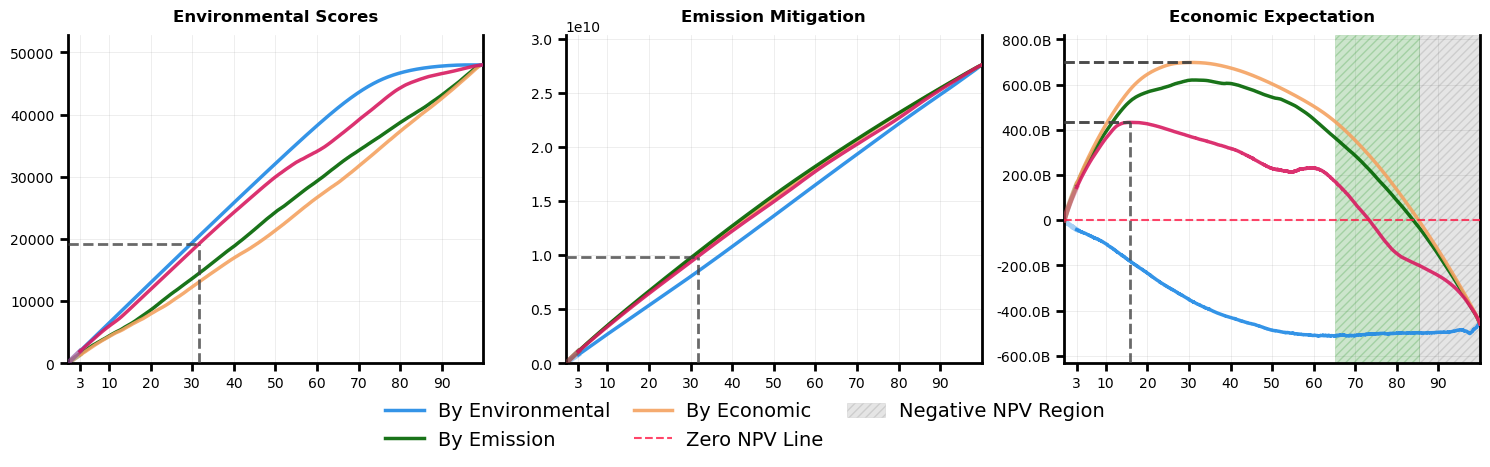

交叉目标分析图创建完成！


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def create_cross_target_analysis(pixel_optimized_data, us_states_4326=None, df_net_benefit=None):
    """
    创建交叉目标分析图，比较单目标最优排序在其他目标下的表现
    """
    # 创建1行3列的布局
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))  

    # 定义三个变量
    variables = [
        ('predicted_prob', 'Environmental Scores', 'Score'),
        ('Expectation_net_benefit', 'Emission Mitigation', 'Mg C'),
        ('avg_npv', 'Economic Expectation', 'USD')
    ]

    # 颜色方案
    ccd_color = '#D81B60'   # 洋红色
    env_color = '#1E88E5'   # 蓝色
    carbon_color = '#006400'  # 深绿色
    economic_color = '#F4A261'  # 橙色

    # 映射变量名到颜色
    variable_colors = {
        'predicted_prob': env_color,
        'Expectation_net_benefit': carbon_color,
        'avg_npv': economic_color
    }

    # 定义标记样式（不再用于数据点，仅用于图例）
    markers = {
        'ccd': 'o',
        'predicted_prob': 's',
        'Expectation_net_benefit': '^',
        'avg_npv': 'D'
    }

    # 用于收集所有图例元素
    all_legend_elements = []

    # ==================== 数据预处理：取出需要的列后进行merge ====================
    print("=== 数据预处理：取出需要的列后进行merge ===")
    area_data = df_net_benefit[['lat', 'lon', 'area_m2']].copy()
    print("与pixel_optimized_data进行merge...")
    merged_data = pixel_optimized_data.merge(area_data, on=['lat', 'lon'], how='inner')
    print(f"合并后数据行数: {len(merged_data)}")
    if len(merged_data) == 0:
        raise ValueError("合并后没有数据，请检查lat, lon是否匹配")
    area_values = merged_data['area_m2'].values / 10000  # 转换为公顷
    print(f"数据合并完成，总面积: {np.sum(area_values):.2f} 公顷")

    for idx, (variable_name, variable_label, unit) in enumerate(variables):
        ax1 = axes[idx]
        ax1.spines['top'].set_visible(False)

        # ==================== 数据准备 ====================
        benefit_density_values = merged_data[variable_name].values
        ccd_values = merged_data['ccd_optimized'].values

        if variable_name == 'predicted_prob':
            benefit_total_values = benefit_density_values
        else:
            benefit_total_values = benefit_density_values * area_values

        # ==================== 曲线计算 ====================
        ccd_sorted_indices = np.argsort(ccd_values)[::-1]
        ccd_cumulative_benefits = np.cumsum(benefit_total_values[ccd_sorted_indices])
        ccd_cumulative_percentage = np.arange(1, len(ccd_cumulative_benefits) + 1) / len(ccd_cumulative_benefits) * 100
        ccd_cumulative_benefits = np.concatenate([[0], ccd_cumulative_benefits])
        ccd_cumulative_percentage = np.concatenate([[0], ccd_cumulative_percentage])

        target_sorted_indices = np.argsort(benefit_total_values)[::-1]
        target_cumulative_benefits = np.cumsum(benefit_total_values[target_sorted_indices])
        target_cumulative_percentage = np.arange(1, len(target_cumulative_benefits) + 1) / len(target_cumulative_benefits) * 100
        target_cumulative_benefits = np.concatenate([[0], target_cumulative_benefits])
        target_cumulative_percentage = np.concatenate([[0], target_cumulative_percentage])

        cross_curves_data = []
        for other_var_name, other_var_label, other_unit in variables:
            if other_var_name != variable_name:
                other_density_values = merged_data[other_var_name].values
                if other_var_name == 'predicted_prob':
                    other_total_values = other_density_values
                else:
                    other_total_values = other_density_values * area_values
                cross_sorted_indices = np.argsort(other_total_values)[::-1]
                cross_cumulative_benefits = np.cumsum(benefit_total_values[cross_sorted_indices])
                cross_cumulative_percentage = np.arange(1, len(cross_cumulative_benefits) + 1) / len(cross_cumulative_benefits) * 100
                cross_cumulative_benefits = np.concatenate([[0], cross_cumulative_benefits])
                cross_cumulative_percentage = np.concatenate([[0], cross_cumulative_percentage])
                cross_curves_data.append({
                    'label': f'By {other_var_label.split(" ")[0]}',
                    'color': variable_colors[other_var_name],
                    'marker': markers[other_var_name],
                    'percentage': cross_cumulative_percentage,
                    'benefits': cross_cumulative_benefits
                })

        # ==================== 绘制曲线 ====================
        start_idx_ccd = np.argmin(np.abs(ccd_cumulative_percentage - 3))

        # CCD曲线
        ax1.plot(ccd_cumulative_percentage[0:start_idx_ccd], ccd_cumulative_benefits[0:start_idx_ccd],
                 color=ccd_color, linewidth=3.5, alpha=0.4, linestyle='-', zorder=4)
        ax1.plot(ccd_cumulative_percentage[start_idx_ccd:], ccd_cumulative_benefits[start_idx_ccd:],
                 color=ccd_color, linewidth=2.5, alpha=0.9, linestyle='-', zorder=4,
                 label='CCD')

        # 目标曲线
        target_color_current = variable_colors[variable_name]
        ax1.plot(target_cumulative_percentage[0:start_idx_ccd], target_cumulative_benefits[0:start_idx_ccd],
                 color=target_color_current, linewidth=3.5, alpha=0.4, linestyle='-', zorder=3)
        ax1.plot(target_cumulative_percentage[start_idx_ccd:], target_cumulative_benefits[start_idx_ccd:],
                 color=target_color_current, linewidth=2.5, alpha=0.9, linestyle='-', zorder=3,
                 label=f'{variable_label.split(" ")[0]}')

        # 交叉曲线
        for curve in cross_curves_data:
            ax1.plot(curve['percentage'][0:start_idx_ccd], curve['benefits'][0:start_idx_ccd],
                     color=curve['color'], linewidth=3.5, alpha=0.4, linestyle='-', zorder=2)
            ax1.plot(curve['percentage'][start_idx_ccd:], curve['benefits'][start_idx_ccd:],
                     color=curve['color'], linewidth=2.5, alpha=0.9, linestyle='-', zorder=2,
                     label=curve['label'])

        # 特殊处理NPV的Y=0线和黑色斜杠阴影
        if variable_name == 'avg_npv':
            ax1.axhline(y=0, color='#FF1744', linestyle='--', linewidth=1.5, alpha=0.8, zorder=6)
            
            # 找到Economic曲线与Y=0轴的交点
            economic_negative_mask = target_cumulative_benefits < 0
            intersection_x = None
            if np.any(economic_negative_mask):
                # 找到第一个负值点
                first_negative_idx = np.where(economic_negative_mask)[0][0]  # 修复：使用economic_negative_mask
                if first_negative_idx > 0:
                    # 计算与Y=0的交点
                    x1, y1 = target_cumulative_percentage[first_negative_idx-1], target_cumulative_benefits[first_negative_idx-1]
                    x2, y2 = target_cumulative_percentage[first_negative_idx], target_cumulative_benefits[first_negative_idx]
                    
                    # 线性插值找到交点
                    if y2 != y1:
                        intersection_x = x1 + (x2 - x1) * (0 - y1) / (y2 - y1)
                        intersection_y = 0
                        
                        # 绘制黑色斜杠阴影区域（右边部分：Economic NPV < 0 与X轴围合的部分）
                        ax1.axvspan(intersection_x, 100, color='black', alpha=0.1, zorder=1, 
                                   hatch='////', edgecolor='black', linewidth=0.5)
                        
                        print(f"Economic NPV - Economic曲线与Y=0轴交点: X={intersection_x:.2f}%, Y={intersection_y}")
            
            # 找到CCD和Economic维度的最高点和最低点
            ccd_max_idx = np.argmax(ccd_cumulative_benefits)
            economic_max_idx = np.argmax(target_cumulative_benefits)
            economic_min_idx = np.argmin(target_cumulative_benefits)
            
            ccd_max_x = ccd_cumulative_percentage[ccd_max_idx]
            ccd_max_y = ccd_cumulative_benefits[ccd_max_idx]
            economic_max_x = target_cumulative_percentage[economic_max_idx]
            economic_max_y = target_cumulative_benefits[economic_max_idx]
            economic_min_x = target_cumulative_percentage[economic_min_idx]
            economic_min_y = target_cumulative_benefits[economic_min_idx]
            
            # 计算Economic NPV最小值对应的分位数
            economic_density_values = merged_data['avg_npv'].values
            economic_total_values = economic_density_values * area_values
            
            # 按Economic NPV排序（从大到小）
            economic_sorted_indices = np.argsort(economic_total_values)[::-1]
            economic_sorted_values = economic_total_values[economic_sorted_indices]
            economic_sorted_areas = area_values[economic_sorted_indices]
            
            # 计算累积面积和累积效益
            cumulative_areas = np.cumsum(economic_sorted_areas)
            cumulative_benefits = np.cumsum(economic_sorted_values)
            
            # 找到整个曲线的最终最小值（累积效益的最小值）
            final_min_benefit = cumulative_benefits[-1]  # 这是整个曲线的最终值
            final_min_benefit_abs = abs(final_min_benefit)
            
            print(f"Economic NPV - 整个曲线最终值: {final_min_benefit:.2e} USD")
            print(f"Economic NPV - 最终值绝对值: {final_min_benefit_abs:.2e} USD")
            
            # 找到Economic曲线上与最终值绝对值相等的两个交点
            target_value = final_min_benefit_abs
            intersection_points = []
            
            # 在累积效益曲线上寻找交点
            for i in range(len(cumulative_benefits) - 1):
                y1, y2 = cumulative_benefits[i], cumulative_benefits[i+1]
                # 检查是否跨越目标值
                if (y1 <= target_value <= y2) or (y2 <= target_value <= y1):
                    # 线性插值找到精确交点
                    if y2 != y1:
                        t = (target_value - y1) / (y2 - y1)
                        area_ratio = t * (cumulative_areas[i+1] - cumulative_areas[i]) + cumulative_areas[i]
                        percentage = (area_ratio / np.sum(area_values)) * 100
                        intersection_points.append({
                            'index': i,
                            'percentage': percentage,
                            'area': area_ratio,
                            'benefit': target_value
                        })
            
            # 输出交点信息
            if len(intersection_points) >= 2:
                print(f"Economic NPV - 找到 {len(intersection_points)} 个交点:")
                for i, point in enumerate(intersection_points):
                    print(f"  交点 {i+1}: X={point['percentage']:.2f}%, 累积面积={point['area']:.2f} 公顷, Y={point['benefit']:.2e} USD")
                
                # 计算两个交点之间的区间
                if len(intersection_points) >= 2:
                    point1 = intersection_points[0]
                    point2 = intersection_points[1]
                    interval_start = min(point1['percentage'], point2['percentage'])
                    interval_end = max(point1['percentage'], point2['percentage'])
                    print(f"Economic NPV - 区间 [{interval_start:.2f}%, {interval_end:.2f}%] 内的累积效益正好抵消最终负值")
                    
                    # 绘制第二个交点X=65.24%处的绿色阴影区域
                    # 找到第二个交点在target_cumulative_percentage中的位置
                    second_intersection_x = point2['percentage']  # 假设point2是第二个交点
                    
                    # 绘制绿色阴影区域（从第二个交点到Y=0轴，避免与右侧黑色阴影重合）
                    ax1.axvspan(second_intersection_x, intersection_x, color='green', alpha=0.2, zorder=1, 
                               hatch='////', edgecolor='green', linewidth=0.5)
                    
                    print(f"Economic NPV - 第二个交点绿色阴影区域: X={second_intersection_x:.2f}% 到 X={intersection_x:.2f}%")
            else:
                print(f"Economic NPV - 未找到足够的交点来抵消最终负值 {final_min_benefit:.2e} USD")


                
            # 找到CCD和Economic维度的最高点
            ccd_max_idx = np.argmax(ccd_cumulative_benefits)
            economic_max_idx = np.argmax(target_cumulative_benefits)
            
            ccd_max_x = ccd_cumulative_percentage[ccd_max_idx]
            ccd_max_y = ccd_cumulative_benefits[ccd_max_idx]
            economic_max_x = target_cumulative_percentage[economic_max_idx]
            economic_max_y = target_cumulative_benefits[economic_max_idx]
            
            # 用深灰色虚线标注最高点
            y_axis_min = ax1.get_ylim()[0]
            ax1.hlines(y=ccd_max_y, xmin=0, xmax=ccd_max_x, color='#444444', linestyle='--', linewidth=2, alpha=0.8, zorder=5)
            ax1.hlines(y=economic_max_y, xmin=0, xmax=economic_max_x, color='#444444', linestyle='--', linewidth=2, alpha=0.8, zorder=5)
            print(f"Economic NPV - CCD最高点: X={ccd_max_x:.2f}%, Y={ccd_max_y:.2e}")
            print(f"Economic NPV - Economic最高点: X={economic_max_x:.2f}%, Y={economic_max_y:.2e}") 
            
            # 用深灰色虚线标注最高点（垂直方向到x轴，不是到零点）
            # 计算y轴的最小值（即x轴位置）
            y_axis_min = ax1.get_ylim()[0]
            
            # 只画到各自最高点的水平线
            ax1.hlines(y=ccd_max_y, xmin=0, xmax=ccd_max_x, color='#444444', linestyle='--', linewidth=2, alpha=0.8, zorder=5)
            ax1.hlines(y=economic_max_y, xmin=0, xmax=economic_max_x, color='#444444', linestyle='--', linewidth=2, alpha=0.8, zorder=5)
            print(f"Economic NPV - CCD最高点: X={ccd_max_x:.2f}%, Y={ccd_max_y:.2e}")
            print(f"Economic NPV - Economic最高点: X={economic_max_x:.2f}%, Y={economic_max_y:.2e}")

        # 在所有图中绘制X=31.66%的垂直线（边际效应正向的分界点）
        if variable_name in ['predicted_prob', 'Expectation_net_benefit']:
            marginal_effect_x = 31.66
            closest_idx = np.argmin(np.abs(ccd_cumulative_percentage - marginal_effect_x))
            marginal_effect_y = ccd_cumulative_benefits[closest_idx]
            
            # 只画到对应的y值，不贯穿
            ax1.plot([marginal_effect_x, marginal_effect_x], [0, marginal_effect_y], color='#444444', linestyle='--', linewidth=2, alpha=0.8, zorder=5)
            ax1.hlines(y=marginal_effect_y, xmin=0, xmax=marginal_effect_x, 
                      color='#444444', linestyle='--', linewidth=2, alpha=0.8, zorder=5)
            
            # 打印当前variable的对应值
            if variable_name == 'predicted_prob':
                print(f"Environmental Scores - 边际效应正向分界点: X={marginal_effect_x:.2f}%, Y={marginal_effect_y:.2e}")
            elif variable_name == 'Expectation_net_benefit':
                print(f"Emission Mitigation - 边际效应正向分界点: X={marginal_effect_x:.2f}%, Y={marginal_effect_y:.2e}")
            
            # 计算在31.66%（CCD排序下）时，其他目标对应的累计值
            ccd_selected_count = closest_idx + 1  # CCD选中的像素数量
            
            if variable_name == 'predicted_prob':
                # Environmental Scores部分：计算其他目标下的Environmental Scores累计
                # 输出本身的Environmental Scores累计
                env_sorted_indices = np.argsort(merged_data['predicted_prob'].values)[::-1]
                env_selected_indices = env_sorted_indices[:ccd_selected_count]
                self_env_score = merged_data['predicted_prob'].values[env_selected_indices].sum()
                print(f"  [31.66%] Environmental Scores自身累计: {self_env_score:.2e}")

                # 按Emission Mitigation排序，取前ccd_selected_count个像素
                emission_sorted_indices = np.argsort(merged_data['Expectation_net_benefit'].values * area_values)[::-1]
                emission_selected_indices = emission_sorted_indices[:ccd_selected_count]
                emission_env_score = merged_data['predicted_prob'].values[emission_selected_indices].sum()
                
                # 按Economic NPV排序，取前ccd_selected_count个像素
                economic_sorted_indices = np.argsort(merged_data['avg_npv'].values * area_values)[::-1]
                economic_selected_indices = economic_sorted_indices[:ccd_selected_count]
                economic_env_score = merged_data['predicted_prob'].values[economic_selected_indices].sum()
                
                print(f"  [31.66%] Emission Mitigation目标下Environmental Scores累计: {emission_env_score:.2e}")
                print(f"  [31.66%] Economic Expectation目标下Environmental Scores累计: {economic_env_score:.2e}")
                
            elif variable_name == 'Expectation_net_benefit':
                # Emission Mitigation部分：计算其他目标下的Emission Mitigation累计
                # 按Environmental Scores排序，取前ccd_selected_count个像素
                env_sorted_indices = np.argsort(merged_data['predicted_prob'].values)[::-1]
                env_selected_indices = env_sorted_indices[:ccd_selected_count]
                env_emission_score = (merged_data['Expectation_net_benefit'].values[env_selected_indices] * 
                                    area_values[env_selected_indices]).sum()
                
                # 按Economic NPV排序，取前ccd_selected_count个像素
                economic_sorted_indices = np.argsort(merged_data['avg_npv'].values * area_values)[::-1]
                economic_selected_indices = economic_sorted_indices[:ccd_selected_count]
                economic_emission_score = (merged_data['Expectation_net_benefit'].values[economic_selected_indices] * 
                                        area_values[economic_selected_indices]).sum()
                
                print(f"  [31.66%] Environmental Scores目标下Emission Mitigation累计: {env_emission_score:.2e}")
                print(f"  [31.66%] Economic Expectation目标下Emission Mitigation累计: {economic_emission_score:.2e}")

        # 设置X轴刻度
        key_percentages = [3, 10, 20, 30, 40, 50, 60, 70, 80, 90]
        xtick_positions = [p for p in key_percentages if p >= 3]
        xtick_labels = [f'{p}' for p in xtick_positions]
        if 3 in xtick_positions and 5 in xtick_positions:
            idx_3 = xtick_positions.index(3)
            idx_5 = xtick_positions.index(5)
            if abs(ccd_cumulative_percentage[np.argmin(np.abs(ccd_cumulative_percentage - 3))] -
                   ccd_cumulative_percentage[np.argmin(np.abs(ccd_cumulative_percentage - 5))]) < 2:
                xtick_positions.pop(idx_3)
                xtick_labels.pop(idx_3)
        ax1.set_xticks(xtick_positions)
        ax1.set_xticklabels(xtick_labels, ha='center', fontsize=10)
        ax1.set_xlim(0, 100)

        # 设置Y轴范围
        all_curves_min = min(ccd_cumulative_benefits.min(), target_cumulative_benefits.min())
        all_curves_max = max(ccd_cumulative_benefits.max(), target_cumulative_benefits.max())
        for curve in cross_curves_data:
            all_curves_min = min(all_curves_min, curve['benefits'].min())
            all_curves_max = max(all_curves_max, curve['benefits'].max())
        if variable_name == 'avg_npv':
            y_range = all_curves_max - all_curves_min
            if y_range == 0:
                y_range = abs(all_curves_max) * 0.1
            ax1.set_ylim(all_curves_min - y_range * 0.1, all_curves_max + y_range * 0.1)
            def custom_y_formatter(x, pos):
                if abs(x) >= 1e9:
                    return f'{x/1e9:.1f}B'
                elif abs(x) >= 1e6:
                    return f'{x/1e6:.0f}M'
                else:
                    return f'{x:.0f}'
            ax1.yaxis.set_major_formatter(FuncFormatter(custom_y_formatter))
        else:
            ax1.set_ylim(0, all_curves_max * 1.1)

        # 重新获取y轴最小值（如果ylim被更改）
        if variable_name == 'avg_npv':
            y_axis_min = ax1.get_ylim()[0]
            # 重新画垂直线到x轴（y_axis_min），避免ylim变动导致线不到x轴
            # 先移除前面画的线（如果有），再画一次
            # 这里简单起见，直接再画一次即可
            ax1.plot([ccd_max_x, ccd_max_x], [y_axis_min, ccd_max_y], color='#444444', linestyle='--', linewidth=2, alpha=0.8, zorder=5)
            # ax1.plot([economic_max_x, economic_max_x], [y_axis_min, economic_max_y], color='#444444', linestyle='--', linewidth=2, alpha=0.8, zorder=5)

        ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
        ax1.set_axisbelow(True)
        
        # 使用类似6.5文件中的专业坐标轴样式设置
        ax1.tick_params(axis='both', which='major', width=2, size=6, labelsize=10, color='black')
        
        # 设置坐标轴线的颜色和粗细（黑色）
        for spine in ax1.spines.values():
            spine.set_linewidth(2)
            spine.set_color('black')
        # {chr(98+idx)}. 
        ax1.set_title(f'{variable_label}', fontsize=12, fontweight='bold', pad=10)  # 注释掉标题

        # 收集图例元素
        handles, labels = ax1.get_legend_handles_labels()
        ordered_labels = ['Smart Solution', f'{variable_label.split(" ")[0]}'] + [f'By {v[1].split(" ")[0]}' for v in variables if v[0] != variable_name]
        ordered_handles = []
        for ol in ordered_labels:
            try:
                idx_in_handles = labels.index(ol)
                ordered_handles.append(handles[idx_in_handles])
            except ValueError:
                pass

        # 添加图例元素
        for h, l in zip(ordered_handles, ordered_labels):
            is_duplicate = False
            for existing_h in all_legend_elements:
                if existing_h.get_label() == l and hasattr(h, "get_color") and hasattr(existing_h, "get_color") and h.get_color() == existing_h.get_color():
                    is_duplicate = True
                    break
            if not is_duplicate:
                all_legend_elements.append(h)

    # 统一图例布局
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch

    final_legend_elements = []
    for h in all_legend_elements:
        if h.get_label() == 'By CCD':
            final_legend_elements.append(h)
            break
    for var_name, var_label, _ in variables:
        target_label = f'By {var_label.split(" ")[0]}'
        for h in all_legend_elements:
            if h.get_label() == target_label and h not in final_legend_elements:
                final_legend_elements.append(h)
                break
    
    # 添加Zero NPV Line到图例
    zero_line_handle = Line2D([0], [0], color='#FF1744', linestyle='--', linewidth=1.5,
                              label='Zero NPV Line', alpha=0.8)
    final_legend_elements.append(zero_line_handle)
    
    # 添加Negative NPV Region到图例（黑色斜杠阴影）
    negative_region_handle = Patch(facecolor='black', alpha=0.1, hatch='////', 
                                  edgecolor='black', linewidth=0.5, label='Negative NPV Region')
    final_legend_elements.append(negative_region_handle)

    num_elements = len(final_legend_elements)
    ncol = (num_elements + 1) // 2

    fig.legend(handles=final_legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05),
               ncol=ncol, fontsize=14, frameon=False, fancybox=False, shadow=False, framealpha=0.9,
               columnspacing=1.2, handletextpad=0.7)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.18)
    return fig, axes

# Example usage (assuming pixel_optimized_data, us_states_4326, df_net_benefit are loaded)
fig_combined, axes_combined = create_cross_target_analysis(pixel_optimized_data=df_pixel_optimized_data, df_net_benefit=df_net_benefit)
fig_combined.savefig('figure/US_figure/Figure_cross_target_analysis.eps', bbox_inches='tight', dpi=300, format='eps')
fig_combined.savefig('figure/US_figure/Figure_cross_target_analysis.png', bbox_inches='tight', dpi=300, format='png')
plt.show()

print("交叉目标分析图创建完成！")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter



def create_cross_target_analysis(pixel_optimized_data, us_states_4326=None, df_net_benefit=None):
    """
    创建交叉目标分析图，比较单目标最优排序在其他目标下的表现
    修改为3×1布局
    """
    # 创建3行1列的布局
    fig, axes = plt.subplots(3, 1, figsize=(8, 12))  

    # 定义三个变量
    variables = [
        ('predicted_prob', 'Environmental Scores', 'Score'),
        ('Expectation_net_benefit', 'Emission Mitigation', 'Mg C'),
        ('avg_npv', 'Economic Expectation', 'USD')
    ]

    # 颜色方案
    ccd_color = '#D81B60'   # 洋红色
    env_color = '#1E88E5'   # 蓝色
    carbon_color = '#006400'  # 深绿色
    economic_color = '#F4A261'  # 橙色

    # 映射变量名到颜色
    variable_colors = {
        'predicted_prob': env_color,
        'Expectation_net_benefit': carbon_color,
        'avg_npv': economic_color
    }

    # 定义标记样式（不再用于数据点，仅用于图例）
    markers = {
        'ccd': 'o',
        'predicted_prob': 's',
        'Expectation_net_benefit': '^',
        'avg_npv': 'D'
    }

    # 用于收集所有图例元素
    all_legend_elements = []

    # ==================== 数据预处理：取出需要的列后进行merge ====================
    print("=== 数据预处理：取出需要的列后进行merge ===")
    area_data = df_net_benefit[['lat', 'lon', 'area_m2']].copy()
    print("与pixel_optimized_data进行merge...")
    merged_data = pixel_optimized_data.merge(area_data, on=['lat', 'lon'], how='inner')
    print(f"合并后数据行数: {len(merged_data)}")
    if len(merged_data) == 0:
        raise ValueError("合并后没有数据，请检查lat, lon是否匹配")
    area_values = merged_data['area_m2'].values / 10000  # 转换为公顷
    print(f"数据合并完成，总面积: {np.sum(area_values):.2f} 公顷")

    for idx, (variable_name, variable_label, unit) in enumerate(variables):
        ax1 = axes[idx]  # 修改：使用axes[idx]而不是axes[idx]
        ax1.spines['top'].set_visible(False)

        # ==================== 数据准备 ====================
        benefit_density_values = merged_data[variable_name].values
        ccd_values = merged_data['ccd_optimized'].values

        if variable_name == 'predicted_prob':
            benefit_total_values = benefit_density_values
        else:
            benefit_total_values = benefit_density_values * area_values

        # ==================== 曲线计算 ====================
        ccd_sorted_indices = np.argsort(ccd_values)[::-1]
        ccd_cumulative_benefits = np.cumsum(benefit_total_values[ccd_sorted_indices])
        ccd_cumulative_percentage = np.arange(1, len(ccd_cumulative_benefits) + 1) / len(ccd_cumulative_benefits) * 100
        ccd_cumulative_benefits = np.concatenate([[0], ccd_cumulative_benefits])
        ccd_cumulative_percentage = np.concatenate([[0], ccd_cumulative_percentage])

        target_sorted_indices = np.argsort(benefit_total_values)[::-1]
        target_cumulative_benefits = np.cumsum(benefit_total_values[target_sorted_indices])
        target_cumulative_percentage = np.arange(1, len(target_cumulative_benefits) + 1) / len(target_cumulative_benefits) * 100
        target_cumulative_benefits = np.concatenate([[0], target_cumulative_benefits])
        target_cumulative_percentage = np.concatenate([[0], target_cumulative_percentage])

        cross_curves_data = []
        for other_var_name, other_var_label, other_unit in variables:
            if other_var_name != variable_name:
                other_density_values = merged_data[other_var_name].values
                if other_var_name == 'predicted_prob':
                    other_total_values = other_density_values
                else:
                    other_total_values = other_density_values * area_values
                cross_sorted_indices = np.argsort(other_total_values)[::-1]
                cross_cumulative_benefits = np.cumsum(benefit_total_values[cross_sorted_indices])
                cross_cumulative_percentage = np.arange(1, len(cross_cumulative_benefits) + 1) / len(cross_cumulative_benefits) * 100
                cross_cumulative_benefits = np.concatenate([[0], cross_cumulative_benefits])
                cross_cumulative_percentage = np.concatenate([[0], cross_cumulative_percentage])
                cross_curves_data.append({
                    'label': f'By {other_var_label.split(" ")[0]}',
                    'color': variable_colors[other_var_name],
                    'marker': markers[other_var_name],
                    'percentage': cross_cumulative_percentage,
                    'benefits': cross_cumulative_benefits
                })

        # ==================== 绘制曲线 ====================
        start_idx_ccd = np.argmin(np.abs(ccd_cumulative_percentage - 3))

        # CCD曲线
        ax1.plot(ccd_cumulative_percentage[0:start_idx_ccd], ccd_cumulative_benefits[0:start_idx_ccd],
                 color=ccd_color, linewidth=3.5, alpha=0.4, linestyle='-', zorder=4)
        ax1.plot(ccd_cumulative_percentage[start_idx_ccd:], ccd_cumulative_benefits[start_idx_ccd:],
                 color=ccd_color, linewidth=2.5, alpha=0.9, linestyle='-', zorder=4,
                 label='CCD')

        # 目标曲线
        target_color_current = variable_colors[variable_name]
        ax1.plot(target_cumulative_percentage[0:start_idx_ccd], target_cumulative_benefits[0:start_idx_ccd],
                 color=target_color_current, linewidth=3.5, alpha=0.4, linestyle='-', zorder=3)
        ax1.plot(target_cumulative_percentage[start_idx_ccd:], target_cumulative_benefits[start_idx_ccd:],
                 color=target_color_current, linewidth=2.5, alpha=0.9, linestyle='-', zorder=3,
                 label=f'{variable_label.split(" ")[0]}')

        # 交叉曲线
        for curve in cross_curves_data:
            ax1.plot(curve['percentage'][0:start_idx_ccd], curve['benefits'][0:start_idx_ccd],
                     color=curve['color'], linewidth=3.5, alpha=0.4, linestyle='-', zorder=2)
            ax1.plot(curve['percentage'][start_idx_ccd:], curve['benefits'][start_idx_ccd:],
                     color=curve['color'], linewidth=2.5, alpha=0.9, linestyle='-', zorder=2,
                     label=curve['label'])

        # 特殊处理NPV的Y=0线和黑色斜杠阴影
        if variable_name == 'avg_npv':
            ax1.axhline(y=0, color='#FF1744', linestyle='--', linewidth=1.5, alpha=0.8, zorder=6)
            
            # 找到Economic曲线与Y=0轴的交点
            economic_negative_mask = target_cumulative_benefits < 0
            intersection_x = None
            if np.any(economic_negative_mask):
                # 找到第一个负值点
                first_negative_idx = np.where(economic_negative_mask)[0][0]  # 修复：使用economic_negative_mask
                if first_negative_idx > 0:
                    # 计算与Y=0的交点
                    x1, y1 = target_cumulative_percentage[first_negative_idx-1], target_cumulative_benefits[first_negative_idx-1]
                    x2, y2 = target_cumulative_percentage[first_negative_idx], target_cumulative_benefits[first_negative_idx]
                    
                    # 线性插值找到交点
                    if y2 != y1:
                        intersection_x = x1 + (x2 - x1) * (0 - y1) / (y2 - y1)
                        intersection_y = 0
                        
                        # 绘制黑色斜杠阴影区域（右边部分：Economic NPV < 0 与X轴围合的部分）
                        ax1.axvspan(intersection_x, 100, color='black', alpha=0.1, zorder=1, 
                                   hatch='////', edgecolor='black', linewidth=0.5)
                        
                        print(f"Economic NPV - Economic曲线与Y=0轴交点: X={intersection_x:.2f}%, Y={intersection_y}")
            
            # 找到CCD和Economic维度的最高点和最低点
            ccd_max_idx = np.argmax(ccd_cumulative_benefits)
            economic_max_idx = np.argmax(target_cumulative_benefits)
            economic_min_idx = np.argmin(target_cumulative_benefits)
            
            ccd_max_x = ccd_cumulative_percentage[ccd_max_idx]
            ccd_max_y = ccd_cumulative_benefits[ccd_max_idx]
            economic_max_x = target_cumulative_percentage[economic_max_idx]
            economic_max_y = target_cumulative_benefits[economic_max_idx]
            economic_min_x = target_cumulative_percentage[economic_min_idx]
            economic_min_y = target_cumulative_benefits[economic_min_idx]
            
            # 计算Economic NPV最小值对应的分位数
            economic_density_values = merged_data['avg_npv'].values
            economic_total_values = economic_density_values * area_values
            
            # 按Economic NPV排序（从大到小）
            economic_sorted_indices = np.argsort(economic_total_values)[::-1]
            economic_sorted_values = economic_total_values[economic_sorted_indices]
            economic_sorted_areas = area_values[economic_sorted_indices]
            
            # 计算累积面积和累积效益
            cumulative_areas = np.cumsum(economic_sorted_areas)
            cumulative_benefits = np.cumsum(economic_sorted_values)
            
            # 找到整个曲线的最终最小值（累积效益的最小值）
            final_min_benefit = cumulative_benefits[-1]  # 这是整个曲线的最终值
            final_min_benefit_abs = abs(final_min_benefit)
            
            print(f"Economic NPV - 整个曲线最终值: {final_min_benefit:.2e} USD")
            print(f"Economic NPV - 最终值绝对值: {final_min_benefit_abs:.2e} USD")
            
            # 找到Economic曲线上与最终值绝对值相等的两个交点
            target_value = final_min_benefit_abs
            intersection_points = []
            
            # 在累积效益曲线上寻找交点
            for i in range(len(cumulative_benefits) - 1):
                y1, y2 = cumulative_benefits[i], cumulative_benefits[i+1]
                # 检查是否跨越目标值
                if (y1 <= target_value <= y2) or (y2 <= target_value <= y1):
                    # 线性插值找到精确交点
                    if y2 != y1:
                        t = (target_value - y1) / (y2 - y1)
                        area_ratio = t * (cumulative_areas[i+1] - cumulative_areas[i]) + cumulative_areas[i]
                        percentage = (area_ratio / np.sum(area_values)) * 100
                        intersection_points.append({
                            'index': i,
                            'percentage': percentage,
                            'area': area_ratio,
                            'benefit': target_value
                        })
            
            # 输出交点信息
            if len(intersection_points) >= 2:
                print(f"Economic NPV - 找到 {len(intersection_points)} 个交点:")
                for i, point in enumerate(intersection_points):
                    print(f"  交点 {i+1}: X={point['percentage']:.2f}%, 累积面积={point['area']:.2f} 公顷, Y={point['benefit']:.2e} USD")
                
                # 计算两个交点之间的区间
                if len(intersection_points) >= 2:
                    point1 = intersection_points[0]
                    point2 = intersection_points[1]
                    interval_start = min(point1['percentage'], point2['percentage'])
                    interval_end = max(point1['percentage'], point2['percentage'])
                    print(f"Economic NPV - 区间 [{interval_start:.2f}%, {interval_end:.2f}%] 内的累积效益正好抵消最终负值")
                    
                    # 绘制第二个交点X=65.24%处的绿色阴影区域
                    # 找到第二个交点在target_cumulative_percentage中的位置
                    second_intersection_x = point2['percentage']  # 假设point2是第二个交点
                    
                    # 绘制绿色阴影区域（从第二个交点到Y=0轴，避免与右侧黑色阴影重合）
                    ax1.axvspan(second_intersection_x, intersection_x, color='green', alpha=0.2, zorder=1, 
                               hatch='////', edgecolor='green', linewidth=0.5)
                    
                    print(f"Economic NPV - 第二个交点绿色阴影区域: X={second_intersection_x:.2f}% 到 X={intersection_x:.2f}%")
            else:
                print(f"Economic NPV - 未找到足够的交点来抵消最终负值 {final_min_benefit:.2e} USD")


                
            # 找到CCD和Economic维度的最高点
            ccd_max_idx = np.argmax(ccd_cumulative_benefits)
            economic_max_idx = np.argmax(target_cumulative_benefits)
            
            ccd_max_x = ccd_cumulative_percentage[ccd_max_idx]
            ccd_max_y = ccd_cumulative_benefits[ccd_max_idx]
            economic_max_x = target_cumulative_percentage[economic_max_idx]
            economic_max_y = target_cumulative_benefits[economic_max_idx]
            
            # 用深灰色虚线标注最高点
            y_axis_min = ax1.get_ylim()[0]
            ax1.hlines(y=ccd_max_y, xmin=0, xmax=ccd_max_x, color='#444444', linestyle='--', linewidth=2, alpha=0.8, zorder=5)
            ax1.hlines(y=economic_max_y, xmin=0, xmax=economic_max_x, color='#444444', linestyle='--', linewidth=2, alpha=0.8, zorder=5)
            print(f"Economic NPV - CCD最高点: X={ccd_max_x:.2f}%, Y={ccd_max_y:.2e}")
            print(f"Economic NPV - Economic最高点: X={economic_max_x:.2f}%, Y={economic_max_y:.2e}") 
            
            # 用深灰色虚线标注最高点（垂直方向到x轴，不是到零点）
            # 计算y轴的最小值（即x轴位置）
            y_axis_min = ax1.get_ylim()[0]
            
            # 只画到各自最高点的水平线
            ax1.hlines(y=ccd_max_y, xmin=0, xmax=ccd_max_x, color='#444444', linestyle='--', linewidth=2, alpha=0.8, zorder=5)
            ax1.hlines(y=economic_max_y, xmin=0, xmax=economic_max_x, color='#444444', linestyle='--', linewidth=2, alpha=0.8, zorder=5)
            print(f"Economic NPV - CCD最高点: X={ccd_max_x:.2f}%, Y={ccd_max_y:.2e}")
            print(f"Economic NPV - Economic最高点: X={economic_max_x:.2f}%, Y={economic_max_y:.2e}")

        # 在所有图中绘制X=31.66%的垂直线（边际效应正向的分界点）
        if variable_name in ['predicted_prob', 'Expectation_net_benefit']:
            marginal_effect_x = 31.66
            closest_idx = np.argmin(np.abs(ccd_cumulative_percentage - marginal_effect_x))
            marginal_effect_y = ccd_cumulative_benefits[closest_idx]
            
            # 只画到对应的y值，不贯穿
            ax1.plot([marginal_effect_x, marginal_effect_x], [0, marginal_effect_y], color='#444444', linestyle='--', linewidth=2, alpha=0.8, zorder=5)
            ax1.hlines(y=marginal_effect_y, xmin=0, xmax=marginal_effect_x, 
                      color='#444444', linestyle='--', linewidth=2, alpha=0.8, zorder=5)
            
            # 打印当前variable的对应值
            if variable_name == 'predicted_prob':
                print(f"Environmental Scores - 边际效应正向分界点: X={marginal_effect_x:.2f}%, Y={marginal_effect_y:.2e}")
            elif variable_name == 'Expectation_net_benefit':
                print(f"Emission Mitigation - 边际效应正向分界点: X={marginal_effect_x:.2f}%, Y={marginal_effect_y:.2e}")
            
            # 计算在31.66%（CCD排序下）时，其他目标对应的累计值
            ccd_selected_count = closest_idx + 1  # CCD选中的像素数量
            
            if variable_name == 'predicted_prob':
                # Environmental Scores部分：计算其他目标下的Environmental Scores累计
                # 输出本身的Environmental Scores累计
                env_sorted_indices = np.argsort(merged_data['predicted_prob'].values)[::-1]
                env_selected_indices = env_sorted_indices[:ccd_selected_count]
                self_env_score = merged_data['predicted_prob'].values[env_selected_indices].sum()
                print(f"  [31.66%] Environmental Scores自身累计: {self_env_score:.2e}")

                # 按Emission Mitigation排序，取前ccd_selected_count个像素
                emission_sorted_indices = np.argsort(merged_data['Expectation_net_benefit'].values * area_values)[::-1]
                emission_selected_indices = emission_sorted_indices[:ccd_selected_count]
                emission_env_score = merged_data['predicted_prob'].values[emission_selected_indices].sum()
                
                # 按Economic NPV排序，取前ccd_selected_count个像素
                economic_sorted_indices = np.argsort(merged_data['avg_npv'].values * area_values)[::-1]
                economic_selected_indices = economic_sorted_indices[:ccd_selected_count]
                economic_env_score = merged_data['predicted_prob'].values[economic_selected_indices].sum()
                
                print(f"  [31.66%] Emission Mitigation目标下Environmental Scores累计: {emission_env_score:.2e}")
                print(f"  [31.66%] Economic Expectation目标下Environmental Scores累计: {economic_env_score:.2e}")
                
            elif variable_name == 'Expectation_net_benefit':
                # Emission Mitigation部分：计算其他目标下的Emission Mitigation累计
                # 按Environmental Scores排序，取前ccd_selected_count个像素
                env_sorted_indices = np.argsort(merged_data['predicted_prob'].values)[::-1]
                env_selected_indices = env_sorted_indices[:ccd_selected_count]
                env_emission_score = (merged_data['Expectation_net_benefit'].values[env_selected_indices] * 
                                    area_values[env_selected_indices]).sum()
                
                # 按Economic NPV排序，取前ccd_selected_count个像素
                economic_sorted_indices = np.argsort(merged_data['avg_npv'].values * area_values)[::-1]
                economic_selected_indices = economic_sorted_indices[:ccd_selected_count]
                economic_emission_score = (merged_data['Expectation_net_benefit'].values[economic_selected_indices] * 
                                        area_values[economic_selected_indices]).sum()
                
                print(f"  [31.66%] Environmental Scores目标下Emission Mitigation累计: {env_emission_score:.2e}")
                print(f"  [31.66%] Economic Expectation目标下Emission Mitigation累计: {economic_emission_score:.2e}")

        # 设置X轴刻度
        key_percentages = [3, 10, 20, 30, 40, 50, 60, 70, 80, 90]
        xtick_positions = [p for p in key_percentages if p >= 3]
        xtick_labels = [f'{p}' for p in xtick_positions]
        if 3 in xtick_positions and 5 in xtick_positions:
            idx_3 = xtick_positions.index(3)
            idx_5 = xtick_positions.index(5)
            if abs(ccd_cumulative_percentage[np.argmin(np.abs(ccd_cumulative_percentage - 3))] -
                   ccd_cumulative_percentage[np.argmin(np.abs(ccd_cumulative_percentage - 5))]) < 2:
                xtick_positions.pop(idx_3)
                xtick_labels.pop(idx_3)
        ax1.set_xticks(xtick_positions)
        ax1.set_xticklabels(xtick_labels, ha='center', fontsize=10)
        ax1.set_xlim(0, 100)

        # 设置Y轴范围
        all_curves_min = min(ccd_cumulative_benefits.min(), target_cumulative_benefits.min())
        all_curves_max = max(ccd_cumulative_benefits.max(), target_cumulative_benefits.max())
        for curve in cross_curves_data:
            all_curves_min = min(all_curves_min, curve['benefits'].min())
            all_curves_max = max(all_curves_max, curve['benefits'].max())
        if variable_name == 'avg_npv':
            y_range = all_curves_max - all_curves_min
            if y_range == 0:
                y_range = abs(all_curves_max) * 0.1
            ax1.set_ylim(all_curves_min - y_range * 0.1, all_curves_max + y_range * 0.1)
            def custom_y_formatter(x, pos):
                if abs(x) >= 1e9:
                    return f'{x/1e9:.1f}B'
                elif abs(x) >= 1e6:
                    return f'{x/1e6:.0f}M'
                else:
                    return f'{x:.0f}'
            ax1.yaxis.set_major_formatter(FuncFormatter(custom_y_formatter))
        else:
            ax1.set_ylim(0, all_curves_max * 1.1)

        # 重新获取y轴最小值（如果ylim被更改）
        if variable_name == 'avg_npv':
            y_axis_min = ax1.get_ylim()[0]
            # 重新画垂直线到x轴（y_axis_min），避免ylim变动导致线不到x轴
            # 先移除前面画的线（如果有），再画一次
            # 这里简单起见，直接再画一次即可
            ax1.plot([ccd_max_x, ccd_max_x], [y_axis_min, ccd_max_y], color='#444444', linestyle='--', linewidth=2, alpha=0.8, zorder=5)
            # ax1.plot([economic_max_x, economic_max_x], [y_axis_min, economic_max_y], color='#444444', linestyle='--', linewidth=2, alpha=0.8, zorder=5)

        ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
        ax1.set_axisbelow(True)
        
        # 使用类似6.5文件中的专业坐标轴样式设置
        ax1.tick_params(axis='both', which='major', width=2, size=6, labelsize=10, color='black')
        
        # 设置坐标轴线的颜色和粗细（黑色）
        for spine in ax1.spines.values():
            spine.set_linewidth(2)
            spine.set_color('black')
        # {chr(98+idx)}. 
        ax1.set_title(f'{variable_label}', fontsize=12, fontweight='bold', pad=10)  # 注释掉标题

        # 收集图例元素
        handles, labels = ax1.get_legend_handles_labels()
        ordered_labels = ['Smart Solution', f'{variable_label.split(" ")[0]}'] + [f'By {v[1].split(" ")[0]}' for v in variables if v[0] != variable_name]
        ordered_handles = []
        for ol in ordered_labels:
            try:
                idx_in_handles = labels.index(ol)
                ordered_handles.append(handles[idx_in_handles])
            except ValueError:
                pass

        # 添加图例元素
        for h, l in zip(ordered_handles, ordered_labels):
            is_duplicate = False
            for existing_h in all_legend_elements:
                if existing_h.get_label() == l and hasattr(h, "get_color") and hasattr(existing_h, "get_color") and h.get_color() == existing_h.get_color():
                    is_duplicate = True
                    break
            if not is_duplicate:
                all_legend_elements.append(h)

    # 统一图例布局
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch

    final_legend_elements = []
    for h in all_legend_elements:
        if h.get_label() == 'By CCD':
            final_legend_elements.append(h)
            break
    for var_name, var_label, _ in variables:
        target_label = f'By {var_label.split(" ")[0]}'
        for h in all_legend_elements:
            if h.get_label() == target_label and h not in final_legend_elements:
                final_legend_elements.append(h)
                break
    
    # 添加Zero NPV Line到图例
    zero_line_handle = Line2D([0], [0], color='#FF1744', linestyle='--', linewidth=1.5,
                              label='Zero NPV Line', alpha=0.8)
    final_legend_elements.append(zero_line_handle)
    
    # 添加Negative NPV Region到图例（黑色斜杠阴影）
    negative_region_handle = Patch(facecolor='black', alpha=0.1, hatch='////', 
                                  edgecolor='black', linewidth=0.5, label='Negative NPV Region')
    final_legend_elements.append(negative_region_handle)

    num_elements = len(final_legend_elements)
    ncol = (num_elements + 1) // 2

    # 图例放在下方
    fig.legend(handles=final_legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05),
               ncol=ncol, fontsize=14, frameon=False, fancybox=False, shadow=False, framealpha=0.9,
               columnspacing=1.2, handletextpad=0.7)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)
    return fig, axes

# Example usage (assuming pixel_optimized_data, us_states_4326, df_net_benefit are loaded)
fig_combined, axes_combined = create_cross_target_analysis(pixel_optimized_data=df_pixel_optimized_data, df_net_benefit=df_net_benefit)
fig_combined.savefig('figure/US_figure/Figure_cross_target_analysis.eps', bbox_inches='tight', dpi=300, format='eps')
fig_combined.savefig('figure/US_figure/Figure_cross_target_analysis.png', bbox_inches='tight', dpi=300, format='png')
plt.show()

print("交叉目标分析图创建完成！")

NameError: name 'df_pixel_optimized_data' is not defined